$
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\vt}[1]{{\boldsymbol #1}}
$

# Text classification with RNN (bi-directional LSTM)

This example is a document classification task that uses bi-directional LSTM to estimate ratings from comment text for movies in the IMDB dataset.

**This is originally from Keras tutorial, but some additions and modifications have been made for greater clarity.**
https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=en


##### Copyright 2018 The TensorFlow Authors.

## Setup

In [1]:
# check GPU availability

!nvidia-smi

Thu Jun  9 09:29:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
# downloading the imdb dataset and preparation of the trainig and test dataset (approx. 80MB)
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEH97Y9/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEH97Y9/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEH97Y9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
# check the dataset
# each data in the train_dataset (and test_dataset) contains string and integer 
print(train_dataset)
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [6]:
# check the datasize  - train_dataset has 25,000 review documents (+ label)
len(list(train_dataset))

25000

In [7]:
len(list(test_dataset))

25000

In [8]:
# let us check the size in a different way
num_data=0
for example, label in train_dataset:
  num_data+=1

print(num_data)

25000


Initially this returns a dataset of (text, label pairs):

text starts with 'b' symbol.

- label=1: positive sentiment (evaluation)
- label=0: negative sentiment (evaluation)

In [9]:
# let us check the first ten data
for example, label in train_dataset.take(10):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
# Shuffle the data set to create batches of 64 sentences each.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
# Now each item in the dataset was grouped by 64 data
# So, the number of batches = 25000/64 = 390.625 -> 391 batches

num_batches=0
for example, label in train_dataset:
  num_batches+=1

print(num_batches)

# or simply

print(len(list(test_dataset)))

391
391


In [24]:
# let us check the first 3 sentences in the first batch 
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I was mad anyone made this movie. I was even more angry I lost valuable minutes of my life sitting still to watch this. I could have had a wax job and been more entertained. At least Cherri makes me laugh before it hurts. I was a bit confused at first but then I caught on and realized what was going on. By this time the film was half way through, and Yes I am a procrastinator but I always want to see things through until the end. So I stuck it out I watched it all. Not only are the actors not as attractive as in Cruel Intentions, they just aren't convincing. I've seen my nephew cry for attention more convincingly than the supposed lust portrayed on screen in this movie. If you like bad movies with bad acting watch this."
 b'"And All Through the House" is a special crypt episode not only because it\'s from the first season, but this episode was the first one I saw! I remember as a young man being on vacation with my parents that summer in 1989 in our hotel room in South Carol

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [25]:
# Each unique token (= word, vocaburary) in the dataset will be assigned unique ID using "TextVectorization".
# The maximim number of this ID is vocabulary size (VOCAB SIZE) 
# All words above this VOCAB_SIZE are assigned 'unknown' [UNK]. 
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [26]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [27]:
# Let's see the first three example with tokenID.
# (compare with the above)
# The shorter sentences were padded with ID=0 (= blank).
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  14,   1, ...,   0,   0,   0],
       [  3,  32, 141, ...,   0,   0,   0],
       [  1,   1,   2, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [28]:
# Since we use limited VOCAB_SIZE (causing many unknown [UNK] token ) and we converted all the sentence into lower-case, 
#  round-trip (encoded and decoded) results do not match with the origimal.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I was mad anyone made this movie. I was even more angry I lost valuable minutes of my life sitting still to watch this. I could have had a wax job and been more entertained. At least Cherri makes me laugh before it hurts. I was a bit confused at first but then I caught on and realized what was going on. By this time the film was half way through, and Yes I am a procrastinator but I always want to see things through until the end. So I stuck it out I watched it all. Not only are the actors not as attractive as in Cruel Intentions, they just aren't convincing. I've seen my nephew cry for attention more convincingly than the supposed lust portrayed on screen in this movie. If you like bad movies with bad acting watch this."
Round-trip:  i was [UNK] anyone made this movie i was even more [UNK] i lost [UNK] minutes of my life [UNK] still to watch this i could have had a [UNK] job and been more [UNK] at least [UNK] makes me laugh before it [UNK] i was a bit [UNK] at first but th

## Create the model

### Schematics of the model

- After the assignment of token ID $w_i \in \mathbb{R}$ for each word, each token is converted into embedding $\vt{e_i}\in \mathbb{R}^{64}$ with Embedding layer. 
- Then, each embedding $\vt{e_i}$ is sequentially fed to Bi-directional LSTM.
- Here, bi-directional LSTM (from 'left-to-right' and 'right-to-left') convert the sequence of embedding $\vt{E}=\{ \vt{e_1}, \vt{e_2}, \cdots,\vt{e_N}$ \} (i.e., entire sentence) to  hidden state $\vt{h_{\rightarrow}}\in \mathbb{R}^{64}$ and $\vt{h_{\leftarrow}}\in \mathbb{R}^{64}$.
- Using the concatenation of them  $( \vt{h_{\rightarrow}}+\vt{h_{\rightarrow}}) \in \mathbb{R}^{128}$, two fully-connected (Dense) layers (128dim -> 64dim -> 1dim) produces the final output in a continuous form.

- Note that, bi-directional LSTM share the parameters. i.e., the number of the parameter is the same with the naive LSTM.  


- All the parameters in the embedding layer $(1000\times64)$,LSTM, the last two fully-connected layers $(128\times64+64, 64\times1+1)$ are trained end-to-end manner with back-propagation (gradient-descent) manner.

A drawing of the information flow in the model.

<img src="https://drive.google.com/uc?export=view&id=1BVUfi60a0GpWqu3Kj8yw8b0Z7ZJl1RhI" width = 60%></img>

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

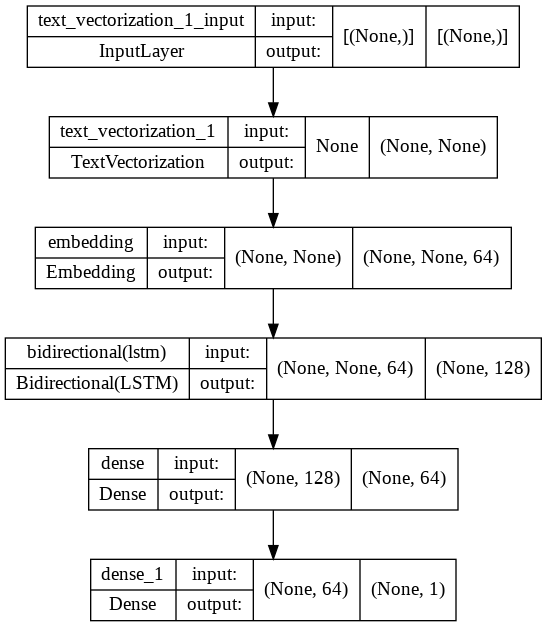

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [34]:
for layer in model.layers:
  print(layer)

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [32]:
print([layer.supports_masking for layer in model.layers])
# 'False' indicates the padded word will be automatically identified and ignored.
# In the embedding layer, padded words are ignored. 

[False, True, True, True, True]


Compile the Keras model to configure the training process:

In [48]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 104ms/step - loss: 0.6391 - accuracy: 0.5756 - val_loss: 0.4760 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 39s 98ms/step - loss: 0.4015 - accuracy: 0.8163 - val_loss: 0.3637 - val_accuracy: 0.8333
Epoch 3/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3396 - accuracy: 0.8498 - val_loss: 0.3412 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3227 - accuracy: 0.8586 - val_loss: 0.3283 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3133 - accuracy: 0.8642 - val_loss: 0.3239 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 39s 97ms/step - loss: 0.3096 - accuracy: 0.8670 - val_loss: 0.3607 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 39s 99ms/step - loss: 0.3048 - accuracy: 0.8699 - val_loss: 0.3300 - val_accuracy

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# We can confirm the model showed approximately 85% classification performance.

391/391 [==============================] - 18s 45ms/step - loss: 0.3158 - accuracy: 0.8528
Test Loss: 0.3158394396305084
Test Accuracy: 0.852840006351471


(0.0, 0.6561975792050362)

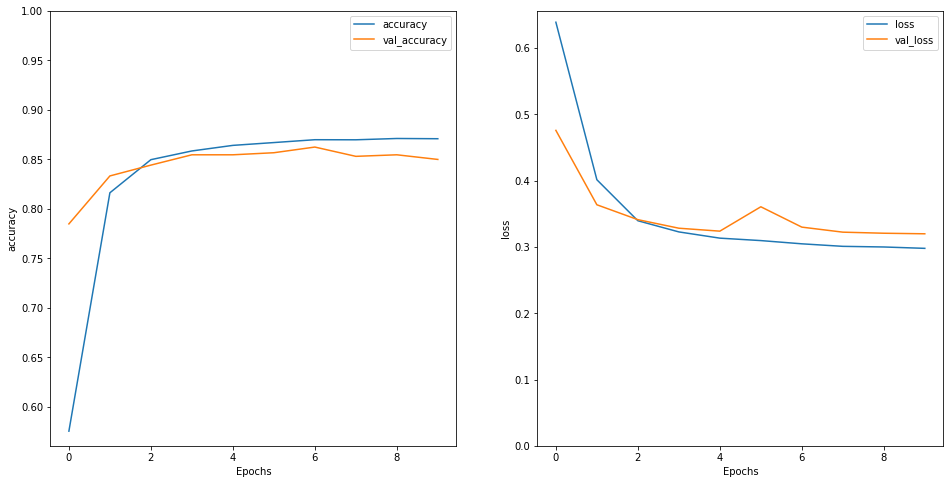

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [32]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.72226024]]


In [33]:
sample_text = ('This is the worst movie I have ever watched.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8280061]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

layered_bidirectional


<img src="https://drive.google.com/uc?export=view&id=1oEbBdh_Ee6DwC8zakwKdbfz0hDQvfs-B" width = 60%></img>

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:32:05 - loss: 0.6937 - accuracy: 0.6250

  2/391 [..............................] - ETA: 55s - loss: 0.6932 - accuracy: 0.5703    

  3/391 [..............................] - ETA: 49s - loss: 0.6935 - accuracy: 0.5677

  4/391 [..............................] - ETA: 50s - loss: 0.6934 - accuracy: 0.5430

  5/391 [..............................] - ETA: 51s - loss: 0.6933 - accuracy: 0.5437

  6/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5365

  7/391 [..............................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5379

  8/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5410

  9/391 [..............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5330

 10/391 [..............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5328

 11/391 [..............................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5227

 12/391 [..............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5208

 13/391 [..............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5156

 14/391 [>.............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5234

 15/391 [>.............................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5177

 16/391 [>.............................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5186

 17/391 [>.............................] - ETA: 50s - loss: 0.6933 - accuracy: 0.5110

 18/391 [>.............................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5095

 19/391 [>.............................] - ETA: 49s - loss: 0.6933 - accuracy: 0.5058

 20/391 [>.............................] - ETA: 49s - loss: 0.6933 - accuracy: 0.5023

 21/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5022

 22/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5007

 23/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4993

 24/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5033

 25/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5088

 26/391 [>.............................] - ETA: 48s - loss: 0.6933 - accuracy: 0.5084

 27/391 [=>............................] - ETA: 47s - loss: 0.6933 - accuracy: 0.5087

 28/391 [=>............................] - ETA: 47s - loss: 0.6933 - accuracy: 0.5123

 29/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5145

 30/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5104

 31/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5060

 32/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5073

 33/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5090

 34/391 [=>............................] - ETA: 46s - loss: 0.6933 - accuracy: 0.5055

 35/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5089

 36/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5061

 37/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5055

 38/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5021

 39/391 [=>............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4988

 40/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4980

 41/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5004

 42/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5004

 43/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4996

 44/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5011

 45/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5035

 46/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5048

 47/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5060

 48/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5055

 49/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5054

 50/391 [==>...........................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5056

 51/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5064

 52/391 [==>...........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5054

 53/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5029

 54/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5023

 55/391 [===>..........................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5031

 56/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5061

 57/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5055

 58/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5059

 59/391 [===>..........................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5053

 60/391 [===>..........................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5049

 61/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5056

 62/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5048

 63/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5042

 64/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5032

 65/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5041

 66/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5040

 67/391 [====>.........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5056

 68/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5067

 69/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5072

 70/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5078

 71/391 [====>.........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5075

 72/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5080

 73/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5077

 74/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5089

 75/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5085

 76/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5068

 77/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5071

 78/391 [====>.........................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5068

 79/391 [=====>........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5059

 80/391 [=====>........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5066

 81/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5068

 82/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5044

 83/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5040

 84/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5056

 85/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5055

 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5051

 87/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5054

 88/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5050

 89/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5054

 90/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5056

 91/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5057

 92/391 [======>.......................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5053

 93/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5054

 94/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5057

 95/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5054

 96/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5052

 97/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5058

 98/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5056

 99/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5057

100/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5061

101/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5070

102/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5064

103/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5058

104/391 [======>.......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5066

105/391 [=======>......................] - ETA: 36s - loss: 0.6928 - accuracy: 0.5068

106/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5071

107/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5057

108/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5058

109/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5053

110/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5047

111/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5051

112/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5059

113/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5047

114/391 [=======>......................] - ETA: 35s - loss: 0.6928 - accuracy: 0.5048

115/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5042

116/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5032

117/391 [=======>......................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5028

118/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5025

119/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5022

120/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.5021

121/391 [========>.....................] - ETA: 34s - loss: 0.6926 - accuracy: 0.5021

122/391 [========>.....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.5028

123/391 [========>.....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.5033

124/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034

125/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034

126/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5036

127/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034

128/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5034

129/391 [========>.....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.5035

130/391 [========>.....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5034

131/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5030

132/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5026

133/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.5019

134/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5019

135/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5023

136/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5023

137/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5024

138/391 [=========>....................] - ETA: 32s - loss: 0.6925 - accuracy: 0.5028

139/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5028

140/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5025

141/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5023

142/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5029

143/391 [=========>....................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5027

144/391 [==========>...................] - ETA: 31s - loss: 0.6925 - accuracy: 0.5028

145/391 [==========>...................] - ETA: 31s - loss: 0.6924 - accuracy: 0.5025

146/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5026

147/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5030

148/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5032

149/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5034

150/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5041

151/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5034

152/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5039

153/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5035

154/391 [==========>...................] - ETA: 30s - loss: 0.6924 - accuracy: 0.5042

155/391 [==========>...................] - ETA: 29s - loss: 0.6924 - accuracy: 0.5043

156/391 [==========>...................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5044

157/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049

158/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5047

159/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049

160/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5045

161/391 [===========>..................] - ETA: 29s - loss: 0.6923 - accuracy: 0.5049

162/391 [===========>..................] - ETA: 29s - loss: 0.6922 - accuracy: 0.5044

163/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5049

164/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5051

165/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5052

166/391 [===========>..................] - ETA: 28s - loss: 0.6922 - accuracy: 0.5050

167/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5051

168/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5055

169/391 [===========>..................] - ETA: 28s - loss: 0.6921 - accuracy: 0.5054

170/391 [============>.................] - ETA: 27s - loss: 0.6921 - accuracy: 0.5051

171/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5054

172/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5051

173/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5052

174/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5049

175/391 [============>.................] - ETA: 27s - loss: 0.6920 - accuracy: 0.5053

176/391 [============>.................] - ETA: 27s - loss: 0.6919 - accuracy: 0.5055

177/391 [============>.................] - ETA: 27s - loss: 0.6919 - accuracy: 0.5053

178/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5054

179/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5054

180/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5050

181/391 [============>.................] - ETA: 26s - loss: 0.6919 - accuracy: 0.5050

182/391 [============>.................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5046

183/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5045

184/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5048

185/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5045

186/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5046

187/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5047

188/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5044

189/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5049

190/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5043

191/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5037

192/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5031

193/391 [=============>................] - ETA: 25s - loss: 0.6915 - accuracy: 0.5024

194/391 [=============>................] - ETA: 25s - loss: 0.6915 - accuracy: 0.5023

195/391 [=============>................] - ETA: 24s - loss: 0.6915 - accuracy: 0.5021

196/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5018

197/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5017

198/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5017

199/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5012

200/391 [==============>...............] - ETA: 24s - loss: 0.6913 - accuracy: 0.5006

201/391 [==============>...............] - ETA: 24s - loss: 0.6913 - accuracy: 0.5005

202/391 [==============>...............] - ETA: 24s - loss: 0.6912 - accuracy: 0.5002

203/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5002

204/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5001

205/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5000

206/391 [==============>...............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5001

207/391 [==============>...............] - ETA: 23s - loss: 0.6911 - accuracy: 0.4999

208/391 [==============>...............] - ETA: 23s - loss: 0.6911 - accuracy: 0.5001

209/391 [===============>..............] - ETA: 23s - loss: 0.6910 - accuracy: 0.5001

210/391 [===============>..............] - ETA: 23s - loss: 0.6910 - accuracy: 0.5002

211/391 [===============>..............] - ETA: 22s - loss: 0.6910 - accuracy: 0.5004

212/391 [===============>..............] - ETA: 22s - loss: 0.6910 - accuracy: 0.5002

213/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.4999

214/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.5000

215/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.5000

216/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.5001

217/391 [===============>..............] - ETA: 22s - loss: 0.6908 - accuracy: 0.4999

218/391 [===============>..............] - ETA: 22s - loss: 0.6907 - accuracy: 0.4999

219/391 [===============>..............] - ETA: 21s - loss: 0.6907 - accuracy: 0.5002

220/391 [===============>..............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5009

221/391 [===============>..............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5013

222/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5011

223/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5006

224/391 [================>.............] - ETA: 21s - loss: 0.6904 - accuracy: 0.5007

225/391 [================>.............] - ETA: 21s - loss: 0.6904 - accuracy: 0.5002

226/391 [================>.............] - ETA: 21s - loss: 0.6903 - accuracy: 0.5006

227/391 [================>.............] - ETA: 20s - loss: 0.6902 - accuracy: 0.5004

228/391 [================>.............] - ETA: 20s - loss: 0.6901 - accuracy: 0.5009

229/391 [================>.............] - ETA: 20s - loss: 0.6899 - accuracy: 0.5011

230/391 [================>.............] - ETA: 20s - loss: 0.6899 - accuracy: 0.5010

231/391 [================>.............] - ETA: 20s - loss: 0.6898 - accuracy: 0.5009

232/391 [================>.............] - ETA: 20s - loss: 0.6896 - accuracy: 0.5009

233/391 [================>.............] - ETA: 20s - loss: 0.6894 - accuracy: 0.5011

234/391 [================>.............] - ETA: 20s - loss: 0.6892 - accuracy: 0.5011

235/391 [=================>............] - ETA: 19s - loss: 0.6891 - accuracy: 0.5009

236/391 [=================>............] - ETA: 19s - loss: 0.6891 - accuracy: 0.5007

237/391 [=================>............] - ETA: 19s - loss: 0.6890 - accuracy: 0.5009

238/391 [=================>............] - ETA: 19s - loss: 0.6888 - accuracy: 0.5012

239/391 [=================>............] - ETA: 19s - loss: 0.6887 - accuracy: 0.5011

240/391 [=================>............] - ETA: 19s - loss: 0.6884 - accuracy: 0.5018

241/391 [=================>............] - ETA: 19s - loss: 0.6882 - accuracy: 0.5020

242/391 [=================>............] - ETA: 18s - loss: 0.6880 - accuracy: 0.5022

243/391 [=================>............] - ETA: 18s - loss: 0.6879 - accuracy: 0.5023

244/391 [=================>............] - ETA: 18s - loss: 0.6876 - accuracy: 0.5023

245/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5030

246/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5034

247/391 [=================>............] - ETA: 18s - loss: 0.6869 - accuracy: 0.5042

248/391 [==================>...........] - ETA: 18s - loss: 0.6865 - accuracy: 0.5055

249/391 [==================>...........] - ETA: 18s - loss: 0.6863 - accuracy: 0.5063

250/391 [==================>...........] - ETA: 17s - loss: 0.6858 - accuracy: 0.5070

251/391 [==================>...........] - ETA: 17s - loss: 0.6854 - accuracy: 0.5075

252/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5078

253/391 [==================>...........] - ETA: 17s - loss: 0.6847 - accuracy: 0.5083

254/391 [==================>...........] - ETA: 17s - loss: 0.6846 - accuracy: 0.5085

255/391 [==================>...........] - ETA: 17s - loss: 0.6841 - accuracy: 0.5089

256/391 [==================>...........] - ETA: 17s - loss: 0.6836 - accuracy: 0.5094

257/391 [==================>...........] - ETA: 17s - loss: 0.6831 - accuracy: 0.5103

258/391 [==================>...........] - ETA: 16s - loss: 0.6825 - accuracy: 0.5114

259/391 [==================>...........] - ETA: 16s - loss: 0.6818 - accuracy: 0.5123

260/391 [==================>...........] - ETA: 16s - loss: 0.6813 - accuracy: 0.5132

261/391 [===================>..........] - ETA: 16s - loss: 0.6812 - accuracy: 0.5135

262/391 [===================>..........] - ETA: 16s - loss: 0.6812 - accuracy: 0.5137

263/391 [===================>..........] - ETA: 16s - loss: 0.6806 - accuracy: 0.5147

264/391 [===================>..........] - ETA: 16s - loss: 0.6799 - accuracy: 0.5156

265/391 [===================>..........] - ETA: 16s - loss: 0.6793 - accuracy: 0.5166

266/391 [===================>..........] - ETA: 15s - loss: 0.6787 - accuracy: 0.5175

267/391 [===================>..........] - ETA: 15s - loss: 0.6784 - accuracy: 0.5181

268/391 [===================>..........] - ETA: 15s - loss: 0.6777 - accuracy: 0.5188

269/391 [===================>..........] - ETA: 15s - loss: 0.6772 - accuracy: 0.5198

270/391 [===================>..........] - ETA: 15s - loss: 0.6771 - accuracy: 0.5203

271/391 [===================>..........] - ETA: 15s - loss: 0.6767 - accuracy: 0.5210

272/391 [===================>..........] - ETA: 15s - loss: 0.6764 - accuracy: 0.5217

273/391 [===================>..........] - ETA: 14s - loss: 0.6760 - accuracy: 0.5223

274/391 [====================>.........] - ETA: 14s - loss: 0.6756 - accuracy: 0.5234

275/391 [====================>.........] - ETA: 14s - loss: 0.6751 - accuracy: 0.5241

276/391 [====================>.........] - ETA: 14s - loss: 0.6742 - accuracy: 0.5249

277/391 [====================>.........] - ETA: 14s - loss: 0.6738 - accuracy: 0.5253

278/391 [====================>.........] - ETA: 14s - loss: 0.6732 - accuracy: 0.5261

279/391 [====================>.........] - ETA: 14s - loss: 0.6727 - accuracy: 0.5268

280/391 [====================>.........] - ETA: 14s - loss: 0.6722 - accuracy: 0.5273

281/391 [====================>.........] - ETA: 13s - loss: 0.6717 - accuracy: 0.5282

282/391 [====================>.........] - ETA: 13s - loss: 0.6714 - accuracy: 0.5288

283/391 [====================>.........] - ETA: 13s - loss: 0.6708 - accuracy: 0.5296

284/391 [====================>.........] - ETA: 13s - loss: 0.6701 - accuracy: 0.5307

285/391 [====================>.........] - ETA: 13s - loss: 0.6695 - accuracy: 0.5318

286/391 [====================>.........] - ETA: 13s - loss: 0.6694 - accuracy: 0.5323

287/391 [=====================>........] - ETA: 13s - loss: 0.6687 - accuracy: 0.5334

288/391 [=====================>........] - ETA: 13s - loss: 0.6681 - accuracy: 0.5341

289/391 [=====================>........] - ETA: 12s - loss: 0.6675 - accuracy: 0.5348

290/391 [=====================>........] - ETA: 12s - loss: 0.6668 - accuracy: 0.5357

291/391 [=====================>........] - ETA: 12s - loss: 0.6661 - accuracy: 0.5367

292/391 [=====================>........] - ETA: 12s - loss: 0.6658 - accuracy: 0.5374

293/391 [=====================>........] - ETA: 12s - loss: 0.6655 - accuracy: 0.5379

294/391 [=====================>........] - ETA: 12s - loss: 0.6649 - accuracy: 0.5388

295/391 [=====================>........] - ETA: 12s - loss: 0.6645 - accuracy: 0.5394

296/391 [=====================>........] - ETA: 11s - loss: 0.6641 - accuracy: 0.5400

297/391 [=====================>........] - ETA: 11s - loss: 0.6633 - accuracy: 0.5408

298/391 [=====================>........] - ETA: 11s - loss: 0.6625 - accuracy: 0.5417

299/391 [=====================>........] - ETA: 11s - loss: 0.6620 - accuracy: 0.5424

300/391 [======================>.......] - ETA: 11s - loss: 0.6614 - accuracy: 0.5432

301/391 [======================>.......] - ETA: 11s - loss: 0.6607 - accuracy: 0.5442

302/391 [======================>.......] - ETA: 11s - loss: 0.6601 - accuracy: 0.5451

303/391 [======================>.......] - ETA: 11s - loss: 0.6595 - accuracy: 0.5458

304/391 [======================>.......] - ETA: 10s - loss: 0.6589 - accuracy: 0.5468

305/391 [======================>.......] - ETA: 10s - loss: 0.6585 - accuracy: 0.5474

306/391 [======================>.......] - ETA: 10s - loss: 0.6581 - accuracy: 0.5482

307/391 [======================>.......] - ETA: 10s - loss: 0.6571 - accuracy: 0.5493

308/391 [======================>.......] - ETA: 10s - loss: 0.6569 - accuracy: 0.5499

309/391 [======================>.......] - ETA: 10s - loss: 0.6564 - accuracy: 0.5507

310/391 [======================>.......] - ETA: 10s - loss: 0.6558 - accuracy: 0.5515

311/391 [======================>.......] - ETA: 10s - loss: 0.6551 - accuracy: 0.5524

312/391 [======================>.......] - ETA: 9s - loss: 0.6544 - accuracy: 0.5532 

313/391 [=======================>......] - ETA: 9s - loss: 0.6539 - accuracy: 0.5538

314/391 [=======================>......] - ETA: 9s - loss: 0.6538 - accuracy: 0.5544

315/391 [=======================>......] - ETA: 9s - loss: 0.6534 - accuracy: 0.5550

316/391 [=======================>......] - ETA: 9s - loss: 0.6528 - accuracy: 0.5557

317/391 [=======================>......] - ETA: 9s - loss: 0.6522 - accuracy: 0.5563

318/391 [=======================>......] - ETA: 9s - loss: 0.6518 - accuracy: 0.5570

319/391 [=======================>......] - ETA: 9s - loss: 0.6515 - accuracy: 0.5574

320/391 [=======================>......] - ETA: 8s - loss: 0.6507 - accuracy: 0.5583

321/391 [=======================>......] - ETA: 8s - loss: 0.6502 - accuracy: 0.5589

322/391 [=======================>......] - ETA: 8s - loss: 0.6497 - accuracy: 0.5594

323/391 [=======================>......] - ETA: 8s - loss: 0.6490 - accuracy: 0.5602

324/391 [=======================>......] - ETA: 8s - loss: 0.6484 - accuracy: 0.5609

325/391 [=======================>......] - ETA: 8s - loss: 0.6479 - accuracy: 0.5615

326/391 [========================>.....] - ETA: 8s - loss: 0.6475 - accuracy: 0.5621

327/391 [========================>.....] - ETA: 8s - loss: 0.6470 - accuracy: 0.5629

328/391 [========================>.....] - ETA: 7s - loss: 0.6467 - accuracy: 0.5632

329/391 [========================>.....] - ETA: 7s - loss: 0.6463 - accuracy: 0.5637

330/391 [========================>.....] - ETA: 7s - loss: 0.6461 - accuracy: 0.5643

331/391 [========================>.....] - ETA: 7s - loss: 0.6456 - accuracy: 0.5649

332/391 [========================>.....] - ETA: 7s - loss: 0.6451 - accuracy: 0.5655

333/391 [========================>.....] - ETA: 7s - loss: 0.6444 - accuracy: 0.5662

334/391 [========================>.....] - ETA: 7s - loss: 0.6438 - accuracy: 0.5669

335/391 [========================>.....] - ETA: 7s - loss: 0.6434 - accuracy: 0.5675

336/391 [========================>.....] - ETA: 6s - loss: 0.6427 - accuracy: 0.5683

337/391 [========================>.....] - ETA: 6s - loss: 0.6422 - accuracy: 0.5690

338/391 [========================>.....] - ETA: 6s - loss: 0.6421 - accuracy: 0.5694

339/391 [=========================>....] - ETA: 6s - loss: 0.6417 - accuracy: 0.5700

340/391 [=========================>....] - ETA: 6s - loss: 0.6410 - accuracy: 0.5709

341/391 [=========================>....] - ETA: 6s - loss: 0.6404 - accuracy: 0.5716

342/391 [=========================>....] - ETA: 6s - loss: 0.6399 - accuracy: 0.5721

343/391 [=========================>....] - ETA: 6s - loss: 0.6393 - accuracy: 0.5727

344/391 [=========================>....] - ETA: 5s - loss: 0.6386 - accuracy: 0.5736

345/391 [=========================>....] - ETA: 5s - loss: 0.6380 - accuracy: 0.5742

346/391 [=========================>....] - ETA: 5s - loss: 0.6374 - accuracy: 0.5749

347/391 [=========================>....] - ETA: 5s - loss: 0.6371 - accuracy: 0.5754

348/391 [=========================>....] - ETA: 5s - loss: 0.6371 - accuracy: 0.5757

349/391 [=========================>....] - ETA: 5s - loss: 0.6367 - accuracy: 0.5762

350/391 [=========================>....] - ETA: 5s - loss: 0.6365 - accuracy: 0.5767

351/391 [=========================>....] - ETA: 5s - loss: 0.6355 - accuracy: 0.5777

352/391 [==========================>...] - ETA: 4s - loss: 0.6348 - accuracy: 0.5785

353/391 [==========================>...] - ETA: 4s - loss: 0.6344 - accuracy: 0.5791

354/391 [==========================>...] - ETA: 4s - loss: 0.6338 - accuracy: 0.5798

355/391 [==========================>...] - ETA: 4s - loss: 0.6328 - accuracy: 0.5807

356/391 [==========================>...] - ETA: 4s - loss: 0.6323 - accuracy: 0.5813

357/391 [==========================>...] - ETA: 4s - loss: 0.6317 - accuracy: 0.5820

358/391 [==========================>...] - ETA: 4s - loss: 0.6315 - accuracy: 0.5825

359/391 [==========================>...] - ETA: 4s - loss: 0.6309 - accuracy: 0.5832

360/391 [==========================>...] - ETA: 3s - loss: 0.6303 - accuracy: 0.5838

361/391 [==========================>...] - ETA: 3s - loss: 0.6301 - accuracy: 0.5842

362/391 [==========================>...] - ETA: 3s - loss: 0.6298 - accuracy: 0.5846

363/391 [==========================>...] - ETA: 3s - loss: 0.6294 - accuracy: 0.5852

364/391 [==========================>...] - ETA: 3s - loss: 0.6288 - accuracy: 0.5859

365/391 [===========================>..] - ETA: 3s - loss: 0.6284 - accuracy: 0.5864

366/391 [===========================>..] - ETA: 3s - loss: 0.6282 - accuracy: 0.5868

367/391 [===========================>..] - ETA: 3s - loss: 0.6280 - accuracy: 0.5872

368/391 [===========================>..] - ETA: 2s - loss: 0.6273 - accuracy: 0.5878

369/391 [===========================>..] - ETA: 2s - loss: 0.6272 - accuracy: 0.5883

370/391 [===========================>..] - ETA: 2s - loss: 0.6265 - accuracy: 0.5891

371/391 [===========================>..] - ETA: 2s - loss: 0.6261 - accuracy: 0.5897

372/391 [===========================>..] - ETA: 2s - loss: 0.6255 - accuracy: 0.5903

373/391 [===========================>..] - ETA: 2s - loss: 0.6253 - accuracy: 0.5908

374/391 [===========================>..] - ETA: 2s - loss: 0.6246 - accuracy: 0.5915

375/391 [===========================>..] - ETA: 2s - loss: 0.6239 - accuracy: 0.5921

376/391 [===========================>..] - ETA: 1s - loss: 0.6234 - accuracy: 0.5927

377/391 [===========================>..] - ETA: 1s - loss: 0.6229 - accuracy: 0.5933

378/391 [============================>.] - ETA: 1s - loss: 0.6229 - accuracy: 0.5936

379/391 [============================>.] - ETA: 1s - loss: 0.6223 - accuracy: 0.5942

380/391 [============================>.] - ETA: 1s - loss: 0.6218 - accuracy: 0.5948

381/391 [============================>.] - ETA: 1s - loss: 0.6214 - accuracy: 0.5953

382/391 [============================>.] - ETA: 1s - loss: 0.6206 - accuracy: 0.5960

383/391 [============================>.] - ETA: 1s - loss: 0.6202 - accuracy: 0.5965

384/391 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.5970

385/391 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.5975

386/391 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.5980

387/391 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.5984

388/391 [============================>.] - ETA: 0s - loss: 0.6181 - accuracy: 0.5991

389/391 [============================>.] - ETA: 0s - loss: 0.6174 - accuracy: 0.5997

390/391 [============================>.] - ETA: 0s - loss: 0.6166 - accuracy: 0.6004

391/391 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6006

391/391 [==============================] - 71s 145ms/step - loss: 0.6166 - accuracy: 0.6006 - val_loss: 0.4270 - val_accuracy: 0.8125


Epoch 2/10


  1/391 [..............................] - ETA: 4:52 - loss: 0.3987 - accuracy: 0.8125

  2/391 [..............................] - ETA: 51s - loss: 0.4086 - accuracy: 0.8047 

  3/391 [..............................] - ETA: 52s - loss: 0.4404 - accuracy: 0.7969

  4/391 [..............................] - ETA: 51s - loss: 0.4424 - accuracy: 0.8008

  5/391 [..............................] - ETA: 48s - loss: 0.4262 - accuracy: 0.8156

  6/391 [..............................] - ETA: 46s - loss: 0.4285 - accuracy: 0.8073

  7/391 [..............................] - ETA: 45s - loss: 0.4328 - accuracy: 0.8036

  8/391 [..............................] - ETA: 48s - loss: 0.4303 - accuracy: 0.8086

  9/391 [..............................] - ETA: 49s - loss: 0.4125 - accuracy: 0.8229

 10/391 [..............................] - ETA: 48s - loss: 0.4185 - accuracy: 0.8188

 11/391 [..............................] - ETA: 47s - loss: 0.4212 - accuracy: 0.8182

 12/391 [..............................] - ETA: 48s - loss: 0.4195 - accuracy: 0.8190

 13/391 [..............................] - ETA: 48s - loss: 0.4172 - accuracy: 0.8209

 14/391 [>.............................] - ETA: 47s - loss: 0.4192 - accuracy: 0.8203

 15/391 [>.............................] - ETA: 47s - loss: 0.4202 - accuracy: 0.8198

 16/391 [>.............................] - ETA: 47s - loss: 0.4229 - accuracy: 0.8174

 17/391 [>.............................] - ETA: 46s - loss: 0.4198 - accuracy: 0.8208

 18/391 [>.............................] - ETA: 46s - loss: 0.4234 - accuracy: 0.8186

 19/391 [>.............................] - ETA: 46s - loss: 0.4229 - accuracy: 0.8183

 20/391 [>.............................] - ETA: 45s - loss: 0.4264 - accuracy: 0.8164

 21/391 [>.............................] - ETA: 45s - loss: 0.4209 - accuracy: 0.8207

 22/391 [>.............................] - ETA: 45s - loss: 0.4244 - accuracy: 0.8189

 23/391 [>.............................] - ETA: 45s - loss: 0.4261 - accuracy: 0.8173

 24/391 [>.............................] - ETA: 45s - loss: 0.4276 - accuracy: 0.8158

 25/391 [>.............................] - ETA: 44s - loss: 0.4278 - accuracy: 0.8144

 26/391 [>.............................] - ETA: 45s - loss: 0.4294 - accuracy: 0.8143

 27/391 [=>............................] - ETA: 45s - loss: 0.4292 - accuracy: 0.8148

 28/391 [=>............................] - ETA: 45s - loss: 0.4270 - accuracy: 0.8158

 29/391 [=>............................] - ETA: 45s - loss: 0.4268 - accuracy: 0.8163

 30/391 [=>............................] - ETA: 45s - loss: 0.4242 - accuracy: 0.8177

 31/391 [=>............................] - ETA: 44s - loss: 0.4210 - accuracy: 0.8206

 32/391 [=>............................] - ETA: 44s - loss: 0.4189 - accuracy: 0.8208

 33/391 [=>............................] - ETA: 45s - loss: 0.4191 - accuracy: 0.8210

 34/391 [=>............................] - ETA: 45s - loss: 0.4206 - accuracy: 0.8203

 35/391 [=>............................] - ETA: 44s - loss: 0.4181 - accuracy: 0.8223

 36/391 [=>............................] - ETA: 44s - loss: 0.4188 - accuracy: 0.8220

 37/391 [=>............................] - ETA: 44s - loss: 0.4194 - accuracy: 0.8209

 38/391 [=>............................] - ETA: 44s - loss: 0.4176 - accuracy: 0.8207

 39/391 [=>............................] - ETA: 43s - loss: 0.4208 - accuracy: 0.8169

 40/391 [==>...........................] - ETA: 43s - loss: 0.4204 - accuracy: 0.8176

 41/391 [==>...........................] - ETA: 43s - loss: 0.4201 - accuracy: 0.8163

 42/391 [==>...........................] - ETA: 43s - loss: 0.4209 - accuracy: 0.8162

 43/391 [==>...........................] - ETA: 43s - loss: 0.4181 - accuracy: 0.8183

 44/391 [==>...........................] - ETA: 43s - loss: 0.4174 - accuracy: 0.8182

 45/391 [==>...........................] - ETA: 43s - loss: 0.4206 - accuracy: 0.8167

 46/391 [==>...........................] - ETA: 42s - loss: 0.4217 - accuracy: 0.8169

 47/391 [==>...........................] - ETA: 42s - loss: 0.4201 - accuracy: 0.8185

 48/391 [==>...........................] - ETA: 42s - loss: 0.4202 - accuracy: 0.8184

 49/391 [==>...........................] - ETA: 42s - loss: 0.4193 - accuracy: 0.8189

 50/391 [==>...........................] - ETA: 42s - loss: 0.4184 - accuracy: 0.8191

 51/391 [==>...........................] - ETA: 41s - loss: 0.4168 - accuracy: 0.8189

 52/391 [==>...........................] - ETA: 41s - loss: 0.4181 - accuracy: 0.8176

 53/391 [===>..........................] - ETA: 41s - loss: 0.4180 - accuracy: 0.8169

 54/391 [===>..........................] - ETA: 41s - loss: 0.4171 - accuracy: 0.8171

 55/391 [===>..........................] - ETA: 41s - loss: 0.4149 - accuracy: 0.8190

 56/391 [===>..........................] - ETA: 41s - loss: 0.4159 - accuracy: 0.8184

 57/391 [===>..........................] - ETA: 41s - loss: 0.4156 - accuracy: 0.8177

 58/391 [===>..........................] - ETA: 40s - loss: 0.4153 - accuracy: 0.8182

 59/391 [===>..........................] - ETA: 40s - loss: 0.4166 - accuracy: 0.8178

 60/391 [===>..........................] - ETA: 40s - loss: 0.4182 - accuracy: 0.8164

 61/391 [===>..........................] - ETA: 40s - loss: 0.4201 - accuracy: 0.8151

 62/391 [===>..........................] - ETA: 40s - loss: 0.4203 - accuracy: 0.8145

 63/391 [===>..........................] - ETA: 40s - loss: 0.4208 - accuracy: 0.8142

 64/391 [===>..........................] - ETA: 40s - loss: 0.4210 - accuracy: 0.8135

 65/391 [===>..........................] - ETA: 40s - loss: 0.4203 - accuracy: 0.8142

 66/391 [====>.........................] - ETA: 40s - loss: 0.4187 - accuracy: 0.8153

 67/391 [====>.........................] - ETA: 40s - loss: 0.4189 - accuracy: 0.8151

 68/391 [====>.........................] - ETA: 40s - loss: 0.4189 - accuracy: 0.8153

 69/391 [====>.........................] - ETA: 40s - loss: 0.4195 - accuracy: 0.8145

 70/391 [====>.........................] - ETA: 40s - loss: 0.4184 - accuracy: 0.8152

 71/391 [====>.........................] - ETA: 39s - loss: 0.4180 - accuracy: 0.8154

 72/391 [====>.........................] - ETA: 39s - loss: 0.4175 - accuracy: 0.8155

 73/391 [====>.........................] - ETA: 39s - loss: 0.4164 - accuracy: 0.8166

 74/391 [====>.........................] - ETA: 39s - loss: 0.4164 - accuracy: 0.8167

 75/391 [====>.........................] - ETA: 39s - loss: 0.4152 - accuracy: 0.8173

 76/391 [====>.........................] - ETA: 39s - loss: 0.4150 - accuracy: 0.8174

 77/391 [====>.........................] - ETA: 39s - loss: 0.4144 - accuracy: 0.8178

 78/391 [====>.........................] - ETA: 39s - loss: 0.4144 - accuracy: 0.8179

 79/391 [=====>........................] - ETA: 39s - loss: 0.4132 - accuracy: 0.8186

 80/391 [=====>........................] - ETA: 39s - loss: 0.4141 - accuracy: 0.8184

 81/391 [=====>........................] - ETA: 39s - loss: 0.4143 - accuracy: 0.8185

 82/391 [=====>........................] - ETA: 39s - loss: 0.4139 - accuracy: 0.8180

 83/391 [=====>........................] - ETA: 38s - loss: 0.4148 - accuracy: 0.8178

 84/391 [=====>........................] - ETA: 38s - loss: 0.4137 - accuracy: 0.8186

 85/391 [=====>........................] - ETA: 38s - loss: 0.4145 - accuracy: 0.8184

 86/391 [=====>........................] - ETA: 38s - loss: 0.4143 - accuracy: 0.8187

 87/391 [=====>........................] - ETA: 38s - loss: 0.4142 - accuracy: 0.8184

 88/391 [=====>........................] - ETA: 38s - loss: 0.4149 - accuracy: 0.8176

 89/391 [=====>........................] - ETA: 38s - loss: 0.4148 - accuracy: 0.8178

 90/391 [=====>........................] - ETA: 37s - loss: 0.4152 - accuracy: 0.8174

 91/391 [=====>........................] - ETA: 37s - loss: 0.4142 - accuracy: 0.8175

 92/391 [======>.......................] - ETA: 37s - loss: 0.4130 - accuracy: 0.8181

 93/391 [======>.......................] - ETA: 37s - loss: 0.4124 - accuracy: 0.8187

 94/391 [======>.......................] - ETA: 37s - loss: 0.4125 - accuracy: 0.8190

 95/391 [======>.......................] - ETA: 37s - loss: 0.4119 - accuracy: 0.8194

 96/391 [======>.......................] - ETA: 37s - loss: 0.4109 - accuracy: 0.8203

 97/391 [======>.......................] - ETA: 36s - loss: 0.4108 - accuracy: 0.8204

 98/391 [======>.......................] - ETA: 36s - loss: 0.4111 - accuracy: 0.8200

 99/391 [======>.......................] - ETA: 36s - loss: 0.4112 - accuracy: 0.8194

100/391 [======>.......................] - ETA: 36s - loss: 0.4121 - accuracy: 0.8189

101/391 [======>.......................] - ETA: 36s - loss: 0.4120 - accuracy: 0.8184

102/391 [======>.......................] - ETA: 36s - loss: 0.4116 - accuracy: 0.8188

103/391 [======>.......................] - ETA: 36s - loss: 0.4117 - accuracy: 0.8187

104/391 [======>.......................] - ETA: 36s - loss: 0.4109 - accuracy: 0.8193

105/391 [=======>......................] - ETA: 36s - loss: 0.4105 - accuracy: 0.8195

106/391 [=======>......................] - ETA: 35s - loss: 0.4104 - accuracy: 0.8197

107/391 [=======>......................] - ETA: 35s - loss: 0.4111 - accuracy: 0.8197

108/391 [=======>......................] - ETA: 35s - loss: 0.4108 - accuracy: 0.8203

109/391 [=======>......................] - ETA: 35s - loss: 0.4107 - accuracy: 0.8208

110/391 [=======>......................] - ETA: 35s - loss: 0.4106 - accuracy: 0.8202

111/391 [=======>......................] - ETA: 35s - loss: 0.4104 - accuracy: 0.8202

112/391 [=======>......................] - ETA: 35s - loss: 0.4111 - accuracy: 0.8200

113/391 [=======>......................] - ETA: 34s - loss: 0.4115 - accuracy: 0.8198

114/391 [=======>......................] - ETA: 34s - loss: 0.4109 - accuracy: 0.8202

115/391 [=======>......................] - ETA: 34s - loss: 0.4103 - accuracy: 0.8205

116/391 [=======>......................] - ETA: 34s - loss: 0.4103 - accuracy: 0.8206

117/391 [=======>......................] - ETA: 34s - loss: 0.4096 - accuracy: 0.8210

118/391 [========>.....................] - ETA: 34s - loss: 0.4101 - accuracy: 0.8208

119/391 [========>.....................] - ETA: 33s - loss: 0.4100 - accuracy: 0.8210

120/391 [========>.....................] - ETA: 33s - loss: 0.4086 - accuracy: 0.8219

121/391 [========>.....................] - ETA: 33s - loss: 0.4083 - accuracy: 0.8218

122/391 [========>.....................] - ETA: 33s - loss: 0.4074 - accuracy: 0.8220

123/391 [========>.....................] - ETA: 33s - loss: 0.4073 - accuracy: 0.8216

124/391 [========>.....................] - ETA: 33s - loss: 0.4060 - accuracy: 0.8222

125/391 [========>.....................] - ETA: 33s - loss: 0.4055 - accuracy: 0.8226

126/391 [========>.....................] - ETA: 33s - loss: 0.4054 - accuracy: 0.8228

127/391 [========>.....................] - ETA: 33s - loss: 0.4051 - accuracy: 0.8231

128/391 [========>.....................] - ETA: 32s - loss: 0.4044 - accuracy: 0.8230

129/391 [========>.....................] - ETA: 32s - loss: 0.4036 - accuracy: 0.8234

130/391 [========>.....................] - ETA: 32s - loss: 0.4033 - accuracy: 0.8234

131/391 [=========>....................] - ETA: 32s - loss: 0.4032 - accuracy: 0.8235

132/391 [=========>....................] - ETA: 32s - loss: 0.4040 - accuracy: 0.8233

133/391 [=========>....................] - ETA: 32s - loss: 0.4025 - accuracy: 0.8239

134/391 [=========>....................] - ETA: 32s - loss: 0.4019 - accuracy: 0.8243

135/391 [=========>....................] - ETA: 32s - loss: 0.4029 - accuracy: 0.8237

136/391 [=========>....................] - ETA: 31s - loss: 0.4039 - accuracy: 0.8231

137/391 [=========>....................] - ETA: 31s - loss: 0.4057 - accuracy: 0.8221

138/391 [=========>....................] - ETA: 31s - loss: 0.4058 - accuracy: 0.8219

139/391 [=========>....................] - ETA: 31s - loss: 0.4059 - accuracy: 0.8219

140/391 [=========>....................] - ETA: 31s - loss: 0.4067 - accuracy: 0.8214

141/391 [=========>....................] - ETA: 31s - loss: 0.4073 - accuracy: 0.8210

142/391 [=========>....................] - ETA: 31s - loss: 0.4074 - accuracy: 0.8210

143/391 [=========>....................] - ETA: 30s - loss: 0.4079 - accuracy: 0.8209

144/391 [==========>...................] - ETA: 30s - loss: 0.4086 - accuracy: 0.8207

145/391 [==========>...................] - ETA: 30s - loss: 0.4091 - accuracy: 0.8208

146/391 [==========>...................] - ETA: 30s - loss: 0.4094 - accuracy: 0.8206

147/391 [==========>...................] - ETA: 30s - loss: 0.4100 - accuracy: 0.8207

148/391 [==========>...................] - ETA: 30s - loss: 0.4101 - accuracy: 0.8209

149/391 [==========>...................] - ETA: 30s - loss: 0.4102 - accuracy: 0.8210

150/391 [==========>...................] - ETA: 30s - loss: 0.4108 - accuracy: 0.8209

151/391 [==========>...................] - ETA: 30s - loss: 0.4106 - accuracy: 0.8211

152/391 [==========>...................] - ETA: 29s - loss: 0.4111 - accuracy: 0.8203

153/391 [==========>...................] - ETA: 29s - loss: 0.4115 - accuracy: 0.8198

154/391 [==========>...................] - ETA: 29s - loss: 0.4118 - accuracy: 0.8195

155/391 [==========>...................] - ETA: 29s - loss: 0.4116 - accuracy: 0.8194

156/391 [==========>...................] - ETA: 29s - loss: 0.4120 - accuracy: 0.8194

157/391 [===========>..................] - ETA: 29s - loss: 0.4130 - accuracy: 0.8182

158/391 [===========>..................] - ETA: 29s - loss: 0.4126 - accuracy: 0.8182

159/391 [===========>..................] - ETA: 29s - loss: 0.4128 - accuracy: 0.8180

160/391 [===========>..................] - ETA: 29s - loss: 0.4123 - accuracy: 0.8186

161/391 [===========>..................] - ETA: 28s - loss: 0.4126 - accuracy: 0.8184

162/391 [===========>..................] - ETA: 28s - loss: 0.4128 - accuracy: 0.8185

163/391 [===========>..................] - ETA: 28s - loss: 0.4127 - accuracy: 0.8183

164/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184

165/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184

166/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8184

167/391 [===========>..................] - ETA: 28s - loss: 0.4126 - accuracy: 0.8181

168/391 [===========>..................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8181

169/391 [===========>..................] - ETA: 27s - loss: 0.4125 - accuracy: 0.8180

170/391 [============>.................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8174

171/391 [============>.................] - ETA: 27s - loss: 0.4135 - accuracy: 0.8170

172/391 [============>.................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8173

173/391 [============>.................] - ETA: 27s - loss: 0.4122 - accuracy: 0.8178

174/391 [============>.................] - ETA: 27s - loss: 0.4124 - accuracy: 0.8176

175/391 [============>.................] - ETA: 27s - loss: 0.4121 - accuracy: 0.8177

176/391 [============>.................] - ETA: 27s - loss: 0.4117 - accuracy: 0.8178

177/391 [============>.................] - ETA: 26s - loss: 0.4115 - accuracy: 0.8178

178/391 [============>.................] - ETA: 26s - loss: 0.4111 - accuracy: 0.8182

179/391 [============>.................] - ETA: 26s - loss: 0.4102 - accuracy: 0.8188

180/391 [============>.................] - ETA: 26s - loss: 0.4104 - accuracy: 0.8188

181/391 [============>.................] - ETA: 26s - loss: 0.4104 - accuracy: 0.8188

182/391 [============>.................] - ETA: 26s - loss: 0.4105 - accuracy: 0.8186

183/391 [=============>................] - ETA: 26s - loss: 0.4102 - accuracy: 0.8190

184/391 [=============>................] - ETA: 25s - loss: 0.4107 - accuracy: 0.8189

185/391 [=============>................] - ETA: 25s - loss: 0.4100 - accuracy: 0.8193

186/391 [=============>................] - ETA: 25s - loss: 0.4094 - accuracy: 0.8197

187/391 [=============>................] - ETA: 25s - loss: 0.4091 - accuracy: 0.8200

188/391 [=============>................] - ETA: 25s - loss: 0.4090 - accuracy: 0.8199

189/391 [=============>................] - ETA: 25s - loss: 0.4081 - accuracy: 0.8202

190/391 [=============>................] - ETA: 25s - loss: 0.4074 - accuracy: 0.8206

191/391 [=============>................] - ETA: 25s - loss: 0.4089 - accuracy: 0.8197

192/391 [=============>................] - ETA: 24s - loss: 0.4093 - accuracy: 0.8195

193/391 [=============>................] - ETA: 24s - loss: 0.4095 - accuracy: 0.8192

194/391 [=============>................] - ETA: 24s - loss: 0.4090 - accuracy: 0.8195

195/391 [=============>................] - ETA: 24s - loss: 0.4092 - accuracy: 0.8196

196/391 [==============>...............] - ETA: 24s - loss: 0.4093 - accuracy: 0.8196

197/391 [==============>...............] - ETA: 24s - loss: 0.4092 - accuracy: 0.8198

198/391 [==============>...............] - ETA: 24s - loss: 0.4087 - accuracy: 0.8202

199/391 [==============>...............] - ETA: 23s - loss: 0.4086 - accuracy: 0.8204

200/391 [==============>...............] - ETA: 23s - loss: 0.4083 - accuracy: 0.8206

201/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8211

202/391 [==============>...............] - ETA: 23s - loss: 0.4083 - accuracy: 0.8206

203/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8209

204/391 [==============>...............] - ETA: 23s - loss: 0.4077 - accuracy: 0.8207

205/391 [==============>...............] - ETA: 23s - loss: 0.4073 - accuracy: 0.8207

206/391 [==============>...............] - ETA: 23s - loss: 0.4074 - accuracy: 0.8205

207/391 [==============>...............] - ETA: 23s - loss: 0.4070 - accuracy: 0.8208

208/391 [==============>...............] - ETA: 22s - loss: 0.4070 - accuracy: 0.8208

209/391 [===============>..............] - ETA: 22s - loss: 0.4068 - accuracy: 0.8208

210/391 [===============>..............] - ETA: 22s - loss: 0.4066 - accuracy: 0.8207

211/391 [===============>..............] - ETA: 22s - loss: 0.4065 - accuracy: 0.8208

212/391 [===============>..............] - ETA: 22s - loss: 0.4062 - accuracy: 0.8209

213/391 [===============>..............] - ETA: 22s - loss: 0.4055 - accuracy: 0.8213

214/391 [===============>..............] - ETA: 22s - loss: 0.4058 - accuracy: 0.8213

215/391 [===============>..............] - ETA: 22s - loss: 0.4061 - accuracy: 0.8214

216/391 [===============>..............] - ETA: 21s - loss: 0.4060 - accuracy: 0.8217

217/391 [===============>..............] - ETA: 21s - loss: 0.4057 - accuracy: 0.8221

218/391 [===============>..............] - ETA: 21s - loss: 0.4058 - accuracy: 0.8222

219/391 [===============>..............] - ETA: 21s - loss: 0.4049 - accuracy: 0.8227

220/391 [===============>..............] - ETA: 21s - loss: 0.4049 - accuracy: 0.8225

221/391 [===============>..............] - ETA: 21s - loss: 0.4048 - accuracy: 0.8227

222/391 [================>.............] - ETA: 21s - loss: 0.4041 - accuracy: 0.8231

223/391 [================>.............] - ETA: 21s - loss: 0.4043 - accuracy: 0.8232

224/391 [================>.............] - ETA: 20s - loss: 0.4038 - accuracy: 0.8235

225/391 [================>.............] - ETA: 20s - loss: 0.4035 - accuracy: 0.8237

226/391 [================>.............] - ETA: 20s - loss: 0.4038 - accuracy: 0.8236

227/391 [================>.............] - ETA: 20s - loss: 0.4043 - accuracy: 0.8237

228/391 [================>.............] - ETA: 20s - loss: 0.4036 - accuracy: 0.8240

229/391 [================>.............] - ETA: 20s - loss: 0.4031 - accuracy: 0.8244

230/391 [================>.............] - ETA: 20s - loss: 0.4026 - accuracy: 0.8246

231/391 [================>.............] - ETA: 20s - loss: 0.4024 - accuracy: 0.8247

232/391 [================>.............] - ETA: 20s - loss: 0.4025 - accuracy: 0.8247

233/391 [================>.............] - ETA: 19s - loss: 0.4029 - accuracy: 0.8245

234/391 [================>.............] - ETA: 19s - loss: 0.4028 - accuracy: 0.8245

235/391 [=================>............] - ETA: 19s - loss: 0.4021 - accuracy: 0.8249

236/391 [=================>............] - ETA: 19s - loss: 0.4017 - accuracy: 0.8251

237/391 [=================>............] - ETA: 19s - loss: 0.4020 - accuracy: 0.8248

238/391 [=================>............] - ETA: 19s - loss: 0.4013 - accuracy: 0.8252

239/391 [=================>............] - ETA: 19s - loss: 0.4007 - accuracy: 0.8256

240/391 [=================>............] - ETA: 18s - loss: 0.4005 - accuracy: 0.8257

241/391 [=================>............] - ETA: 18s - loss: 0.4005 - accuracy: 0.8255

242/391 [=================>............] - ETA: 18s - loss: 0.4001 - accuracy: 0.8257

243/391 [=================>............] - ETA: 18s - loss: 0.3997 - accuracy: 0.8259

244/391 [=================>............] - ETA: 18s - loss: 0.3997 - accuracy: 0.8258

245/391 [=================>............] - ETA: 18s - loss: 0.3994 - accuracy: 0.8260

246/391 [=================>............] - ETA: 18s - loss: 0.3991 - accuracy: 0.8261

247/391 [=================>............] - ETA: 18s - loss: 0.3993 - accuracy: 0.8260

248/391 [==================>...........] - ETA: 17s - loss: 0.3992 - accuracy: 0.8260

249/391 [==================>...........] - ETA: 17s - loss: 0.3988 - accuracy: 0.8263

250/391 [==================>...........] - ETA: 17s - loss: 0.3989 - accuracy: 0.8264

251/391 [==================>...........] - ETA: 17s - loss: 0.3990 - accuracy: 0.8261

252/391 [==================>...........] - ETA: 17s - loss: 0.3984 - accuracy: 0.8264

253/391 [==================>...........] - ETA: 17s - loss: 0.3983 - accuracy: 0.8265

254/391 [==================>...........] - ETA: 17s - loss: 0.3976 - accuracy: 0.8270

255/391 [==================>...........] - ETA: 17s - loss: 0.3975 - accuracy: 0.8268

256/391 [==================>...........] - ETA: 16s - loss: 0.3975 - accuracy: 0.8268

257/391 [==================>...........] - ETA: 16s - loss: 0.3978 - accuracy: 0.8267

258/391 [==================>...........] - ETA: 16s - loss: 0.3976 - accuracy: 0.8269

259/391 [==================>...........] - ETA: 16s - loss: 0.3971 - accuracy: 0.8272

260/391 [==================>...........] - ETA: 16s - loss: 0.3968 - accuracy: 0.8273

261/391 [===================>..........] - ETA: 16s - loss: 0.3966 - accuracy: 0.8275

262/391 [===================>..........] - ETA: 16s - loss: 0.3963 - accuracy: 0.8276

263/391 [===================>..........] - ETA: 16s - loss: 0.3961 - accuracy: 0.8278

264/391 [===================>..........] - ETA: 15s - loss: 0.3955 - accuracy: 0.8280

265/391 [===================>..........] - ETA: 15s - loss: 0.3954 - accuracy: 0.8281

266/391 [===================>..........] - ETA: 15s - loss: 0.3947 - accuracy: 0.8285

267/391 [===================>..........] - ETA: 15s - loss: 0.3948 - accuracy: 0.8286

268/391 [===================>..........] - ETA: 15s - loss: 0.3945 - accuracy: 0.8288

269/391 [===================>..........] - ETA: 15s - loss: 0.3943 - accuracy: 0.8290

270/391 [===================>..........] - ETA: 15s - loss: 0.3942 - accuracy: 0.8292

271/391 [===================>..........] - ETA: 15s - loss: 0.3940 - accuracy: 0.8293

272/391 [===================>..........] - ETA: 14s - loss: 0.3944 - accuracy: 0.8292

273/391 [===================>..........] - ETA: 14s - loss: 0.3948 - accuracy: 0.8289

274/391 [====================>.........] - ETA: 14s - loss: 0.3941 - accuracy: 0.8293

275/391 [====================>.........] - ETA: 14s - loss: 0.3939 - accuracy: 0.8294

276/391 [====================>.........] - ETA: 14s - loss: 0.3944 - accuracy: 0.8292

277/391 [====================>.........] - ETA: 14s - loss: 0.3940 - accuracy: 0.8294

278/391 [====================>.........] - ETA: 14s - loss: 0.3936 - accuracy: 0.8296

279/391 [====================>.........] - ETA: 14s - loss: 0.3930 - accuracy: 0.8299

280/391 [====================>.........] - ETA: 13s - loss: 0.3928 - accuracy: 0.8300

281/391 [====================>.........] - ETA: 13s - loss: 0.3927 - accuracy: 0.8300

282/391 [====================>.........] - ETA: 13s - loss: 0.3928 - accuracy: 0.8300

283/391 [====================>.........] - ETA: 13s - loss: 0.3924 - accuracy: 0.8302

284/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8306

285/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8307

286/391 [====================>.........] - ETA: 13s - loss: 0.3920 - accuracy: 0.8308

287/391 [=====================>........] - ETA: 12s - loss: 0.3919 - accuracy: 0.8309

288/391 [=====================>........] - ETA: 12s - loss: 0.3920 - accuracy: 0.8308

289/391 [=====================>........] - ETA: 12s - loss: 0.3923 - accuracy: 0.8307

290/391 [=====================>........] - ETA: 12s - loss: 0.3923 - accuracy: 0.8309

291/391 [=====================>........] - ETA: 12s - loss: 0.3922 - accuracy: 0.8309

292/391 [=====================>........] - ETA: 12s - loss: 0.3921 - accuracy: 0.8311

293/391 [=====================>........] - ETA: 12s - loss: 0.3919 - accuracy: 0.8312

294/391 [=====================>........] - ETA: 12s - loss: 0.3918 - accuracy: 0.8312

295/391 [=====================>........] - ETA: 11s - loss: 0.3916 - accuracy: 0.8312

296/391 [=====================>........] - ETA: 11s - loss: 0.3917 - accuracy: 0.8310

297/391 [=====================>........] - ETA: 11s - loss: 0.3918 - accuracy: 0.8307

298/391 [=====================>........] - ETA: 11s - loss: 0.3915 - accuracy: 0.8308

299/391 [=====================>........] - ETA: 11s - loss: 0.3914 - accuracy: 0.8308

300/391 [======================>.......] - ETA: 11s - loss: 0.3912 - accuracy: 0.8309

301/391 [======================>.......] - ETA: 11s - loss: 0.3912 - accuracy: 0.8307

302/391 [======================>.......] - ETA: 11s - loss: 0.3911 - accuracy: 0.8309

303/391 [======================>.......] - ETA: 10s - loss: 0.3907 - accuracy: 0.8311

304/391 [======================>.......] - ETA: 10s - loss: 0.3911 - accuracy: 0.8308

305/391 [======================>.......] - ETA: 10s - loss: 0.3909 - accuracy: 0.8310

306/391 [======================>.......] - ETA: 10s - loss: 0.3907 - accuracy: 0.8311

307/391 [======================>.......] - ETA: 10s - loss: 0.3910 - accuracy: 0.8310

308/391 [======================>.......] - ETA: 10s - loss: 0.3903 - accuracy: 0.8314

309/391 [======================>.......] - ETA: 10s - loss: 0.3897 - accuracy: 0.8317

310/391 [======================>.......] - ETA: 10s - loss: 0.3892 - accuracy: 0.8319

311/391 [======================>.......] - ETA: 9s - loss: 0.3898 - accuracy: 0.8316 

312/391 [======================>.......] - ETA: 9s - loss: 0.3896 - accuracy: 0.8317

313/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8318

314/391 [=======================>......] - ETA: 9s - loss: 0.3894 - accuracy: 0.8319

315/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8318

316/391 [=======================>......] - ETA: 9s - loss: 0.3893 - accuracy: 0.8319

317/391 [=======================>......] - ETA: 9s - loss: 0.3892 - accuracy: 0.8321

318/391 [=======================>......] - ETA: 9s - loss: 0.3892 - accuracy: 0.8321

319/391 [=======================>......] - ETA: 8s - loss: 0.3896 - accuracy: 0.8321

320/391 [=======================>......] - ETA: 8s - loss: 0.3891 - accuracy: 0.8323

321/391 [=======================>......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8323

322/391 [=======================>......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8323

323/391 [=======================>......] - ETA: 8s - loss: 0.3889 - accuracy: 0.8324

324/391 [=======================>......] - ETA: 8s - loss: 0.3888 - accuracy: 0.8323

325/391 [=======================>......] - ETA: 8s - loss: 0.3886 - accuracy: 0.8325

326/391 [========================>.....] - ETA: 8s - loss: 0.3884 - accuracy: 0.8325

327/391 [========================>.....] - ETA: 7s - loss: 0.3882 - accuracy: 0.8326

328/391 [========================>.....] - ETA: 7s - loss: 0.3883 - accuracy: 0.8326

329/391 [========================>.....] - ETA: 7s - loss: 0.3881 - accuracy: 0.8326

330/391 [========================>.....] - ETA: 7s - loss: 0.3880 - accuracy: 0.8326

331/391 [========================>.....] - ETA: 7s - loss: 0.3878 - accuracy: 0.8326

332/391 [========================>.....] - ETA: 7s - loss: 0.3872 - accuracy: 0.8330

333/391 [========================>.....] - ETA: 7s - loss: 0.3870 - accuracy: 0.8332

334/391 [========================>.....] - ETA: 7s - loss: 0.3868 - accuracy: 0.8333

335/391 [========================>.....] - ETA: 6s - loss: 0.3868 - accuracy: 0.8333

336/391 [========================>.....] - ETA: 6s - loss: 0.3866 - accuracy: 0.8335

337/391 [========================>.....] - ETA: 6s - loss: 0.3866 - accuracy: 0.8335

338/391 [========================>.....] - ETA: 6s - loss: 0.3865 - accuracy: 0.8335

339/391 [=========================>....] - ETA: 6s - loss: 0.3867 - accuracy: 0.8334

340/391 [=========================>....] - ETA: 6s - loss: 0.3864 - accuracy: 0.8335

341/391 [=========================>....] - ETA: 6s - loss: 0.3862 - accuracy: 0.8335

342/391 [=========================>....] - ETA: 6s - loss: 0.3857 - accuracy: 0.8338

343/391 [=========================>....] - ETA: 5s - loss: 0.3855 - accuracy: 0.8339

344/391 [=========================>....] - ETA: 5s - loss: 0.3851 - accuracy: 0.8341

345/391 [=========================>....] - ETA: 5s - loss: 0.3848 - accuracy: 0.8343

346/391 [=========================>....] - ETA: 5s - loss: 0.3850 - accuracy: 0.8341

347/391 [=========================>....] - ETA: 5s - loss: 0.3851 - accuracy: 0.8340

348/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338

349/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338

350/391 [=========================>....] - ETA: 5s - loss: 0.3854 - accuracy: 0.8338

351/391 [=========================>....] - ETA: 4s - loss: 0.3853 - accuracy: 0.8339

352/391 [==========================>...] - ETA: 4s - loss: 0.3856 - accuracy: 0.8339

353/391 [==========================>...] - ETA: 4s - loss: 0.3857 - accuracy: 0.8340

354/391 [==========================>...] - ETA: 4s - loss: 0.3856 - accuracy: 0.8340

355/391 [==========================>...] - ETA: 4s - loss: 0.3862 - accuracy: 0.8337

356/391 [==========================>...] - ETA: 4s - loss: 0.3860 - accuracy: 0.8337

357/391 [==========================>...] - ETA: 4s - loss: 0.3862 - accuracy: 0.8336

358/391 [==========================>...] - ETA: 4s - loss: 0.3864 - accuracy: 0.8334

359/391 [==========================>...] - ETA: 4s - loss: 0.3864 - accuracy: 0.8333

360/391 [==========================>...] - ETA: 3s - loss: 0.3865 - accuracy: 0.8332

361/391 [==========================>...] - ETA: 3s - loss: 0.3863 - accuracy: 0.8333

362/391 [==========================>...] - ETA: 3s - loss: 0.3862 - accuracy: 0.8334

363/391 [==========================>...] - ETA: 3s - loss: 0.3862 - accuracy: 0.8334

364/391 [==========================>...] - ETA: 3s - loss: 0.3861 - accuracy: 0.8333

365/391 [===========================>..] - ETA: 3s - loss: 0.3860 - accuracy: 0.8335

366/391 [===========================>..] - ETA: 3s - loss: 0.3859 - accuracy: 0.8334

367/391 [===========================>..] - ETA: 2s - loss: 0.3857 - accuracy: 0.8336

368/391 [===========================>..] - ETA: 2s - loss: 0.3852 - accuracy: 0.8339

369/391 [===========================>..] - ETA: 2s - loss: 0.3851 - accuracy: 0.8340

370/391 [===========================>..] - ETA: 2s - loss: 0.3851 - accuracy: 0.8340

371/391 [===========================>..] - ETA: 2s - loss: 0.3848 - accuracy: 0.8342

372/391 [===========================>..] - ETA: 2s - loss: 0.3847 - accuracy: 0.8342

373/391 [===========================>..] - ETA: 2s - loss: 0.3846 - accuracy: 0.8342

374/391 [===========================>..] - ETA: 2s - loss: 0.3846 - accuracy: 0.8343

375/391 [===========================>..] - ETA: 1s - loss: 0.3843 - accuracy: 0.8345

376/391 [===========================>..] - ETA: 1s - loss: 0.3839 - accuracy: 0.8346

377/391 [===========================>..] - ETA: 1s - loss: 0.3838 - accuracy: 0.8347

378/391 [============================>.] - ETA: 1s - loss: 0.3836 - accuracy: 0.8347

379/391 [============================>.] - ETA: 1s - loss: 0.3835 - accuracy: 0.8346

380/391 [============================>.] - ETA: 1s - loss: 0.3837 - accuracy: 0.8344

381/391 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8346

382/391 [============================>.] - ETA: 1s - loss: 0.3834 - accuracy: 0.8347

383/391 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8347

384/391 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8348

385/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8347

386/391 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8345

387/391 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8347

388/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346

389/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346

390/391 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346

391/391 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8346

391/391 [==============================] - 52s 131ms/step - loss: 0.3837 - accuracy: 0.8346 - val_loss: 0.3605 - val_accuracy: 0.8417


Epoch 3/10


  1/391 [..............................] - ETA: 8:33 - loss: 0.3629 - accuracy: 0.7969

  2/391 [..............................] - ETA: 55s - loss: 0.3150 - accuracy: 0.8359 

  3/391 [..............................] - ETA: 53s - loss: 0.3312 - accuracy: 0.8333

  4/391 [..............................] - ETA: 45s - loss: 0.3218 - accuracy: 0.8320

  5/391 [..............................] - ETA: 47s - loss: 0.3449 - accuracy: 0.8156

  6/391 [..............................] - ETA: 46s - loss: 0.3443 - accuracy: 0.8151

  7/391 [..............................] - ETA: 46s - loss: 0.3499 - accuracy: 0.8170

  8/391 [..............................] - ETA: 46s - loss: 0.3450 - accuracy: 0.8223

  9/391 [..............................] - ETA: 46s - loss: 0.3393 - accuracy: 0.8281

 10/391 [..............................] - ETA: 45s - loss: 0.3421 - accuracy: 0.8219

 11/391 [..............................] - ETA: 46s - loss: 0.3407 - accuracy: 0.8324

 12/391 [..............................] - ETA: 45s - loss: 0.3322 - accuracy: 0.8438

 13/391 [..............................] - ETA: 45s - loss: 0.3330 - accuracy: 0.8438

 14/391 [>.............................] - ETA: 45s - loss: 0.3320 - accuracy: 0.8471

 15/391 [>.............................] - ETA: 45s - loss: 0.3436 - accuracy: 0.8458

 16/391 [>.............................] - ETA: 45s - loss: 0.3500 - accuracy: 0.8398

 17/391 [>.............................] - ETA: 45s - loss: 0.3500 - accuracy: 0.8428

 18/391 [>.............................] - ETA: 45s - loss: 0.3542 - accuracy: 0.8438

 19/391 [>.............................] - ETA: 44s - loss: 0.3538 - accuracy: 0.8446

 20/391 [>.............................] - ETA: 44s - loss: 0.3556 - accuracy: 0.8445

 21/391 [>.............................] - ETA: 44s - loss: 0.3641 - accuracy: 0.8408

 22/391 [>.............................] - ETA: 43s - loss: 0.3638 - accuracy: 0.8409

 23/391 [>.............................] - ETA: 43s - loss: 0.3622 - accuracy: 0.8431

 24/391 [>.............................] - ETA: 43s - loss: 0.3562 - accuracy: 0.8470

 25/391 [>.............................] - ETA: 43s - loss: 0.3571 - accuracy: 0.8462

 26/391 [>.............................] - ETA: 43s - loss: 0.3534 - accuracy: 0.8480

 27/391 [=>............................] - ETA: 42s - loss: 0.3480 - accuracy: 0.8519

 28/391 [=>............................] - ETA: 42s - loss: 0.3467 - accuracy: 0.8527

 29/391 [=>............................] - ETA: 42s - loss: 0.3437 - accuracy: 0.8551

 30/391 [=>............................] - ETA: 42s - loss: 0.3415 - accuracy: 0.8568

 31/391 [=>............................] - ETA: 42s - loss: 0.3383 - accuracy: 0.8599

 32/391 [=>............................] - ETA: 42s - loss: 0.3398 - accuracy: 0.8604

 33/391 [=>............................] - ETA: 41s - loss: 0.3395 - accuracy: 0.8613

 34/391 [=>............................] - ETA: 41s - loss: 0.3377 - accuracy: 0.8617

 35/391 [=>............................] - ETA: 41s - loss: 0.3375 - accuracy: 0.8612

 36/391 [=>............................] - ETA: 41s - loss: 0.3367 - accuracy: 0.8615

 37/391 [=>............................] - ETA: 41s - loss: 0.3359 - accuracy: 0.8628

 38/391 [=>............................] - ETA: 41s - loss: 0.3350 - accuracy: 0.8623

 39/391 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8594

 40/391 [==>...........................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8590

 41/391 [==>...........................] - ETA: 41s - loss: 0.3364 - accuracy: 0.8594

 42/391 [==>...........................] - ETA: 41s - loss: 0.3370 - accuracy: 0.8590

 43/391 [==>...........................] - ETA: 41s - loss: 0.3359 - accuracy: 0.8597

 44/391 [==>...........................] - ETA: 41s - loss: 0.3351 - accuracy: 0.8597

 45/391 [==>...........................] - ETA: 41s - loss: 0.3354 - accuracy: 0.8594

 46/391 [==>...........................] - ETA: 41s - loss: 0.3341 - accuracy: 0.8597

 47/391 [==>...........................] - ETA: 41s - loss: 0.3349 - accuracy: 0.8600

 48/391 [==>...........................] - ETA: 40s - loss: 0.3364 - accuracy: 0.8597

 49/391 [==>...........................] - ETA: 40s - loss: 0.3364 - accuracy: 0.8597

 50/391 [==>...........................] - ETA: 40s - loss: 0.3359 - accuracy: 0.8597

 51/391 [==>...........................] - ETA: 40s - loss: 0.3355 - accuracy: 0.8597

 52/391 [==>...........................] - ETA: 40s - loss: 0.3354 - accuracy: 0.8597

 53/391 [===>..........................] - ETA: 40s - loss: 0.3370 - accuracy: 0.8597

 54/391 [===>..........................] - ETA: 40s - loss: 0.3355 - accuracy: 0.8600

 55/391 [===>..........................] - ETA: 40s - loss: 0.3353 - accuracy: 0.8594

 56/391 [===>..........................] - ETA: 40s - loss: 0.3360 - accuracy: 0.8591

 57/391 [===>..........................] - ETA: 40s - loss: 0.3358 - accuracy: 0.8596

 58/391 [===>..........................] - ETA: 39s - loss: 0.3360 - accuracy: 0.8596

 59/391 [===>..........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8599

 60/391 [===>..........................] - ETA: 39s - loss: 0.3381 - accuracy: 0.8576

 61/391 [===>..........................] - ETA: 39s - loss: 0.3394 - accuracy: 0.8571

 62/391 [===>..........................] - ETA: 39s - loss: 0.3383 - accuracy: 0.8576

 63/391 [===>..........................] - ETA: 39s - loss: 0.3376 - accuracy: 0.8579

 64/391 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8569

 65/391 [===>..........................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8567

 66/391 [====>.........................] - ETA: 38s - loss: 0.3387 - accuracy: 0.8558

 67/391 [====>.........................] - ETA: 38s - loss: 0.3382 - accuracy: 0.8563

 68/391 [====>.........................] - ETA: 38s - loss: 0.3377 - accuracy: 0.8573

 69/391 [====>.........................] - ETA: 38s - loss: 0.3379 - accuracy: 0.8573

 70/391 [====>.........................] - ETA: 38s - loss: 0.3364 - accuracy: 0.8580

 71/391 [====>.........................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8581

 72/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8587

 73/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8585

 74/391 [====>.........................] - ETA: 38s - loss: 0.3359 - accuracy: 0.8590

 75/391 [====>.........................] - ETA: 37s - loss: 0.3353 - accuracy: 0.8594

 76/391 [====>.........................] - ETA: 37s - loss: 0.3351 - accuracy: 0.8594

 77/391 [====>.........................] - ETA: 37s - loss: 0.3361 - accuracy: 0.8592

 78/391 [====>.........................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8588

 79/391 [=====>........................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8586

 80/391 [=====>........................] - ETA: 38s - loss: 0.3383 - accuracy: 0.8576

 81/391 [=====>........................] - ETA: 38s - loss: 0.3381 - accuracy: 0.8576

 82/391 [=====>........................] - ETA: 37s - loss: 0.3368 - accuracy: 0.8584

 83/391 [=====>........................] - ETA: 37s - loss: 0.3373 - accuracy: 0.8581

 84/391 [=====>........................] - ETA: 37s - loss: 0.3365 - accuracy: 0.8586

 85/391 [=====>........................] - ETA: 37s - loss: 0.3358 - accuracy: 0.8590

 86/391 [=====>........................] - ETA: 37s - loss: 0.3355 - accuracy: 0.8592

 87/391 [=====>........................] - ETA: 37s - loss: 0.3354 - accuracy: 0.8592

 88/391 [=====>........................] - ETA: 37s - loss: 0.3347 - accuracy: 0.8594

 89/391 [=====>........................] - ETA: 37s - loss: 0.3350 - accuracy: 0.8592

 90/391 [=====>........................] - ETA: 37s - loss: 0.3343 - accuracy: 0.8594

 91/391 [=====>........................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8599

 92/391 [======>.......................] - ETA: 36s - loss: 0.3325 - accuracy: 0.8604

 93/391 [======>.......................] - ETA: 36s - loss: 0.3338 - accuracy: 0.8599

 94/391 [======>.......................] - ETA: 36s - loss: 0.3328 - accuracy: 0.8605

 95/391 [======>.......................] - ETA: 36s - loss: 0.3314 - accuracy: 0.8617

 96/391 [======>.......................] - ETA: 36s - loss: 0.3324 - accuracy: 0.8613

 97/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8607

 98/391 [======>.......................] - ETA: 35s - loss: 0.3327 - accuracy: 0.8610

 99/391 [======>.......................] - ETA: 35s - loss: 0.3328 - accuracy: 0.8608

100/391 [======>.......................] - ETA: 35s - loss: 0.3319 - accuracy: 0.8612

101/391 [======>.......................] - ETA: 35s - loss: 0.3315 - accuracy: 0.8614

102/391 [======>.......................] - ETA: 35s - loss: 0.3310 - accuracy: 0.8618

103/391 [======>.......................] - ETA: 35s - loss: 0.3308 - accuracy: 0.8613

104/391 [======>.......................] - ETA: 35s - loss: 0.3306 - accuracy: 0.8612

105/391 [=======>......................] - ETA: 35s - loss: 0.3295 - accuracy: 0.8621

106/391 [=======>......................] - ETA: 35s - loss: 0.3289 - accuracy: 0.8623

107/391 [=======>......................] - ETA: 35s - loss: 0.3292 - accuracy: 0.8621

108/391 [=======>......................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8618

109/391 [=======>......................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8618

110/391 [=======>......................] - ETA: 34s - loss: 0.3312 - accuracy: 0.8612

111/391 [=======>......................] - ETA: 34s - loss: 0.3328 - accuracy: 0.8604

112/391 [=======>......................] - ETA: 34s - loss: 0.3324 - accuracy: 0.8605

113/391 [=======>......................] - ETA: 34s - loss: 0.3326 - accuracy: 0.8605

114/391 [=======>......................] - ETA: 34s - loss: 0.3332 - accuracy: 0.8602

115/391 [=======>......................] - ETA: 34s - loss: 0.3335 - accuracy: 0.8599

116/391 [=======>......................] - ETA: 34s - loss: 0.3330 - accuracy: 0.8605

117/391 [=======>......................] - ETA: 34s - loss: 0.3328 - accuracy: 0.8608

118/391 [========>.....................] - ETA: 33s - loss: 0.3329 - accuracy: 0.8603

119/391 [========>.....................] - ETA: 33s - loss: 0.3334 - accuracy: 0.8603

120/391 [========>.....................] - ETA: 33s - loss: 0.3335 - accuracy: 0.8599

121/391 [========>.....................] - ETA: 33s - loss: 0.3334 - accuracy: 0.8603

122/391 [========>.....................] - ETA: 33s - loss: 0.3341 - accuracy: 0.8599

123/391 [========>.....................] - ETA: 33s - loss: 0.3340 - accuracy: 0.8601

124/391 [========>.....................] - ETA: 33s - loss: 0.3351 - accuracy: 0.8596

125/391 [========>.....................] - ETA: 33s - loss: 0.3349 - accuracy: 0.8599

126/391 [========>.....................] - ETA: 32s - loss: 0.3350 - accuracy: 0.8600

127/391 [========>.....................] - ETA: 32s - loss: 0.3345 - accuracy: 0.8604

128/391 [========>.....................] - ETA: 32s - loss: 0.3342 - accuracy: 0.8606

129/391 [========>.....................] - ETA: 32s - loss: 0.3347 - accuracy: 0.8603

130/391 [========>.....................] - ETA: 32s - loss: 0.3342 - accuracy: 0.8601

131/391 [=========>....................] - ETA: 32s - loss: 0.3340 - accuracy: 0.8601

132/391 [=========>....................] - ETA: 32s - loss: 0.3334 - accuracy: 0.8606

133/391 [=========>....................] - ETA: 32s - loss: 0.3332 - accuracy: 0.8604

134/391 [=========>....................] - ETA: 32s - loss: 0.3345 - accuracy: 0.8594

135/391 [=========>....................] - ETA: 32s - loss: 0.3341 - accuracy: 0.8597

136/391 [=========>....................] - ETA: 31s - loss: 0.3334 - accuracy: 0.8601

137/391 [=========>....................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8601

138/391 [=========>....................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8598

139/391 [=========>....................] - ETA: 31s - loss: 0.3328 - accuracy: 0.8602

140/391 [=========>....................] - ETA: 31s - loss: 0.3330 - accuracy: 0.8599

141/391 [=========>....................] - ETA: 31s - loss: 0.3334 - accuracy: 0.8598

142/391 [=========>....................] - ETA: 31s - loss: 0.3353 - accuracy: 0.8590

143/391 [=========>....................] - ETA: 31s - loss: 0.3354 - accuracy: 0.8590

144/391 [==========>...................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8586

145/391 [==========>...................] - ETA: 30s - loss: 0.3370 - accuracy: 0.8581

146/391 [==========>...................] - ETA: 30s - loss: 0.3372 - accuracy: 0.8577

147/391 [==========>...................] - ETA: 30s - loss: 0.3367 - accuracy: 0.8577

148/391 [==========>...................] - ETA: 30s - loss: 0.3365 - accuracy: 0.8580

149/391 [==========>...................] - ETA: 30s - loss: 0.3363 - accuracy: 0.8582

150/391 [==========>...................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8583

151/391 [==========>...................] - ETA: 30s - loss: 0.3364 - accuracy: 0.8582

152/391 [==========>...................] - ETA: 29s - loss: 0.3355 - accuracy: 0.8588

153/391 [==========>...................] - ETA: 29s - loss: 0.3350 - accuracy: 0.8590

154/391 [==========>...................] - ETA: 29s - loss: 0.3350 - accuracy: 0.8591

155/391 [==========>...................] - ETA: 29s - loss: 0.3347 - accuracy: 0.8591

156/391 [==========>...................] - ETA: 29s - loss: 0.3352 - accuracy: 0.8586

157/391 [===========>..................] - ETA: 29s - loss: 0.3355 - accuracy: 0.8584

158/391 [===========>..................] - ETA: 29s - loss: 0.3358 - accuracy: 0.8585

159/391 [===========>..................] - ETA: 29s - loss: 0.3354 - accuracy: 0.8587

160/391 [===========>..................] - ETA: 28s - loss: 0.3359 - accuracy: 0.8583

161/391 [===========>..................] - ETA: 28s - loss: 0.3361 - accuracy: 0.8581

162/391 [===========>..................] - ETA: 28s - loss: 0.3364 - accuracy: 0.8579

163/391 [===========>..................] - ETA: 28s - loss: 0.3359 - accuracy: 0.8583

164/391 [===========>..................] - ETA: 28s - loss: 0.3355 - accuracy: 0.8587

165/391 [===========>..................] - ETA: 28s - loss: 0.3356 - accuracy: 0.8586

166/391 [===========>..................] - ETA: 28s - loss: 0.3365 - accuracy: 0.8583

167/391 [===========>..................] - ETA: 27s - loss: 0.3369 - accuracy: 0.8580

168/391 [===========>..................] - ETA: 27s - loss: 0.3366 - accuracy: 0.8582

169/391 [===========>..................] - ETA: 27s - loss: 0.3371 - accuracy: 0.8578

170/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8576

171/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8577

172/391 [============>.................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8577

173/391 [============>.................] - ETA: 27s - loss: 0.3381 - accuracy: 0.8575

174/391 [============>.................] - ETA: 27s - loss: 0.3390 - accuracy: 0.8572

175/391 [============>.................] - ETA: 26s - loss: 0.3392 - accuracy: 0.8569

176/391 [============>.................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8564

177/391 [============>.................] - ETA: 26s - loss: 0.3405 - accuracy: 0.8564

178/391 [============>.................] - ETA: 26s - loss: 0.3397 - accuracy: 0.8568

179/391 [============>.................] - ETA: 26s - loss: 0.3390 - accuracy: 0.8573

180/391 [============>.................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8569

181/391 [============>.................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8569

182/391 [============>.................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8567

183/391 [=============>................] - ETA: 25s - loss: 0.3399 - accuracy: 0.8566

184/391 [=============>................] - ETA: 25s - loss: 0.3395 - accuracy: 0.8569

185/391 [=============>................] - ETA: 25s - loss: 0.3396 - accuracy: 0.8567

186/391 [=============>................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8562

187/391 [=============>................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8554

188/391 [=============>................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8556

189/391 [=============>................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8553

190/391 [=============>................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8554

191/391 [=============>................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8555

192/391 [=============>................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8557

193/391 [=============>................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8558

194/391 [=============>................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8559

195/391 [=============>................] - ETA: 24s - loss: 0.3398 - accuracy: 0.8562

196/391 [==============>...............] - ETA: 24s - loss: 0.3406 - accuracy: 0.8558

197/391 [==============>...............] - ETA: 24s - loss: 0.3401 - accuracy: 0.8560

198/391 [==============>...............] - ETA: 24s - loss: 0.3407 - accuracy: 0.8557

199/391 [==============>...............] - ETA: 23s - loss: 0.3400 - accuracy: 0.8560

200/391 [==============>...............] - ETA: 23s - loss: 0.3399 - accuracy: 0.8561

201/391 [==============>...............] - ETA: 23s - loss: 0.3391 - accuracy: 0.8565

202/391 [==============>...............] - ETA: 23s - loss: 0.3395 - accuracy: 0.8566

203/391 [==============>...............] - ETA: 23s - loss: 0.3395 - accuracy: 0.8565

204/391 [==============>...............] - ETA: 23s - loss: 0.3398 - accuracy: 0.8565

205/391 [==============>...............] - ETA: 23s - loss: 0.3394 - accuracy: 0.8566

206/391 [==============>...............] - ETA: 23s - loss: 0.3396 - accuracy: 0.8565

207/391 [==============>...............] - ETA: 22s - loss: 0.3402 - accuracy: 0.8563

208/391 [==============>...............] - ETA: 22s - loss: 0.3396 - accuracy: 0.8566

209/391 [===============>..............] - ETA: 22s - loss: 0.3395 - accuracy: 0.8566

210/391 [===============>..............] - ETA: 22s - loss: 0.3395 - accuracy: 0.8566

211/391 [===============>..............] - ETA: 22s - loss: 0.3390 - accuracy: 0.8568

212/391 [===============>..............] - ETA: 22s - loss: 0.3386 - accuracy: 0.8570

213/391 [===============>..............] - ETA: 22s - loss: 0.3385 - accuracy: 0.8571

214/391 [===============>..............] - ETA: 22s - loss: 0.3385 - accuracy: 0.8570

215/391 [===============>..............] - ETA: 21s - loss: 0.3381 - accuracy: 0.8572

216/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8573

217/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8575

218/391 [===============>..............] - ETA: 21s - loss: 0.3378 - accuracy: 0.8574

219/391 [===============>..............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8577

220/391 [===============>..............] - ETA: 21s - loss: 0.3379 - accuracy: 0.8578

221/391 [===============>..............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8580

222/391 [================>.............] - ETA: 21s - loss: 0.3377 - accuracy: 0.8580

223/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8582

224/391 [================>.............] - ETA: 20s - loss: 0.3374 - accuracy: 0.8582

225/391 [================>.............] - ETA: 20s - loss: 0.3370 - accuracy: 0.8584

226/391 [================>.............] - ETA: 20s - loss: 0.3370 - accuracy: 0.8583

227/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8577

228/391 [================>.............] - ETA: 20s - loss: 0.3380 - accuracy: 0.8574

229/391 [================>.............] - ETA: 20s - loss: 0.3376 - accuracy: 0.8577

230/391 [================>.............] - ETA: 20s - loss: 0.3375 - accuracy: 0.8574

231/391 [================>.............] - ETA: 19s - loss: 0.3377 - accuracy: 0.8573

232/391 [================>.............] - ETA: 19s - loss: 0.3376 - accuracy: 0.8574

233/391 [================>.............] - ETA: 19s - loss: 0.3374 - accuracy: 0.8576

234/391 [================>.............] - ETA: 19s - loss: 0.3372 - accuracy: 0.8574

235/391 [=================>............] - ETA: 19s - loss: 0.3368 - accuracy: 0.8576

236/391 [=================>............] - ETA: 19s - loss: 0.3371 - accuracy: 0.8575

237/391 [=================>............] - ETA: 19s - loss: 0.3370 - accuracy: 0.8576

238/391 [=================>............] - ETA: 18s - loss: 0.3367 - accuracy: 0.8577

239/391 [=================>............] - ETA: 18s - loss: 0.3365 - accuracy: 0.8578

240/391 [=================>............] - ETA: 18s - loss: 0.3366 - accuracy: 0.8576

241/391 [=================>............] - ETA: 18s - loss: 0.3365 - accuracy: 0.8576

242/391 [=================>............] - ETA: 18s - loss: 0.3362 - accuracy: 0.8578

243/391 [=================>............] - ETA: 18s - loss: 0.3361 - accuracy: 0.8578

244/391 [=================>............] - ETA: 18s - loss: 0.3362 - accuracy: 0.8575

245/391 [=================>............] - ETA: 18s - loss: 0.3357 - accuracy: 0.8577

246/391 [=================>............] - ETA: 18s - loss: 0.3354 - accuracy: 0.8577

247/391 [=================>............] - ETA: 17s - loss: 0.3351 - accuracy: 0.8578

248/391 [==================>...........] - ETA: 17s - loss: 0.3353 - accuracy: 0.8578

249/391 [==================>...........] - ETA: 17s - loss: 0.3360 - accuracy: 0.8574

250/391 [==================>...........] - ETA: 17s - loss: 0.3367 - accuracy: 0.8574

251/391 [==================>...........] - ETA: 17s - loss: 0.3362 - accuracy: 0.8576

252/391 [==================>...........] - ETA: 17s - loss: 0.3366 - accuracy: 0.8575

253/391 [==================>...........] - ETA: 17s - loss: 0.3363 - accuracy: 0.8576

254/391 [==================>...........] - ETA: 16s - loss: 0.3362 - accuracy: 0.8577

255/391 [==================>...........] - ETA: 16s - loss: 0.3365 - accuracy: 0.8577

256/391 [==================>...........] - ETA: 16s - loss: 0.3369 - accuracy: 0.8575

257/391 [==================>...........] - ETA: 16s - loss: 0.3371 - accuracy: 0.8572

258/391 [==================>...........] - ETA: 16s - loss: 0.3370 - accuracy: 0.8571

259/391 [==================>...........] - ETA: 16s - loss: 0.3370 - accuracy: 0.8570

260/391 [==================>...........] - ETA: 16s - loss: 0.3367 - accuracy: 0.8572

261/391 [===================>..........] - ETA: 16s - loss: 0.3366 - accuracy: 0.8572

262/391 [===================>..........] - ETA: 15s - loss: 0.3364 - accuracy: 0.8572

263/391 [===================>..........] - ETA: 15s - loss: 0.3365 - accuracy: 0.8570

264/391 [===================>..........] - ETA: 15s - loss: 0.3363 - accuracy: 0.8571

265/391 [===================>..........] - ETA: 15s - loss: 0.3365 - accuracy: 0.8569

266/391 [===================>..........] - ETA: 15s - loss: 0.3362 - accuracy: 0.8569

267/391 [===================>..........] - ETA: 15s - loss: 0.3359 - accuracy: 0.8570

268/391 [===================>..........] - ETA: 15s - loss: 0.3362 - accuracy: 0.8568

269/391 [===================>..........] - ETA: 15s - loss: 0.3360 - accuracy: 0.8569

270/391 [===================>..........] - ETA: 14s - loss: 0.3358 - accuracy: 0.8572

271/391 [===================>..........] - ETA: 14s - loss: 0.3359 - accuracy: 0.8571

272/391 [===================>..........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8568

273/391 [===================>..........] - ETA: 14s - loss: 0.3367 - accuracy: 0.8567

274/391 [====================>.........] - ETA: 14s - loss: 0.3366 - accuracy: 0.8569

275/391 [====================>.........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8569

276/391 [====================>.........] - ETA: 14s - loss: 0.3365 - accuracy: 0.8571

277/391 [====================>.........] - ETA: 14s - loss: 0.3361 - accuracy: 0.8573

278/391 [====================>.........] - ETA: 13s - loss: 0.3361 - accuracy: 0.8572

279/391 [====================>.........] - ETA: 13s - loss: 0.3360 - accuracy: 0.8571

280/391 [====================>.........] - ETA: 13s - loss: 0.3364 - accuracy: 0.8570

281/391 [====================>.........] - ETA: 13s - loss: 0.3365 - accuracy: 0.8569

282/391 [====================>.........] - ETA: 13s - loss: 0.3369 - accuracy: 0.8565

283/391 [====================>.........] - ETA: 13s - loss: 0.3369 - accuracy: 0.8566

284/391 [====================>.........] - ETA: 13s - loss: 0.3365 - accuracy: 0.8567

285/391 [====================>.........] - ETA: 13s - loss: 0.3366 - accuracy: 0.8566

286/391 [====================>.........] - ETA: 12s - loss: 0.3366 - accuracy: 0.8566

287/391 [=====================>........] - ETA: 12s - loss: 0.3363 - accuracy: 0.8568

288/391 [=====================>........] - ETA: 12s - loss: 0.3363 - accuracy: 0.8567

289/391 [=====================>........] - ETA: 12s - loss: 0.3357 - accuracy: 0.8570

290/391 [=====================>........] - ETA: 12s - loss: 0.3355 - accuracy: 0.8572

291/391 [=====================>........] - ETA: 12s - loss: 0.3358 - accuracy: 0.8570

292/391 [=====================>........] - ETA: 12s - loss: 0.3356 - accuracy: 0.8570

293/391 [=====================>........] - ETA: 12s - loss: 0.3353 - accuracy: 0.8571

294/391 [=====================>........] - ETA: 12s - loss: 0.3356 - accuracy: 0.8571

295/391 [=====================>........] - ETA: 11s - loss: 0.3357 - accuracy: 0.8569

296/391 [=====================>........] - ETA: 11s - loss: 0.3358 - accuracy: 0.8568

297/391 [=====================>........] - ETA: 11s - loss: 0.3359 - accuracy: 0.8566

298/391 [=====================>........] - ETA: 11s - loss: 0.3358 - accuracy: 0.8565

299/391 [=====================>........] - ETA: 11s - loss: 0.3354 - accuracy: 0.8567

300/391 [======================>.......] - ETA: 11s - loss: 0.3360 - accuracy: 0.8565

301/391 [======================>.......] - ETA: 11s - loss: 0.3358 - accuracy: 0.8566

302/391 [======================>.......] - ETA: 11s - loss: 0.3357 - accuracy: 0.8567

303/391 [======================>.......] - ETA: 10s - loss: 0.3358 - accuracy: 0.8567

304/391 [======================>.......] - ETA: 10s - loss: 0.3357 - accuracy: 0.8569

305/391 [======================>.......] - ETA: 10s - loss: 0.3356 - accuracy: 0.8569

306/391 [======================>.......] - ETA: 10s - loss: 0.3353 - accuracy: 0.8570

307/391 [======================>.......] - ETA: 10s - loss: 0.3350 - accuracy: 0.8569

308/391 [======================>.......] - ETA: 10s - loss: 0.3350 - accuracy: 0.8569

309/391 [======================>.......] - ETA: 10s - loss: 0.3349 - accuracy: 0.8568

310/391 [======================>.......] - ETA: 10s - loss: 0.3346 - accuracy: 0.8570

311/391 [======================>.......] - ETA: 9s - loss: 0.3348 - accuracy: 0.8568 

312/391 [======================>.......] - ETA: 9s - loss: 0.3347 - accuracy: 0.8568

313/391 [=======================>......] - ETA: 9s - loss: 0.3345 - accuracy: 0.8568

314/391 [=======================>......] - ETA: 9s - loss: 0.3347 - accuracy: 0.8569

315/391 [=======================>......] - ETA: 9s - loss: 0.3345 - accuracy: 0.8570

316/391 [=======================>......] - ETA: 9s - loss: 0.3344 - accuracy: 0.8571

317/391 [=======================>......] - ETA: 9s - loss: 0.3346 - accuracy: 0.8570

318/391 [=======================>......] - ETA: 9s - loss: 0.3343 - accuracy: 0.8571

319/391 [=======================>......] - ETA: 8s - loss: 0.3340 - accuracy: 0.8573

320/391 [=======================>......] - ETA: 8s - loss: 0.3336 - accuracy: 0.8575

321/391 [=======================>......] - ETA: 8s - loss: 0.3334 - accuracy: 0.8575

322/391 [=======================>......] - ETA: 8s - loss: 0.3332 - accuracy: 0.8577

323/391 [=======================>......] - ETA: 8s - loss: 0.3334 - accuracy: 0.8577

324/391 [=======================>......] - ETA: 8s - loss: 0.3340 - accuracy: 0.8574

325/391 [=======================>......] - ETA: 8s - loss: 0.3338 - accuracy: 0.8576

326/391 [========================>.....] - ETA: 8s - loss: 0.3338 - accuracy: 0.8578

327/391 [========================>.....] - ETA: 7s - loss: 0.3338 - accuracy: 0.8578

328/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8577

329/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8576

330/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8577

331/391 [========================>.....] - ETA: 7s - loss: 0.3341 - accuracy: 0.8578

332/391 [========================>.....] - ETA: 7s - loss: 0.3342 - accuracy: 0.8579

333/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8581

334/391 [========================>.....] - ETA: 7s - loss: 0.3339 - accuracy: 0.8581

335/391 [========================>.....] - ETA: 6s - loss: 0.3339 - accuracy: 0.8582

336/391 [========================>.....] - ETA: 6s - loss: 0.3335 - accuracy: 0.8584

337/391 [========================>.....] - ETA: 6s - loss: 0.3332 - accuracy: 0.8587

338/391 [========================>.....] - ETA: 6s - loss: 0.3332 - accuracy: 0.8586

339/391 [=========================>....] - ETA: 6s - loss: 0.3334 - accuracy: 0.8585

340/391 [=========================>....] - ETA: 6s - loss: 0.3333 - accuracy: 0.8585

341/391 [=========================>....] - ETA: 6s - loss: 0.3329 - accuracy: 0.8588

342/391 [=========================>....] - ETA: 6s - loss: 0.3330 - accuracy: 0.8586

343/391 [=========================>....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8586

344/391 [=========================>....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8586

345/391 [=========================>....] - ETA: 5s - loss: 0.3331 - accuracy: 0.8585

346/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8586

347/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8584

348/391 [=========================>....] - ETA: 5s - loss: 0.3332 - accuracy: 0.8584

349/391 [=========================>....] - ETA: 5s - loss: 0.3335 - accuracy: 0.8584

350/391 [=========================>....] - ETA: 5s - loss: 0.3333 - accuracy: 0.8586

351/391 [=========================>....] - ETA: 4s - loss: 0.3337 - accuracy: 0.8583

352/391 [==========================>...] - ETA: 4s - loss: 0.3336 - accuracy: 0.8583

353/391 [==========================>...] - ETA: 4s - loss: 0.3336 - accuracy: 0.8583

354/391 [==========================>...] - ETA: 4s - loss: 0.3335 - accuracy: 0.8583

355/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8583

356/391 [==========================>...] - ETA: 4s - loss: 0.3332 - accuracy: 0.8585

357/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8585

358/391 [==========================>...] - ETA: 4s - loss: 0.3334 - accuracy: 0.8583

359/391 [==========================>...] - ETA: 3s - loss: 0.3335 - accuracy: 0.8583

360/391 [==========================>...] - ETA: 3s - loss: 0.3336 - accuracy: 0.8582

361/391 [==========================>...] - ETA: 3s - loss: 0.3338 - accuracy: 0.8582

362/391 [==========================>...] - ETA: 3s - loss: 0.3337 - accuracy: 0.8583

363/391 [==========================>...] - ETA: 3s - loss: 0.3340 - accuracy: 0.8582

364/391 [==========================>...] - ETA: 3s - loss: 0.3341 - accuracy: 0.8581

365/391 [===========================>..] - ETA: 3s - loss: 0.3339 - accuracy: 0.8583

366/391 [===========================>..] - ETA: 3s - loss: 0.3343 - accuracy: 0.8580

367/391 [===========================>..] - ETA: 2s - loss: 0.3343 - accuracy: 0.8579

368/391 [===========================>..] - ETA: 2s - loss: 0.3346 - accuracy: 0.8577

369/391 [===========================>..] - ETA: 2s - loss: 0.3345 - accuracy: 0.8577

370/391 [===========================>..] - ETA: 2s - loss: 0.3345 - accuracy: 0.8577

371/391 [===========================>..] - ETA: 2s - loss: 0.3344 - accuracy: 0.8577

372/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577

373/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577

374/391 [===========================>..] - ETA: 2s - loss: 0.3342 - accuracy: 0.8577

375/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8576

376/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8575

377/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8575

378/391 [============================>.] - ETA: 1s - loss: 0.3345 - accuracy: 0.8571

379/391 [============================>.] - ETA: 1s - loss: 0.3342 - accuracy: 0.8573

380/391 [============================>.] - ETA: 1s - loss: 0.3339 - accuracy: 0.8575

381/391 [============================>.] - ETA: 1s - loss: 0.3339 - accuracy: 0.8575

382/391 [============================>.] - ETA: 1s - loss: 0.3341 - accuracy: 0.8573

383/391 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8573

384/391 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8572

385/391 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.8573

386/391 [============================>.] - ETA: 0s - loss: 0.3346 - accuracy: 0.8571

387/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8573

388/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572

389/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8572

390/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572

391/391 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8572

391/391 [==============================] - 54s 134ms/step - loss: 0.3345 - accuracy: 0.8572 - val_loss: 0.3385 - val_accuracy: 0.8396


Epoch 4/10


  1/391 [..............................] - ETA: 8:50 - loss: 0.4180 - accuracy: 0.7188

  2/391 [..............................] - ETA: 53s - loss: 0.3545 - accuracy: 0.7969 

  3/391 [..............................] - ETA: 50s - loss: 0.3363 - accuracy: 0.8229

  4/391 [..............................] - ETA: 46s - loss: 0.3362 - accuracy: 0.8320

  5/391 [..............................] - ETA: 47s - loss: 0.3196 - accuracy: 0.8469

  6/391 [..............................] - ETA: 47s - loss: 0.3216 - accuracy: 0.8542

  7/391 [..............................] - ETA: 48s - loss: 0.3375 - accuracy: 0.8504

  8/391 [..............................] - ETA: 48s - loss: 0.3301 - accuracy: 0.8516

  9/391 [..............................] - ETA: 48s - loss: 0.3294 - accuracy: 0.8542

 10/391 [..............................] - ETA: 48s - loss: 0.3472 - accuracy: 0.8453

 11/391 [..............................] - ETA: 50s - loss: 0.3461 - accuracy: 0.8494

 12/391 [..............................] - ETA: 50s - loss: 0.3417 - accuracy: 0.8542

 13/391 [..............................] - ETA: 49s - loss: 0.3409 - accuracy: 0.8558

 14/391 [>.............................] - ETA: 49s - loss: 0.3314 - accuracy: 0.8616

 15/391 [>.............................] - ETA: 49s - loss: 0.3378 - accuracy: 0.8583

 16/391 [>.............................] - ETA: 48s - loss: 0.3366 - accuracy: 0.8584

 17/391 [>.............................] - ETA: 47s - loss: 0.3470 - accuracy: 0.8511

 18/391 [>.............................] - ETA: 47s - loss: 0.3460 - accuracy: 0.8516

 19/391 [>.............................] - ETA: 47s - loss: 0.3484 - accuracy: 0.8503

 20/391 [>.............................] - ETA: 47s - loss: 0.3463 - accuracy: 0.8516

 21/391 [>.............................] - ETA: 46s - loss: 0.3450 - accuracy: 0.8542

 22/391 [>.............................] - ETA: 46s - loss: 0.3378 - accuracy: 0.8594

 23/391 [>.............................] - ETA: 46s - loss: 0.3369 - accuracy: 0.8614

 24/391 [>.............................] - ETA: 45s - loss: 0.3455 - accuracy: 0.8542

 25/391 [>.............................] - ETA: 45s - loss: 0.3428 - accuracy: 0.8537

 26/391 [>.............................] - ETA: 45s - loss: 0.3479 - accuracy: 0.8504

 27/391 [=>............................] - ETA: 45s - loss: 0.3565 - accuracy: 0.8466

 28/391 [=>............................] - ETA: 45s - loss: 0.3529 - accuracy: 0.8482

 29/391 [=>............................] - ETA: 45s - loss: 0.3519 - accuracy: 0.8486

 30/391 [=>............................] - ETA: 45s - loss: 0.3517 - accuracy: 0.8500

 31/391 [=>............................] - ETA: 44s - loss: 0.3516 - accuracy: 0.8508

 32/391 [=>............................] - ETA: 44s - loss: 0.3507 - accuracy: 0.8511

 33/391 [=>............................] - ETA: 44s - loss: 0.3484 - accuracy: 0.8527

 34/391 [=>............................] - ETA: 44s - loss: 0.3488 - accuracy: 0.8525

 35/391 [=>............................] - ETA: 44s - loss: 0.3486 - accuracy: 0.8513

 36/391 [=>............................] - ETA: 44s - loss: 0.3483 - accuracy: 0.8524

 37/391 [=>............................] - ETA: 44s - loss: 0.3501 - accuracy: 0.8509

 38/391 [=>............................] - ETA: 43s - loss: 0.3471 - accuracy: 0.8532

 39/391 [=>............................] - ETA: 43s - loss: 0.3443 - accuracy: 0.8538

 40/391 [==>...........................] - ETA: 43s - loss: 0.3461 - accuracy: 0.8527

 41/391 [==>...........................] - ETA: 43s - loss: 0.3430 - accuracy: 0.8540

 42/391 [==>...........................] - ETA: 43s - loss: 0.3437 - accuracy: 0.8534

 43/391 [==>...........................] - ETA: 43s - loss: 0.3421 - accuracy: 0.8543

 44/391 [==>...........................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8558

 45/391 [==>...........................] - ETA: 43s - loss: 0.3386 - accuracy: 0.8573

 46/391 [==>...........................] - ETA: 43s - loss: 0.3369 - accuracy: 0.8584

 47/391 [==>...........................] - ETA: 43s - loss: 0.3352 - accuracy: 0.8587

 48/391 [==>...........................] - ETA: 42s - loss: 0.3338 - accuracy: 0.8600

 49/391 [==>...........................] - ETA: 42s - loss: 0.3359 - accuracy: 0.8591

 50/391 [==>...........................] - ETA: 42s - loss: 0.3364 - accuracy: 0.8594

 51/391 [==>...........................] - ETA: 42s - loss: 0.3356 - accuracy: 0.8600

 52/391 [==>...........................] - ETA: 42s - loss: 0.3369 - accuracy: 0.8603

 53/391 [===>..........................] - ETA: 42s - loss: 0.3356 - accuracy: 0.8608

 54/391 [===>..........................] - ETA: 42s - loss: 0.3350 - accuracy: 0.8611

 55/391 [===>..........................] - ETA: 42s - loss: 0.3349 - accuracy: 0.8602

 56/391 [===>..........................] - ETA: 42s - loss: 0.3335 - accuracy: 0.8610

 57/391 [===>..........................] - ETA: 42s - loss: 0.3361 - accuracy: 0.8596

 58/391 [===>..........................] - ETA: 42s - loss: 0.3368 - accuracy: 0.8594

 59/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8588

 60/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8586

 61/391 [===>..........................] - ETA: 41s - loss: 0.3367 - accuracy: 0.8578

 62/391 [===>..........................] - ETA: 41s - loss: 0.3366 - accuracy: 0.8581

 63/391 [===>..........................] - ETA: 41s - loss: 0.3370 - accuracy: 0.8584

 64/391 [===>..........................] - ETA: 40s - loss: 0.3358 - accuracy: 0.8594

 65/391 [===>..........................] - ETA: 40s - loss: 0.3356 - accuracy: 0.8601

 66/391 [====>.........................] - ETA: 40s - loss: 0.3352 - accuracy: 0.8601

 67/391 [====>.........................] - ETA: 40s - loss: 0.3331 - accuracy: 0.8615

 68/391 [====>.........................] - ETA: 40s - loss: 0.3329 - accuracy: 0.8614

 69/391 [====>.........................] - ETA: 40s - loss: 0.3339 - accuracy: 0.8612

 70/391 [====>.........................] - ETA: 40s - loss: 0.3333 - accuracy: 0.8614

 71/391 [====>.........................] - ETA: 39s - loss: 0.3330 - accuracy: 0.8609

 72/391 [====>.........................] - ETA: 39s - loss: 0.3328 - accuracy: 0.8609

 73/391 [====>.........................] - ETA: 39s - loss: 0.3309 - accuracy: 0.8619

 74/391 [====>.........................] - ETA: 39s - loss: 0.3326 - accuracy: 0.8613

 75/391 [====>.........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8594

 76/391 [====>.........................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8577

 77/391 [====>.........................] - ETA: 38s - loss: 0.3343 - accuracy: 0.8580

 78/391 [====>.........................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8574

 79/391 [=====>........................] - ETA: 38s - loss: 0.3367 - accuracy: 0.8564

 80/391 [=====>........................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8572

 81/391 [=====>........................] - ETA: 38s - loss: 0.3337 - accuracy: 0.8582

 82/391 [=====>........................] - ETA: 38s - loss: 0.3338 - accuracy: 0.8584

 83/391 [=====>........................] - ETA: 38s - loss: 0.3322 - accuracy: 0.8590

 84/391 [=====>........................] - ETA: 38s - loss: 0.3343 - accuracy: 0.8579

 85/391 [=====>........................] - ETA: 37s - loss: 0.3338 - accuracy: 0.8585

 86/391 [=====>........................] - ETA: 37s - loss: 0.3359 - accuracy: 0.8585

 87/391 [=====>........................] - ETA: 37s - loss: 0.3336 - accuracy: 0.8599

 88/391 [=====>........................] - ETA: 37s - loss: 0.3332 - accuracy: 0.8606

 89/391 [=====>........................] - ETA: 37s - loss: 0.3325 - accuracy: 0.8608

 90/391 [=====>........................] - ETA: 37s - loss: 0.3333 - accuracy: 0.8608

 91/391 [=====>........................] - ETA: 37s - loss: 0.3330 - accuracy: 0.8607

 92/391 [======>.......................] - ETA: 37s - loss: 0.3319 - accuracy: 0.8609

 93/391 [======>.......................] - ETA: 36s - loss: 0.3331 - accuracy: 0.8606

 94/391 [======>.......................] - ETA: 36s - loss: 0.3343 - accuracy: 0.8599

 95/391 [======>.......................] - ETA: 36s - loss: 0.3343 - accuracy: 0.8595

 96/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8602

 97/391 [======>.......................] - ETA: 36s - loss: 0.3334 - accuracy: 0.8599

 98/391 [======>.......................] - ETA: 36s - loss: 0.3330 - accuracy: 0.8597

 99/391 [======>.......................] - ETA: 36s - loss: 0.3335 - accuracy: 0.8595

100/391 [======>.......................] - ETA: 36s - loss: 0.3338 - accuracy: 0.8592

101/391 [======>.......................] - ETA: 35s - loss: 0.3338 - accuracy: 0.8592

102/391 [======>.......................] - ETA: 35s - loss: 0.3334 - accuracy: 0.8597

103/391 [======>.......................] - ETA: 35s - loss: 0.3322 - accuracy: 0.8604

104/391 [======>.......................] - ETA: 35s - loss: 0.3308 - accuracy: 0.8612

105/391 [=======>......................] - ETA: 35s - loss: 0.3321 - accuracy: 0.8612

106/391 [=======>......................] - ETA: 35s - loss: 0.3311 - accuracy: 0.8616

107/391 [=======>......................] - ETA: 34s - loss: 0.3309 - accuracy: 0.8614

108/391 [=======>......................] - ETA: 34s - loss: 0.3310 - accuracy: 0.8611

109/391 [=======>......................] - ETA: 34s - loss: 0.3317 - accuracy: 0.8611

110/391 [=======>......................] - ETA: 34s - loss: 0.3324 - accuracy: 0.8605

111/391 [=======>......................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8611

112/391 [=======>......................] - ETA: 34s - loss: 0.3313 - accuracy: 0.8608

113/391 [=======>......................] - ETA: 34s - loss: 0.3319 - accuracy: 0.8606

114/391 [=======>......................] - ETA: 34s - loss: 0.3325 - accuracy: 0.8601

115/391 [=======>......................] - ETA: 34s - loss: 0.3322 - accuracy: 0.8602

116/391 [=======>......................] - ETA: 33s - loss: 0.3322 - accuracy: 0.8602

117/391 [=======>......................] - ETA: 33s - loss: 0.3314 - accuracy: 0.8610

118/391 [========>.....................] - ETA: 33s - loss: 0.3310 - accuracy: 0.8611

119/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8612

120/391 [========>.....................] - ETA: 33s - loss: 0.3309 - accuracy: 0.8611

121/391 [========>.....................] - ETA: 33s - loss: 0.3305 - accuracy: 0.8613

122/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8613

123/391 [========>.....................] - ETA: 33s - loss: 0.3306 - accuracy: 0.8614

124/391 [========>.....................] - ETA: 33s - loss: 0.3311 - accuracy: 0.8608

125/391 [========>.....................] - ETA: 32s - loss: 0.3309 - accuracy: 0.8609

126/391 [========>.....................] - ETA: 32s - loss: 0.3303 - accuracy: 0.8609

127/391 [========>.....................] - ETA: 32s - loss: 0.3300 - accuracy: 0.8611

128/391 [========>.....................] - ETA: 32s - loss: 0.3293 - accuracy: 0.8616

129/391 [========>.....................] - ETA: 32s - loss: 0.3288 - accuracy: 0.8618

130/391 [========>.....................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8618

131/391 [=========>....................] - ETA: 32s - loss: 0.3283 - accuracy: 0.8618

132/391 [=========>....................] - ETA: 31s - loss: 0.3273 - accuracy: 0.8623

133/391 [=========>....................] - ETA: 31s - loss: 0.3268 - accuracy: 0.8625

134/391 [=========>....................] - ETA: 31s - loss: 0.3261 - accuracy: 0.8630

135/391 [=========>....................] - ETA: 31s - loss: 0.3264 - accuracy: 0.8628

136/391 [=========>....................] - ETA: 31s - loss: 0.3258 - accuracy: 0.8632

137/391 [=========>....................] - ETA: 31s - loss: 0.3255 - accuracy: 0.8633

138/391 [=========>....................] - ETA: 31s - loss: 0.3248 - accuracy: 0.8638

139/391 [=========>....................] - ETA: 31s - loss: 0.3251 - accuracy: 0.8634

140/391 [=========>....................] - ETA: 31s - loss: 0.3245 - accuracy: 0.8634

141/391 [=========>....................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8633

142/391 [=========>....................] - ETA: 30s - loss: 0.3243 - accuracy: 0.8633

143/391 [=========>....................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8633

144/391 [==========>...................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8636

145/391 [==========>...................] - ETA: 30s - loss: 0.3234 - accuracy: 0.8636

146/391 [==========>...................] - ETA: 30s - loss: 0.3238 - accuracy: 0.8634

147/391 [==========>...................] - ETA: 30s - loss: 0.3239 - accuracy: 0.8634

148/391 [==========>...................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8633

149/391 [==========>...................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8636

150/391 [==========>...................] - ETA: 29s - loss: 0.3252 - accuracy: 0.8637

151/391 [==========>...................] - ETA: 29s - loss: 0.3248 - accuracy: 0.8638

152/391 [==========>...................] - ETA: 29s - loss: 0.3248 - accuracy: 0.8638

153/391 [==========>...................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8634

154/391 [==========>...................] - ETA: 29s - loss: 0.3260 - accuracy: 0.8632

155/391 [==========>...................] - ETA: 29s - loss: 0.3258 - accuracy: 0.8634

156/391 [==========>...................] - ETA: 29s - loss: 0.3264 - accuracy: 0.8631

157/391 [===========>..................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8634

158/391 [===========>..................] - ETA: 28s - loss: 0.3254 - accuracy: 0.8630

159/391 [===========>..................] - ETA: 28s - loss: 0.3256 - accuracy: 0.8629

160/391 [===========>..................] - ETA: 28s - loss: 0.3252 - accuracy: 0.8633

161/391 [===========>..................] - ETA: 28s - loss: 0.3250 - accuracy: 0.8632

162/391 [===========>..................] - ETA: 28s - loss: 0.3246 - accuracy: 0.8635

163/391 [===========>..................] - ETA: 28s - loss: 0.3246 - accuracy: 0.8637

164/391 [===========>..................] - ETA: 28s - loss: 0.3249 - accuracy: 0.8634

165/391 [===========>..................] - ETA: 27s - loss: 0.3250 - accuracy: 0.8632

166/391 [===========>..................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8631

167/391 [===========>..................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8629

168/391 [===========>..................] - ETA: 27s - loss: 0.3252 - accuracy: 0.8626

169/391 [===========>..................] - ETA: 27s - loss: 0.3249 - accuracy: 0.8629

170/391 [============>.................] - ETA: 27s - loss: 0.3254 - accuracy: 0.8626

171/391 [============>.................] - ETA: 27s - loss: 0.3258 - accuracy: 0.8624

172/391 [============>.................] - ETA: 27s - loss: 0.3255 - accuracy: 0.8625

173/391 [============>.................] - ETA: 26s - loss: 0.3255 - accuracy: 0.8623

174/391 [============>.................] - ETA: 26s - loss: 0.3248 - accuracy: 0.8626

175/391 [============>.................] - ETA: 26s - loss: 0.3250 - accuracy: 0.8624

176/391 [============>.................] - ETA: 26s - loss: 0.3250 - accuracy: 0.8622

177/391 [============>.................] - ETA: 26s - loss: 0.3246 - accuracy: 0.8625

178/391 [============>.................] - ETA: 26s - loss: 0.3240 - accuracy: 0.8627

179/391 [============>.................] - ETA: 26s - loss: 0.3244 - accuracy: 0.8626

180/391 [============>.................] - ETA: 26s - loss: 0.3246 - accuracy: 0.8624

181/391 [============>.................] - ETA: 25s - loss: 0.3250 - accuracy: 0.8624

182/391 [============>.................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8626

183/391 [=============>................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8626

184/391 [=============>................] - ETA: 25s - loss: 0.3254 - accuracy: 0.8623

185/391 [=============>................] - ETA: 25s - loss: 0.3252 - accuracy: 0.8622

186/391 [=============>................] - ETA: 25s - loss: 0.3256 - accuracy: 0.8621

187/391 [=============>................] - ETA: 25s - loss: 0.3261 - accuracy: 0.8618

188/391 [=============>................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8617

189/391 [=============>................] - ETA: 25s - loss: 0.3266 - accuracy: 0.8617

190/391 [=============>................] - ETA: 24s - loss: 0.3272 - accuracy: 0.8613

191/391 [=============>................] - ETA: 24s - loss: 0.3275 - accuracy: 0.8612

192/391 [=============>................] - ETA: 24s - loss: 0.3271 - accuracy: 0.8612

193/391 [=============>................] - ETA: 24s - loss: 0.3269 - accuracy: 0.8612

194/391 [=============>................] - ETA: 24s - loss: 0.3266 - accuracy: 0.8611

195/391 [=============>................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8613

196/391 [==============>...............] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613

197/391 [==============>...............] - ETA: 23s - loss: 0.3263 - accuracy: 0.8615

198/391 [==============>...............] - ETA: 23s - loss: 0.3266 - accuracy: 0.8615

199/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620

200/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620

201/391 [==============>...............] - ETA: 23s - loss: 0.3260 - accuracy: 0.8620

202/391 [==============>...............] - ETA: 23s - loss: 0.3262 - accuracy: 0.8619

203/391 [==============>...............] - ETA: 23s - loss: 0.3257 - accuracy: 0.8621

204/391 [==============>...............] - ETA: 23s - loss: 0.3255 - accuracy: 0.8621

205/391 [==============>...............] - ETA: 22s - loss: 0.3256 - accuracy: 0.8621

206/391 [==============>...............] - ETA: 22s - loss: 0.3254 - accuracy: 0.8619

207/391 [==============>...............] - ETA: 22s - loss: 0.3252 - accuracy: 0.8619

208/391 [==============>...............] - ETA: 22s - loss: 0.3250 - accuracy: 0.8620

209/391 [===============>..............] - ETA: 22s - loss: 0.3247 - accuracy: 0.8621

210/391 [===============>..............] - ETA: 22s - loss: 0.3250 - accuracy: 0.8618

211/391 [===============>..............] - ETA: 22s - loss: 0.3253 - accuracy: 0.8615

212/391 [===============>..............] - ETA: 22s - loss: 0.3255 - accuracy: 0.8615

213/391 [===============>..............] - ETA: 21s - loss: 0.3250 - accuracy: 0.8617

214/391 [===============>..............] - ETA: 21s - loss: 0.3252 - accuracy: 0.8616

215/391 [===============>..............] - ETA: 21s - loss: 0.3250 - accuracy: 0.8616

216/391 [===============>..............] - ETA: 21s - loss: 0.3245 - accuracy: 0.8618

217/391 [===============>..............] - ETA: 21s - loss: 0.3248 - accuracy: 0.8618

218/391 [===============>..............] - ETA: 21s - loss: 0.3244 - accuracy: 0.8619

219/391 [===============>..............] - ETA: 21s - loss: 0.3242 - accuracy: 0.8619

220/391 [===============>..............] - ETA: 21s - loss: 0.3243 - accuracy: 0.8617

221/391 [===============>..............] - ETA: 21s - loss: 0.3241 - accuracy: 0.8618

222/391 [================>.............] - ETA: 20s - loss: 0.3236 - accuracy: 0.8620

223/391 [================>.............] - ETA: 20s - loss: 0.3230 - accuracy: 0.8622

224/391 [================>.............] - ETA: 20s - loss: 0.3232 - accuracy: 0.8619

225/391 [================>.............] - ETA: 20s - loss: 0.3239 - accuracy: 0.8616

226/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8616

227/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8614

228/391 [================>.............] - ETA: 20s - loss: 0.3243 - accuracy: 0.8614

229/391 [================>.............] - ETA: 20s - loss: 0.3240 - accuracy: 0.8616

230/391 [================>.............] - ETA: 19s - loss: 0.3239 - accuracy: 0.8617

231/391 [================>.............] - ETA: 19s - loss: 0.3237 - accuracy: 0.8617

232/391 [================>.............] - ETA: 19s - loss: 0.3244 - accuracy: 0.8614

233/391 [================>.............] - ETA: 19s - loss: 0.3246 - accuracy: 0.8612

234/391 [================>.............] - ETA: 19s - loss: 0.3247 - accuracy: 0.8612

235/391 [=================>............] - ETA: 19s - loss: 0.3243 - accuracy: 0.8617

236/391 [=================>............] - ETA: 19s - loss: 0.3241 - accuracy: 0.8616

237/391 [=================>............] - ETA: 19s - loss: 0.3241 - accuracy: 0.8616

238/391 [=================>............] - ETA: 18s - loss: 0.3241 - accuracy: 0.8615

239/391 [=================>............] - ETA: 18s - loss: 0.3239 - accuracy: 0.8618

240/391 [=================>............] - ETA: 18s - loss: 0.3235 - accuracy: 0.8620

241/391 [=================>............] - ETA: 18s - loss: 0.3243 - accuracy: 0.8617

242/391 [=================>............] - ETA: 18s - loss: 0.3242 - accuracy: 0.8616

243/391 [=================>............] - ETA: 18s - loss: 0.3243 - accuracy: 0.8615

244/391 [=================>............] - ETA: 18s - loss: 0.3242 - accuracy: 0.8615

245/391 [=================>............] - ETA: 18s - loss: 0.3245 - accuracy: 0.8614

246/391 [=================>............] - ETA: 17s - loss: 0.3248 - accuracy: 0.8612

247/391 [=================>............] - ETA: 17s - loss: 0.3253 - accuracy: 0.8611

248/391 [==================>...........] - ETA: 17s - loss: 0.3253 - accuracy: 0.8610

249/391 [==================>...........] - ETA: 17s - loss: 0.3255 - accuracy: 0.8609

250/391 [==================>...........] - ETA: 17s - loss: 0.3256 - accuracy: 0.8609

251/391 [==================>...........] - ETA: 17s - loss: 0.3257 - accuracy: 0.8611

252/391 [==================>...........] - ETA: 17s - loss: 0.3252 - accuracy: 0.8614

253/391 [==================>...........] - ETA: 16s - loss: 0.3256 - accuracy: 0.8614

254/391 [==================>...........] - ETA: 16s - loss: 0.3255 - accuracy: 0.8613

255/391 [==================>...........] - ETA: 16s - loss: 0.3256 - accuracy: 0.8615

256/391 [==================>...........] - ETA: 16s - loss: 0.3258 - accuracy: 0.8613

257/391 [==================>...........] - ETA: 16s - loss: 0.3259 - accuracy: 0.8613

258/391 [==================>...........] - ETA: 16s - loss: 0.3262 - accuracy: 0.8611

259/391 [==================>...........] - ETA: 16s - loss: 0.3270 - accuracy: 0.8608

260/391 [==================>...........] - ETA: 16s - loss: 0.3267 - accuracy: 0.8610

261/391 [===================>..........] - ETA: 16s - loss: 0.3268 - accuracy: 0.8608

262/391 [===================>..........] - ETA: 15s - loss: 0.3268 - accuracy: 0.8605

263/391 [===================>..........] - ETA: 15s - loss: 0.3264 - accuracy: 0.8606

264/391 [===================>..........] - ETA: 15s - loss: 0.3261 - accuracy: 0.8608

265/391 [===================>..........] - ETA: 15s - loss: 0.3262 - accuracy: 0.8608

266/391 [===================>..........] - ETA: 15s - loss: 0.3260 - accuracy: 0.8611

267/391 [===================>..........] - ETA: 15s - loss: 0.3256 - accuracy: 0.8612

268/391 [===================>..........] - ETA: 15s - loss: 0.3255 - accuracy: 0.8614

269/391 [===================>..........] - ETA: 15s - loss: 0.3254 - accuracy: 0.8613

270/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8615

271/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8617

272/391 [===================>..........] - ETA: 14s - loss: 0.3253 - accuracy: 0.8616

273/391 [===================>..........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8615

274/391 [====================>.........] - ETA: 14s - loss: 0.3253 - accuracy: 0.8615

275/391 [====================>.........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8616

276/391 [====================>.........] - ETA: 14s - loss: 0.3251 - accuracy: 0.8616

277/391 [====================>.........] - ETA: 14s - loss: 0.3248 - accuracy: 0.8618

278/391 [====================>.........] - ETA: 14s - loss: 0.3249 - accuracy: 0.8618

279/391 [====================>.........] - ETA: 13s - loss: 0.3249 - accuracy: 0.8617

280/391 [====================>.........] - ETA: 13s - loss: 0.3249 - accuracy: 0.8618

281/391 [====================>.........] - ETA: 13s - loss: 0.3247 - accuracy: 0.8618

282/391 [====================>.........] - ETA: 13s - loss: 0.3247 - accuracy: 0.8618

283/391 [====================>.........] - ETA: 13s - loss: 0.3246 - accuracy: 0.8617

284/391 [====================>.........] - ETA: 13s - loss: 0.3245 - accuracy: 0.8619

285/391 [====================>.........] - ETA: 13s - loss: 0.3245 - accuracy: 0.8620

286/391 [====================>.........] - ETA: 13s - loss: 0.3250 - accuracy: 0.8617

287/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8617

288/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8615

289/391 [=====================>........] - ETA: 12s - loss: 0.3256 - accuracy: 0.8615

290/391 [=====================>........] - ETA: 12s - loss: 0.3252 - accuracy: 0.8617

291/391 [=====================>........] - ETA: 12s - loss: 0.3255 - accuracy: 0.8616

292/391 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8617

293/391 [=====================>........] - ETA: 12s - loss: 0.3254 - accuracy: 0.8618

294/391 [=====================>........] - ETA: 12s - loss: 0.3251 - accuracy: 0.8620

295/391 [=====================>........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8622

296/391 [=====================>........] - ETA: 11s - loss: 0.3248 - accuracy: 0.8620

297/391 [=====================>........] - ETA: 11s - loss: 0.3245 - accuracy: 0.8621

298/391 [=====================>........] - ETA: 11s - loss: 0.3248 - accuracy: 0.8618

299/391 [=====================>........] - ETA: 11s - loss: 0.3245 - accuracy: 0.8619

300/391 [======================>.......] - ETA: 11s - loss: 0.3245 - accuracy: 0.8620

301/391 [======================>.......] - ETA: 11s - loss: 0.3247 - accuracy: 0.8619

302/391 [======================>.......] - ETA: 11s - loss: 0.3243 - accuracy: 0.8621

303/391 [======================>.......] - ETA: 10s - loss: 0.3242 - accuracy: 0.8622

304/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8626

305/391 [======================>.......] - ETA: 10s - loss: 0.3236 - accuracy: 0.8627

306/391 [======================>.......] - ETA: 10s - loss: 0.3233 - accuracy: 0.8629

307/391 [======================>.......] - ETA: 10s - loss: 0.3234 - accuracy: 0.8628

308/391 [======================>.......] - ETA: 10s - loss: 0.3229 - accuracy: 0.8630

309/391 [======================>.......] - ETA: 10s - loss: 0.3229 - accuracy: 0.8631

310/391 [======================>.......] - ETA: 10s - loss: 0.3226 - accuracy: 0.8633

311/391 [======================>.......] - ETA: 9s - loss: 0.3223 - accuracy: 0.8633 

312/391 [======================>.......] - ETA: 9s - loss: 0.3226 - accuracy: 0.8631

313/391 [=======================>......] - ETA: 9s - loss: 0.3225 - accuracy: 0.8632

314/391 [=======================>......] - ETA: 9s - loss: 0.3224 - accuracy: 0.8633

315/391 [=======================>......] - ETA: 9s - loss: 0.3221 - accuracy: 0.8633

316/391 [=======================>......] - ETA: 9s - loss: 0.3224 - accuracy: 0.8633

317/391 [=======================>......] - ETA: 9s - loss: 0.3226 - accuracy: 0.8632

318/391 [=======================>......] - ETA: 9s - loss: 0.3225 - accuracy: 0.8632

319/391 [=======================>......] - ETA: 8s - loss: 0.3223 - accuracy: 0.8633

320/391 [=======================>......] - ETA: 8s - loss: 0.3225 - accuracy: 0.8631

321/391 [=======================>......] - ETA: 8s - loss: 0.3223 - accuracy: 0.8632

322/391 [=======================>......] - ETA: 8s - loss: 0.3224 - accuracy: 0.8632

323/391 [=======================>......] - ETA: 8s - loss: 0.3221 - accuracy: 0.8633

324/391 [=======================>......] - ETA: 8s - loss: 0.3221 - accuracy: 0.8633

325/391 [=======================>......] - ETA: 8s - loss: 0.3226 - accuracy: 0.8632

326/391 [========================>.....] - ETA: 8s - loss: 0.3225 - accuracy: 0.8632

327/391 [========================>.....] - ETA: 7s - loss: 0.3227 - accuracy: 0.8631

328/391 [========================>.....] - ETA: 7s - loss: 0.3226 - accuracy: 0.8631

329/391 [========================>.....] - ETA: 7s - loss: 0.3230 - accuracy: 0.8629

330/391 [========================>.....] - ETA: 7s - loss: 0.3230 - accuracy: 0.8630

331/391 [========================>.....] - ETA: 7s - loss: 0.3226 - accuracy: 0.8631

332/391 [========================>.....] - ETA: 7s - loss: 0.3229 - accuracy: 0.8630

333/391 [========================>.....] - ETA: 7s - loss: 0.3225 - accuracy: 0.8632

334/391 [========================>.....] - ETA: 7s - loss: 0.3224 - accuracy: 0.8633

335/391 [========================>.....] - ETA: 6s - loss: 0.3224 - accuracy: 0.8631

336/391 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8633

337/391 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8632

338/391 [========================>.....] - ETA: 6s - loss: 0.3220 - accuracy: 0.8633

339/391 [=========================>....] - ETA: 6s - loss: 0.3217 - accuracy: 0.8635

340/391 [=========================>....] - ETA: 6s - loss: 0.3214 - accuracy: 0.8637

341/391 [=========================>....] - ETA: 6s - loss: 0.3214 - accuracy: 0.8637

342/391 [=========================>....] - ETA: 6s - loss: 0.3213 - accuracy: 0.8637

343/391 [=========================>....] - ETA: 5s - loss: 0.3211 - accuracy: 0.8635

344/391 [=========================>....] - ETA: 5s - loss: 0.3211 - accuracy: 0.8634

345/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8635

346/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8635

347/391 [=========================>....] - ETA: 5s - loss: 0.3216 - accuracy: 0.8634

348/391 [=========================>....] - ETA: 5s - loss: 0.3214 - accuracy: 0.8634

349/391 [=========================>....] - ETA: 5s - loss: 0.3212 - accuracy: 0.8635

350/391 [=========================>....] - ETA: 5s - loss: 0.3210 - accuracy: 0.8636

351/391 [=========================>....] - ETA: 4s - loss: 0.3208 - accuracy: 0.8636

352/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8637

353/391 [==========================>...] - ETA: 4s - loss: 0.3204 - accuracy: 0.8638

354/391 [==========================>...] - ETA: 4s - loss: 0.3207 - accuracy: 0.8637

355/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8638

356/391 [==========================>...] - ETA: 4s - loss: 0.3208 - accuracy: 0.8638

357/391 [==========================>...] - ETA: 4s - loss: 0.3206 - accuracy: 0.8639

358/391 [==========================>...] - ETA: 4s - loss: 0.3207 - accuracy: 0.8638

359/391 [==========================>...] - ETA: 3s - loss: 0.3212 - accuracy: 0.8636

360/391 [==========================>...] - ETA: 3s - loss: 0.3214 - accuracy: 0.8635

361/391 [==========================>...] - ETA: 3s - loss: 0.3217 - accuracy: 0.8635

362/391 [==========================>...] - ETA: 3s - loss: 0.3218 - accuracy: 0.8635

363/391 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8635

364/391 [==========================>...] - ETA: 3s - loss: 0.3217 - accuracy: 0.8637

365/391 [===========================>..] - ETA: 3s - loss: 0.3217 - accuracy: 0.8637

366/391 [===========================>..] - ETA: 3s - loss: 0.3214 - accuracy: 0.8638

367/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639

368/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639

369/391 [===========================>..] - ETA: 2s - loss: 0.3213 - accuracy: 0.8639

370/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8642

371/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8642

372/391 [===========================>..] - ETA: 2s - loss: 0.3207 - accuracy: 0.8643

373/391 [===========================>..] - ETA: 2s - loss: 0.3208 - accuracy: 0.8644

374/391 [===========================>..] - ETA: 2s - loss: 0.3209 - accuracy: 0.8644

375/391 [===========================>..] - ETA: 1s - loss: 0.3210 - accuracy: 0.8643

376/391 [===========================>..] - ETA: 1s - loss: 0.3209 - accuracy: 0.8643

377/391 [===========================>..] - ETA: 1s - loss: 0.3208 - accuracy: 0.8642

378/391 [============================>.] - ETA: 1s - loss: 0.3206 - accuracy: 0.8643

379/391 [============================>.] - ETA: 1s - loss: 0.3203 - accuracy: 0.8644

380/391 [============================>.] - ETA: 1s - loss: 0.3204 - accuracy: 0.8643

381/391 [============================>.] - ETA: 1s - loss: 0.3206 - accuracy: 0.8643

382/391 [============================>.] - ETA: 1s - loss: 0.3205 - accuracy: 0.8644

383/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8645

384/391 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8646

385/391 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8645

386/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8645

387/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8644

388/391 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8644

389/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8643

390/391 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8643

391/391 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8643

391/391 [==============================] - 52s 130ms/step - loss: 0.3204 - accuracy: 0.8643 - val_loss: 0.3282 - val_accuracy: 0.8568


Epoch 5/10


  1/391 [..............................] - ETA: 5:20 - loss: 0.2253 - accuracy: 0.8594

  2/391 [..............................] - ETA: 49s - loss: 0.2593 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 50s - loss: 0.2819 - accuracy: 0.8646

  4/391 [..............................] - ETA: 50s - loss: 0.2893 - accuracy: 0.8711

  5/391 [..............................] - ETA: 50s - loss: 0.2846 - accuracy: 0.8750

  6/391 [..............................] - ETA: 50s - loss: 0.2778 - accuracy: 0.8880

  7/391 [..............................] - ETA: 49s - loss: 0.2814 - accuracy: 0.8906

  8/391 [..............................] - ETA: 48s - loss: 0.2729 - accuracy: 0.8945

  9/391 [..............................] - ETA: 47s - loss: 0.2729 - accuracy: 0.8941

 10/391 [..............................] - ETA: 47s - loss: 0.2697 - accuracy: 0.8953

 11/391 [..............................] - ETA: 45s - loss: 0.2776 - accuracy: 0.8892

 12/391 [..............................] - ETA: 45s - loss: 0.2810 - accuracy: 0.8854

 13/391 [..............................] - ETA: 44s - loss: 0.2762 - accuracy: 0.8894

 14/391 [>.............................] - ETA: 44s - loss: 0.2800 - accuracy: 0.8873

 15/391 [>.............................] - ETA: 44s - loss: 0.2833 - accuracy: 0.8844

 16/391 [>.............................] - ETA: 45s - loss: 0.2901 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 45s - loss: 0.2916 - accuracy: 0.8814

 18/391 [>.............................] - ETA: 44s - loss: 0.2871 - accuracy: 0.8828

 19/391 [>.............................] - ETA: 44s - loss: 0.2833 - accuracy: 0.8840

 20/391 [>.............................] - ETA: 44s - loss: 0.2861 - accuracy: 0.8828

 21/391 [>.............................] - ETA: 44s - loss: 0.2891 - accuracy: 0.8832

 22/391 [>.............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8828

 23/391 [>.............................] - ETA: 44s - loss: 0.2913 - accuracy: 0.8811

 24/391 [>.............................] - ETA: 43s - loss: 0.2928 - accuracy: 0.8802

 25/391 [>.............................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8800

 26/391 [>.............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8816

 27/391 [=>............................] - ETA: 43s - loss: 0.2880 - accuracy: 0.8831

 28/391 [=>............................] - ETA: 43s - loss: 0.2892 - accuracy: 0.8828

 29/391 [=>............................] - ETA: 43s - loss: 0.2904 - accuracy: 0.8831

 30/391 [=>............................] - ETA: 43s - loss: 0.2937 - accuracy: 0.8833

 31/391 [=>............................] - ETA: 42s - loss: 0.2930 - accuracy: 0.8836

 32/391 [=>............................] - ETA: 42s - loss: 0.2919 - accuracy: 0.8843

 33/391 [=>............................] - ETA: 42s - loss: 0.2904 - accuracy: 0.8840

 34/391 [=>............................] - ETA: 42s - loss: 0.2915 - accuracy: 0.8833

 35/391 [=>............................] - ETA: 42s - loss: 0.2902 - accuracy: 0.8839

 36/391 [=>............................] - ETA: 42s - loss: 0.2915 - accuracy: 0.8824

 37/391 [=>............................] - ETA: 42s - loss: 0.2953 - accuracy: 0.8792

 38/391 [=>............................] - ETA: 42s - loss: 0.2951 - accuracy: 0.8799

 39/391 [=>............................] - ETA: 42s - loss: 0.2964 - accuracy: 0.8790

 40/391 [==>...........................] - ETA: 42s - loss: 0.2978 - accuracy: 0.8777

 41/391 [==>...........................] - ETA: 42s - loss: 0.2962 - accuracy: 0.8792

 42/391 [==>...........................] - ETA: 42s - loss: 0.2950 - accuracy: 0.8791

 43/391 [==>...........................] - ETA: 42s - loss: 0.2932 - accuracy: 0.8805

 44/391 [==>...........................] - ETA: 41s - loss: 0.2934 - accuracy: 0.8796

 45/391 [==>...........................] - ETA: 41s - loss: 0.2922 - accuracy: 0.8785

 46/391 [==>...........................] - ETA: 41s - loss: 0.2913 - accuracy: 0.8774

 47/391 [==>...........................] - ETA: 42s - loss: 0.2954 - accuracy: 0.8753

 48/391 [==>...........................] - ETA: 42s - loss: 0.2975 - accuracy: 0.8747

 49/391 [==>...........................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8747

 50/391 [==>...........................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8737

 51/391 [==>...........................] - ETA: 42s - loss: 0.3020 - accuracy: 0.8732

 52/391 [==>...........................] - ETA: 42s - loss: 0.3035 - accuracy: 0.8726

 53/391 [===>..........................] - ETA: 42s - loss: 0.3027 - accuracy: 0.8726

 54/391 [===>..........................] - ETA: 42s - loss: 0.3039 - accuracy: 0.8718

 55/391 [===>..........................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8727

 56/391 [===>..........................] - ETA: 41s - loss: 0.3040 - accuracy: 0.8722

 57/391 [===>..........................] - ETA: 41s - loss: 0.3049 - accuracy: 0.8717

 58/391 [===>..........................] - ETA: 41s - loss: 0.3052 - accuracy: 0.8712

 59/391 [===>..........................] - ETA: 41s - loss: 0.3048 - accuracy: 0.8708

 60/391 [===>..........................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8703

 61/391 [===>..........................] - ETA: 41s - loss: 0.3053 - accuracy: 0.8704

 62/391 [===>..........................] - ETA: 40s - loss: 0.3059 - accuracy: 0.8707

 63/391 [===>..........................] - ETA: 40s - loss: 0.3061 - accuracy: 0.8708

 64/391 [===>..........................] - ETA: 40s - loss: 0.3062 - accuracy: 0.8708

 65/391 [===>..........................] - ETA: 40s - loss: 0.3066 - accuracy: 0.8704

 66/391 [====>.........................] - ETA: 40s - loss: 0.3078 - accuracy: 0.8703

 67/391 [====>.........................] - ETA: 40s - loss: 0.3062 - accuracy: 0.8710

 68/391 [====>.........................] - ETA: 40s - loss: 0.3067 - accuracy: 0.8706

 69/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8714

 70/391 [====>.........................] - ETA: 39s - loss: 0.3055 - accuracy: 0.8717

 71/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8719

 72/391 [====>.........................] - ETA: 39s - loss: 0.3071 - accuracy: 0.8715

 73/391 [====>.........................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8705

 74/391 [====>.........................] - ETA: 38s - loss: 0.3069 - accuracy: 0.8712

 75/391 [====>.........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8721

 76/391 [====>.........................] - ETA: 38s - loss: 0.3055 - accuracy: 0.8711

 77/391 [====>.........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8718

 78/391 [====>.........................] - ETA: 38s - loss: 0.3049 - accuracy: 0.8716

 79/391 [=====>........................] - ETA: 38s - loss: 0.3067 - accuracy: 0.8710

 80/391 [=====>........................] - ETA: 38s - loss: 0.3066 - accuracy: 0.8711

 81/391 [=====>........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8723

 82/391 [=====>........................] - ETA: 37s - loss: 0.3053 - accuracy: 0.8718

 83/391 [=====>........................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8714

 84/391 [=====>........................] - ETA: 37s - loss: 0.3055 - accuracy: 0.8724

 85/391 [=====>........................] - ETA: 37s - loss: 0.3054 - accuracy: 0.8726

 86/391 [=====>........................] - ETA: 38s - loss: 0.3048 - accuracy: 0.8725

 87/391 [=====>........................] - ETA: 37s - loss: 0.3049 - accuracy: 0.8719

 88/391 [=====>........................] - ETA: 37s - loss: 0.3031 - accuracy: 0.8729

 89/391 [=====>........................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8731

 90/391 [=====>........................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8736

 91/391 [=====>........................] - ETA: 37s - loss: 0.3022 - accuracy: 0.8733

 92/391 [======>.......................] - ETA: 37s - loss: 0.3046 - accuracy: 0.8725

 93/391 [======>.......................] - ETA: 36s - loss: 0.3042 - accuracy: 0.8726

 94/391 [======>.......................] - ETA: 36s - loss: 0.3038 - accuracy: 0.8730

 95/391 [======>.......................] - ETA: 36s - loss: 0.3029 - accuracy: 0.8734

 96/391 [======>.......................] - ETA: 36s - loss: 0.3026 - accuracy: 0.8735

 97/391 [======>.......................] - ETA: 36s - loss: 0.3049 - accuracy: 0.8729

 98/391 [======>.......................] - ETA: 36s - loss: 0.3055 - accuracy: 0.8724

 99/391 [======>.......................] - ETA: 36s - loss: 0.3053 - accuracy: 0.8728

100/391 [======>.......................] - ETA: 35s - loss: 0.3056 - accuracy: 0.8731

101/391 [======>.......................] - ETA: 35s - loss: 0.3037 - accuracy: 0.8742

102/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8739

103/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8736

104/391 [======>.......................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8733

105/391 [=======>......................] - ETA: 35s - loss: 0.3040 - accuracy: 0.8731

106/391 [=======>......................] - ETA: 35s - loss: 0.3041 - accuracy: 0.8728

107/391 [=======>......................] - ETA: 35s - loss: 0.3037 - accuracy: 0.8731

108/391 [=======>......................] - ETA: 35s - loss: 0.3028 - accuracy: 0.8736

109/391 [=======>......................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8736

110/391 [=======>......................] - ETA: 35s - loss: 0.3031 - accuracy: 0.8733

111/391 [=======>......................] - ETA: 35s - loss: 0.3027 - accuracy: 0.8732

112/391 [=======>......................] - ETA: 34s - loss: 0.3028 - accuracy: 0.8730

113/391 [=======>......................] - ETA: 34s - loss: 0.3030 - accuracy: 0.8728

114/391 [=======>......................] - ETA: 34s - loss: 0.3024 - accuracy: 0.8732

115/391 [=======>......................] - ETA: 34s - loss: 0.3027 - accuracy: 0.8732

116/391 [=======>......................] - ETA: 34s - loss: 0.3020 - accuracy: 0.8739

117/391 [=======>......................] - ETA: 34s - loss: 0.3013 - accuracy: 0.8741

118/391 [========>.....................] - ETA: 34s - loss: 0.3016 - accuracy: 0.8737

119/391 [========>.....................] - ETA: 33s - loss: 0.3015 - accuracy: 0.8737

120/391 [========>.....................] - ETA: 33s - loss: 0.3026 - accuracy: 0.8729

121/391 [========>.....................] - ETA: 33s - loss: 0.3023 - accuracy: 0.8732

122/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8732

123/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8733

124/391 [========>.....................] - ETA: 33s - loss: 0.3012 - accuracy: 0.8734

125/391 [========>.....................] - ETA: 33s - loss: 0.3015 - accuracy: 0.8733

126/391 [========>.....................] - ETA: 33s - loss: 0.3009 - accuracy: 0.8739

127/391 [========>.....................] - ETA: 33s - loss: 0.3000 - accuracy: 0.8745

128/391 [========>.....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8740

129/391 [========>.....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8739

130/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8744

131/391 [=========>....................] - ETA: 32s - loss: 0.2996 - accuracy: 0.8746

132/391 [=========>....................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8748

133/391 [=========>....................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8745

134/391 [=========>....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8748

135/391 [=========>....................] - ETA: 32s - loss: 0.2992 - accuracy: 0.8744

136/391 [=========>....................] - ETA: 32s - loss: 0.2986 - accuracy: 0.8748

137/391 [=========>....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8749

138/391 [=========>....................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8749

139/391 [=========>....................] - ETA: 31s - loss: 0.2982 - accuracy: 0.8748

140/391 [=========>....................] - ETA: 31s - loss: 0.2986 - accuracy: 0.8746

141/391 [=========>....................] - ETA: 31s - loss: 0.3000 - accuracy: 0.8741

142/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8744

143/391 [=========>....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8745

144/391 [==========>...................] - ETA: 30s - loss: 0.3005 - accuracy: 0.8742

145/391 [==========>...................] - ETA: 30s - loss: 0.3003 - accuracy: 0.8740

146/391 [==========>...................] - ETA: 30s - loss: 0.3005 - accuracy: 0.8738

147/391 [==========>...................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8737

148/391 [==========>...................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8738

149/391 [==========>...................] - ETA: 30s - loss: 0.3012 - accuracy: 0.8737

150/391 [==========>...................] - ETA: 30s - loss: 0.3009 - accuracy: 0.8741

151/391 [==========>...................] - ETA: 30s - loss: 0.3008 - accuracy: 0.8738

152/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8737

153/391 [==========>...................] - ETA: 29s - loss: 0.3009 - accuracy: 0.8735

154/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8738

155/391 [==========>...................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8740

156/391 [==========>...................] - ETA: 29s - loss: 0.3014 - accuracy: 0.8733

157/391 [===========>..................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8732

158/391 [===========>..................] - ETA: 29s - loss: 0.3020 - accuracy: 0.8733

159/391 [===========>..................] - ETA: 29s - loss: 0.3031 - accuracy: 0.8727

160/391 [===========>..................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8726

161/391 [===========>..................] - ETA: 28s - loss: 0.3032 - accuracy: 0.8727

162/391 [===========>..................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8725

163/391 [===========>..................] - ETA: 28s - loss: 0.3033 - accuracy: 0.8728

164/391 [===========>..................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8727

165/391 [===========>..................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8726

166/391 [===========>..................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8728

167/391 [===========>..................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8726

168/391 [===========>..................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8728

169/391 [===========>..................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8725

170/391 [============>.................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8725

171/391 [============>.................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8726

172/391 [============>.................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8725

173/391 [============>.................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8727

174/391 [============>.................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8726

175/391 [============>.................] - ETA: 26s - loss: 0.3055 - accuracy: 0.8722

176/391 [============>.................] - ETA: 26s - loss: 0.3048 - accuracy: 0.8725

177/391 [============>.................] - ETA: 26s - loss: 0.3047 - accuracy: 0.8724

178/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8724

179/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8723

180/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8721

181/391 [============>.................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8719

182/391 [============>.................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8719

183/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8720

184/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8720

185/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8722

186/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8721

187/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8722

188/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8723

189/391 [=============>................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8715

190/391 [=============>................] - ETA: 25s - loss: 0.3052 - accuracy: 0.8715

191/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8717

192/391 [=============>................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8717

193/391 [=============>................] - ETA: 24s - loss: 0.3046 - accuracy: 0.8715

194/391 [=============>................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8711

195/391 [=============>................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8710

196/391 [==============>...............] - ETA: 24s - loss: 0.3058 - accuracy: 0.8709

197/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8710

198/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8711

199/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8705

200/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8706

201/391 [==============>...............] - ETA: 23s - loss: 0.3055 - accuracy: 0.8706

202/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8704

203/391 [==============>...............] - ETA: 23s - loss: 0.3058 - accuracy: 0.8705

204/391 [==============>...............] - ETA: 23s - loss: 0.3064 - accuracy: 0.8703

205/391 [==============>...............] - ETA: 23s - loss: 0.3067 - accuracy: 0.8703

206/391 [==============>...............] - ETA: 23s - loss: 0.3065 - accuracy: 0.8703

207/391 [==============>...............] - ETA: 23s - loss: 0.3069 - accuracy: 0.8701

208/391 [==============>...............] - ETA: 22s - loss: 0.3066 - accuracy: 0.8703

209/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8704

210/391 [===============>..............] - ETA: 22s - loss: 0.3064 - accuracy: 0.8704

211/391 [===============>..............] - ETA: 22s - loss: 0.3064 - accuracy: 0.8703

212/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8704

213/391 [===============>..............] - ETA: 22s - loss: 0.3065 - accuracy: 0.8701

214/391 [===============>..............] - ETA: 22s - loss: 0.3063 - accuracy: 0.8703

215/391 [===============>..............] - ETA: 21s - loss: 0.3069 - accuracy: 0.8703

216/391 [===============>..............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8704

217/391 [===============>..............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8706

218/391 [===============>..............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8704

219/391 [===============>..............] - ETA: 21s - loss: 0.3073 - accuracy: 0.8700

220/391 [===============>..............] - ETA: 21s - loss: 0.3071 - accuracy: 0.8700

221/391 [===============>..............] - ETA: 21s - loss: 0.3070 - accuracy: 0.8701

222/391 [================>.............] - ETA: 21s - loss: 0.3079 - accuracy: 0.8695

223/391 [================>.............] - ETA: 21s - loss: 0.3080 - accuracy: 0.8694

224/391 [================>.............] - ETA: 20s - loss: 0.3080 - accuracy: 0.8694

225/391 [================>.............] - ETA: 20s - loss: 0.3082 - accuracy: 0.8694

226/391 [================>.............] - ETA: 20s - loss: 0.3078 - accuracy: 0.8696

227/391 [================>.............] - ETA: 20s - loss: 0.3079 - accuracy: 0.8697

228/391 [================>.............] - ETA: 20s - loss: 0.3076 - accuracy: 0.8697

229/391 [================>.............] - ETA: 20s - loss: 0.3071 - accuracy: 0.8700

230/391 [================>.............] - ETA: 20s - loss: 0.3069 - accuracy: 0.8700

231/391 [================>.............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8700

232/391 [================>.............] - ETA: 19s - loss: 0.3069 - accuracy: 0.8699

233/391 [================>.............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8701

234/391 [================>.............] - ETA: 19s - loss: 0.3069 - accuracy: 0.8698

235/391 [=================>............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8701

236/391 [=================>............] - ETA: 19s - loss: 0.3071 - accuracy: 0.8698

237/391 [=================>............] - ETA: 19s - loss: 0.3079 - accuracy: 0.8696

238/391 [=================>............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8697

239/391 [=================>............] - ETA: 18s - loss: 0.3086 - accuracy: 0.8694

240/391 [=================>............] - ETA: 18s - loss: 0.3082 - accuracy: 0.8698

241/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8699

242/391 [=================>............] - ETA: 18s - loss: 0.3077 - accuracy: 0.8702

243/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8700

244/391 [=================>............] - ETA: 18s - loss: 0.3084 - accuracy: 0.8700

245/391 [=================>............] - ETA: 18s - loss: 0.3089 - accuracy: 0.8700

246/391 [=================>............] - ETA: 18s - loss: 0.3086 - accuracy: 0.8700

247/391 [=================>............] - ETA: 18s - loss: 0.3085 - accuracy: 0.8700

248/391 [==================>...........] - ETA: 17s - loss: 0.3088 - accuracy: 0.8700

249/391 [==================>...........] - ETA: 17s - loss: 0.3083 - accuracy: 0.8702

250/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8700

251/391 [==================>...........] - ETA: 17s - loss: 0.3083 - accuracy: 0.8697

252/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8698

253/391 [==================>...........] - ETA: 17s - loss: 0.3082 - accuracy: 0.8698

254/391 [==================>...........] - ETA: 17s - loss: 0.3080 - accuracy: 0.8698

255/391 [==================>...........] - ETA: 16s - loss: 0.3089 - accuracy: 0.8695

256/391 [==================>...........] - ETA: 16s - loss: 0.3087 - accuracy: 0.8696

257/391 [==================>...........] - ETA: 16s - loss: 0.3091 - accuracy: 0.8693

258/391 [==================>...........] - ETA: 16s - loss: 0.3089 - accuracy: 0.8694

259/391 [==================>...........] - ETA: 16s - loss: 0.3091 - accuracy: 0.8692

260/391 [==================>...........] - ETA: 16s - loss: 0.3095 - accuracy: 0.8689

261/391 [===================>..........] - ETA: 16s - loss: 0.3093 - accuracy: 0.8690

262/391 [===================>..........] - ETA: 16s - loss: 0.3095 - accuracy: 0.8687

263/391 [===================>..........] - ETA: 15s - loss: 0.3093 - accuracy: 0.8688

264/391 [===================>..........] - ETA: 15s - loss: 0.3090 - accuracy: 0.8689

265/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8689

266/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8688

267/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8687

268/391 [===================>..........] - ETA: 15s - loss: 0.3091 - accuracy: 0.8687

269/391 [===================>..........] - ETA: 15s - loss: 0.3090 - accuracy: 0.8687

270/391 [===================>..........] - ETA: 15s - loss: 0.3086 - accuracy: 0.8689

271/391 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8689

272/391 [===================>..........] - ETA: 14s - loss: 0.3082 - accuracy: 0.8691

273/391 [===================>..........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8690

274/391 [====================>.........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8690

275/391 [====================>.........] - ETA: 14s - loss: 0.3089 - accuracy: 0.8692

276/391 [====================>.........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8691

277/391 [====================>.........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8691

278/391 [====================>.........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8692

279/391 [====================>.........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8695

280/391 [====================>.........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8694

281/391 [====================>.........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8693

282/391 [====================>.........] - ETA: 13s - loss: 0.3084 - accuracy: 0.8694

283/391 [====================>.........] - ETA: 13s - loss: 0.3082 - accuracy: 0.8694

284/391 [====================>.........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8694

285/391 [====================>.........] - ETA: 13s - loss: 0.3077 - accuracy: 0.8695

286/391 [====================>.........] - ETA: 13s - loss: 0.3076 - accuracy: 0.8696

287/391 [=====================>........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8696

288/391 [=====================>........] - ETA: 12s - loss: 0.3086 - accuracy: 0.8695

289/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8695

290/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8695

291/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8694

292/391 [=====================>........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8694

293/391 [=====================>........] - ETA: 12s - loss: 0.3096 - accuracy: 0.8692

294/391 [=====================>........] - ETA: 12s - loss: 0.3098 - accuracy: 0.8691

295/391 [=====================>........] - ETA: 11s - loss: 0.3096 - accuracy: 0.8691

296/391 [=====================>........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8689

297/391 [=====================>........] - ETA: 11s - loss: 0.3106 - accuracy: 0.8687

298/391 [=====================>........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8688

299/391 [=====================>........] - ETA: 11s - loss: 0.3104 - accuracy: 0.8685

300/391 [======================>.......] - ETA: 11s - loss: 0.3109 - accuracy: 0.8681

301/391 [======================>.......] - ETA: 11s - loss: 0.3109 - accuracy: 0.8679

302/391 [======================>.......] - ETA: 11s - loss: 0.3110 - accuracy: 0.8679

303/391 [======================>.......] - ETA: 10s - loss: 0.3111 - accuracy: 0.8679

304/391 [======================>.......] - ETA: 10s - loss: 0.3118 - accuracy: 0.8675

305/391 [======================>.......] - ETA: 10s - loss: 0.3118 - accuracy: 0.8674

306/391 [======================>.......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8672

307/391 [======================>.......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8674

308/391 [======================>.......] - ETA: 10s - loss: 0.3124 - accuracy: 0.8673

309/391 [======================>.......] - ETA: 10s - loss: 0.3126 - accuracy: 0.8672

310/391 [======================>.......] - ETA: 10s - loss: 0.3127 - accuracy: 0.8671

311/391 [======================>.......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8671 

312/391 [======================>.......] - ETA: 9s - loss: 0.3124 - accuracy: 0.8673

313/391 [=======================>......] - ETA: 9s - loss: 0.3124 - accuracy: 0.8674

314/391 [=======================>......] - ETA: 9s - loss: 0.3123 - accuracy: 0.8675

315/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8675

316/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8674

317/391 [=======================>......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8673

318/391 [=======================>......] - ETA: 9s - loss: 0.3118 - accuracy: 0.8674

319/391 [=======================>......] - ETA: 8s - loss: 0.3120 - accuracy: 0.8674

320/391 [=======================>......] - ETA: 8s - loss: 0.3118 - accuracy: 0.8674

321/391 [=======================>......] - ETA: 8s - loss: 0.3118 - accuracy: 0.8674

322/391 [=======================>......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8676

323/391 [=======================>......] - ETA: 8s - loss: 0.3114 - accuracy: 0.8675

324/391 [=======================>......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8675

325/391 [=======================>......] - ETA: 8s - loss: 0.3119 - accuracy: 0.8675

326/391 [========================>.....] - ETA: 8s - loss: 0.3121 - accuracy: 0.8674

327/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8674

328/391 [========================>.....] - ETA: 7s - loss: 0.3119 - accuracy: 0.8675

329/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8676

330/391 [========================>.....] - ETA: 7s - loss: 0.3115 - accuracy: 0.8678

331/391 [========================>.....] - ETA: 7s - loss: 0.3115 - accuracy: 0.8678

332/391 [========================>.....] - ETA: 7s - loss: 0.3114 - accuracy: 0.8677

333/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8675

334/391 [========================>.....] - ETA: 7s - loss: 0.3117 - accuracy: 0.8675

335/391 [========================>.....] - ETA: 6s - loss: 0.3117 - accuracy: 0.8673

336/391 [========================>.....] - ETA: 6s - loss: 0.3118 - accuracy: 0.8672

337/391 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8668

338/391 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8667

339/391 [=========================>....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8667

340/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8667

341/391 [=========================>....] - ETA: 6s - loss: 0.3119 - accuracy: 0.8668

342/391 [=========================>....] - ETA: 6s - loss: 0.3117 - accuracy: 0.8669

343/391 [=========================>....] - ETA: 5s - loss: 0.3117 - accuracy: 0.8668

344/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8667

345/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8668

346/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8668

347/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8667

348/391 [=========================>....] - ETA: 5s - loss: 0.3118 - accuracy: 0.8667

349/391 [=========================>....] - ETA: 5s - loss: 0.3119 - accuracy: 0.8665

350/391 [=========================>....] - ETA: 5s - loss: 0.3117 - accuracy: 0.8667

351/391 [=========================>....] - ETA: 5s - loss: 0.3115 - accuracy: 0.8669

352/391 [==========================>...] - ETA: 4s - loss: 0.3113 - accuracy: 0.8669

353/391 [==========================>...] - ETA: 4s - loss: 0.3112 - accuracy: 0.8669

354/391 [==========================>...] - ETA: 4s - loss: 0.3108 - accuracy: 0.8671

355/391 [==========================>...] - ETA: 4s - loss: 0.3108 - accuracy: 0.8673

356/391 [==========================>...] - ETA: 4s - loss: 0.3107 - accuracy: 0.8673

357/391 [==========================>...] - ETA: 4s - loss: 0.3106 - accuracy: 0.8673

358/391 [==========================>...] - ETA: 4s - loss: 0.3107 - accuracy: 0.8674

359/391 [==========================>...] - ETA: 4s - loss: 0.3104 - accuracy: 0.8675

360/391 [==========================>...] - ETA: 3s - loss: 0.3103 - accuracy: 0.8674

361/391 [==========================>...] - ETA: 3s - loss: 0.3104 - accuracy: 0.8674

362/391 [==========================>...] - ETA: 3s - loss: 0.3109 - accuracy: 0.8672

363/391 [==========================>...] - ETA: 3s - loss: 0.3110 - accuracy: 0.8673

364/391 [==========================>...] - ETA: 3s - loss: 0.3109 - accuracy: 0.8673

365/391 [===========================>..] - ETA: 3s - loss: 0.3110 - accuracy: 0.8673

366/391 [===========================>..] - ETA: 3s - loss: 0.3109 - accuracy: 0.8674

367/391 [===========================>..] - ETA: 3s - loss: 0.3108 - accuracy: 0.8675

368/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674

369/391 [===========================>..] - ETA: 2s - loss: 0.3111 - accuracy: 0.8673

370/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674

371/391 [===========================>..] - ETA: 2s - loss: 0.3108 - accuracy: 0.8675

372/391 [===========================>..] - ETA: 2s - loss: 0.3108 - accuracy: 0.8675

373/391 [===========================>..] - ETA: 2s - loss: 0.3107 - accuracy: 0.8675

374/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8674

375/391 [===========================>..] - ETA: 2s - loss: 0.3107 - accuracy: 0.8674

376/391 [===========================>..] - ETA: 1s - loss: 0.3111 - accuracy: 0.8671

377/391 [===========================>..] - ETA: 1s - loss: 0.3109 - accuracy: 0.8672

378/391 [============================>.] - ETA: 1s - loss: 0.3108 - accuracy: 0.8672

379/391 [============================>.] - ETA: 1s - loss: 0.3108 - accuracy: 0.8674

380/391 [============================>.] - ETA: 1s - loss: 0.3111 - accuracy: 0.8672

381/391 [============================>.] - ETA: 1s - loss: 0.3107 - accuracy: 0.8675

382/391 [============================>.] - ETA: 1s - loss: 0.3110 - accuracy: 0.8674

383/391 [============================>.] - ETA: 1s - loss: 0.3109 - accuracy: 0.8675

384/391 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8676

385/391 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8675

386/391 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8677

387/391 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8676

388/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8677

389/391 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8677

390/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8678

391/391 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8678

391/391 [==============================] - 52s 131ms/step - loss: 0.3103 - accuracy: 0.8678 - val_loss: 0.3253 - val_accuracy: 0.8547


Epoch 6/10


  1/391 [..............................] - ETA: 5:35 - loss: 0.1693 - accuracy: 0.9688

  2/391 [..............................] - ETA: 54s - loss: 0.1521 - accuracy: 0.9609 

  3/391 [..............................] - ETA: 45s - loss: 0.2021 - accuracy: 0.9375

  4/391 [..............................] - ETA: 43s - loss: 0.2041 - accuracy: 0.9297

  5/391 [..............................] - ETA: 46s - loss: 0.2152 - accuracy: 0.9219

  6/391 [..............................] - ETA: 45s - loss: 0.2195 - accuracy: 0.9219

  7/391 [..............................] - ETA: 45s - loss: 0.2167 - accuracy: 0.9196

  8/391 [..............................] - ETA: 46s - loss: 0.2466 - accuracy: 0.9102

  9/391 [..............................] - ETA: 45s - loss: 0.2623 - accuracy: 0.9045

 10/391 [..............................] - ETA: 47s - loss: 0.2772 - accuracy: 0.8984

 11/391 [..............................] - ETA: 46s - loss: 0.2756 - accuracy: 0.8991

 12/391 [..............................] - ETA: 47s - loss: 0.2726 - accuracy: 0.8958

 13/391 [..............................] - ETA: 46s - loss: 0.2701 - accuracy: 0.8942

 14/391 [>.............................] - ETA: 46s - loss: 0.2753 - accuracy: 0.8917

 15/391 [>.............................] - ETA: 46s - loss: 0.2674 - accuracy: 0.8938

 16/391 [>.............................] - ETA: 45s - loss: 0.2669 - accuracy: 0.8936

 17/391 [>.............................] - ETA: 46s - loss: 0.2745 - accuracy: 0.8906

 18/391 [>.............................] - ETA: 45s - loss: 0.2790 - accuracy: 0.8880

 19/391 [>.............................] - ETA: 46s - loss: 0.2771 - accuracy: 0.8865

 20/391 [>.............................] - ETA: 45s - loss: 0.2857 - accuracy: 0.8828

 21/391 [>.............................] - ETA: 44s - loss: 0.2818 - accuracy: 0.8839

 22/391 [>.............................] - ETA: 44s - loss: 0.2786 - accuracy: 0.8842

 23/391 [>.............................] - ETA: 44s - loss: 0.2802 - accuracy: 0.8838

 24/391 [>.............................] - ETA: 44s - loss: 0.2836 - accuracy: 0.8828

 25/391 [>.............................] - ETA: 44s - loss: 0.2877 - accuracy: 0.8819

 26/391 [>.............................] - ETA: 44s - loss: 0.2853 - accuracy: 0.8828

 27/391 [=>............................] - ETA: 44s - loss: 0.2885 - accuracy: 0.8814

 28/391 [=>............................] - ETA: 44s - loss: 0.2877 - accuracy: 0.8828

 29/391 [=>............................] - ETA: 44s - loss: 0.2864 - accuracy: 0.8831

 30/391 [=>............................] - ETA: 44s - loss: 0.2864 - accuracy: 0.8823

 31/391 [=>............................] - ETA: 44s - loss: 0.2852 - accuracy: 0.8826

 32/391 [=>............................] - ETA: 44s - loss: 0.2842 - accuracy: 0.8813

 33/391 [=>............................] - ETA: 44s - loss: 0.2861 - accuracy: 0.8812

 34/391 [=>............................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8796

 35/391 [=>............................] - ETA: 43s - loss: 0.2875 - accuracy: 0.8799

 36/391 [=>............................] - ETA: 43s - loss: 0.2889 - accuracy: 0.8798

 37/391 [=>............................] - ETA: 43s - loss: 0.2947 - accuracy: 0.8771

 38/391 [=>............................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8754

 39/391 [=>............................] - ETA: 42s - loss: 0.2962 - accuracy: 0.8762

 40/391 [==>...........................] - ETA: 42s - loss: 0.2940 - accuracy: 0.8766

 41/391 [==>...........................] - ETA: 43s - loss: 0.2967 - accuracy: 0.8750

 42/391 [==>...........................] - ETA: 42s - loss: 0.2972 - accuracy: 0.8750

 43/391 [==>...........................] - ETA: 42s - loss: 0.2952 - accuracy: 0.8761

 44/391 [==>...........................] - ETA: 42s - loss: 0.2956 - accuracy: 0.8771

 45/391 [==>...........................] - ETA: 42s - loss: 0.2972 - accuracy: 0.8767

 46/391 [==>...........................] - ETA: 44s - loss: 0.2962 - accuracy: 0.8777

 47/391 [==>...........................] - ETA: 43s - loss: 0.2930 - accuracy: 0.8790

 48/391 [==>...........................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8792

 49/391 [==>...........................] - ETA: 43s - loss: 0.2939 - accuracy: 0.8788

 50/391 [==>...........................] - ETA: 43s - loss: 0.2917 - accuracy: 0.8800

 51/391 [==>...........................] - ETA: 43s - loss: 0.2904 - accuracy: 0.8802

 52/391 [==>...........................] - ETA: 43s - loss: 0.2925 - accuracy: 0.8786

 53/391 [===>..........................] - ETA: 43s - loss: 0.2921 - accuracy: 0.8777

 54/391 [===>..........................] - ETA: 43s - loss: 0.2940 - accuracy: 0.8770

 55/391 [===>..........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8773

 56/391 [===>..........................] - ETA: 42s - loss: 0.2968 - accuracy: 0.8758

 57/391 [===>..........................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8758

 58/391 [===>..........................] - ETA: 42s - loss: 0.2974 - accuracy: 0.8758

 59/391 [===>..........................] - ETA: 42s - loss: 0.2969 - accuracy: 0.8758

 60/391 [===>..........................] - ETA: 42s - loss: 0.2968 - accuracy: 0.8763

 61/391 [===>..........................] - ETA: 42s - loss: 0.2959 - accuracy: 0.8765

 62/391 [===>..........................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8758

 63/391 [===>..........................] - ETA: 41s - loss: 0.3015 - accuracy: 0.8735

 64/391 [===>..........................] - ETA: 41s - loss: 0.3009 - accuracy: 0.8738

 65/391 [===>..........................] - ETA: 41s - loss: 0.3021 - accuracy: 0.8719

 66/391 [====>.........................] - ETA: 41s - loss: 0.3012 - accuracy: 0.8717

 67/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8724

 68/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8725

 69/391 [====>.........................] - ETA: 41s - loss: 0.3008 - accuracy: 0.8725

 70/391 [====>.........................] - ETA: 41s - loss: 0.3018 - accuracy: 0.8725

 71/391 [====>.........................] - ETA: 40s - loss: 0.3006 - accuracy: 0.8739

 72/391 [====>.........................] - ETA: 40s - loss: 0.2998 - accuracy: 0.8746

 73/391 [====>.........................] - ETA: 40s - loss: 0.2994 - accuracy: 0.8748

 74/391 [====>.........................] - ETA: 40s - loss: 0.2999 - accuracy: 0.8750

 75/391 [====>.........................] - ETA: 40s - loss: 0.2997 - accuracy: 0.8754

 76/391 [====>.........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8758

 77/391 [====>.........................] - ETA: 39s - loss: 0.2991 - accuracy: 0.8758

 78/391 [====>.........................] - ETA: 39s - loss: 0.2995 - accuracy: 0.8758

 79/391 [=====>........................] - ETA: 39s - loss: 0.2985 - accuracy: 0.8762

 80/391 [=====>........................] - ETA: 39s - loss: 0.2987 - accuracy: 0.8762

 81/391 [=====>........................] - ETA: 39s - loss: 0.2986 - accuracy: 0.8762

 82/391 [=====>........................] - ETA: 38s - loss: 0.2980 - accuracy: 0.8765

 83/391 [=====>........................] - ETA: 38s - loss: 0.2974 - accuracy: 0.8767

 84/391 [=====>........................] - ETA: 38s - loss: 0.2983 - accuracy: 0.8750

 85/391 [=====>........................] - ETA: 38s - loss: 0.2999 - accuracy: 0.8743

 86/391 [=====>........................] - ETA: 38s - loss: 0.3012 - accuracy: 0.8730

 87/391 [=====>........................] - ETA: 38s - loss: 0.3007 - accuracy: 0.8732

 88/391 [=====>........................] - ETA: 38s - loss: 0.2988 - accuracy: 0.8743

 89/391 [=====>........................] - ETA: 38s - loss: 0.2992 - accuracy: 0.8739

 90/391 [=====>........................] - ETA: 38s - loss: 0.3005 - accuracy: 0.8741

 91/391 [=====>........................] - ETA: 37s - loss: 0.3007 - accuracy: 0.8738

 92/391 [======>.......................] - ETA: 37s - loss: 0.2997 - accuracy: 0.8745

 93/391 [======>.......................] - ETA: 37s - loss: 0.3005 - accuracy: 0.8743

 94/391 [======>.......................] - ETA: 37s - loss: 0.3003 - accuracy: 0.8747

 95/391 [======>.......................] - ETA: 37s - loss: 0.3010 - accuracy: 0.8742

 96/391 [======>.......................] - ETA: 37s - loss: 0.3021 - accuracy: 0.8737

 97/391 [======>.......................] - ETA: 37s - loss: 0.3020 - accuracy: 0.8739

 98/391 [======>.......................] - ETA: 36s - loss: 0.3009 - accuracy: 0.8742

 99/391 [======>.......................] - ETA: 36s - loss: 0.3008 - accuracy: 0.8745

100/391 [======>.......................] - ETA: 36s - loss: 0.3008 - accuracy: 0.8742

101/391 [======>.......................] - ETA: 36s - loss: 0.3010 - accuracy: 0.8744

102/391 [======>.......................] - ETA: 36s - loss: 0.3012 - accuracy: 0.8745

103/391 [======>.......................] - ETA: 36s - loss: 0.3010 - accuracy: 0.8744

104/391 [======>.......................] - ETA: 35s - loss: 0.3017 - accuracy: 0.8745

105/391 [=======>......................] - ETA: 35s - loss: 0.3017 - accuracy: 0.8743

106/391 [=======>......................] - ETA: 35s - loss: 0.3018 - accuracy: 0.8741

107/391 [=======>......................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8738

108/391 [=======>......................] - ETA: 35s - loss: 0.3034 - accuracy: 0.8737

109/391 [=======>......................] - ETA: 35s - loss: 0.3036 - accuracy: 0.8733

110/391 [=======>......................] - ETA: 35s - loss: 0.3040 - accuracy: 0.8729

111/391 [=======>......................] - ETA: 35s - loss: 0.3049 - accuracy: 0.8726

112/391 [=======>......................] - ETA: 35s - loss: 0.3045 - accuracy: 0.8728

113/391 [=======>......................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8728

114/391 [=======>......................] - ETA: 34s - loss: 0.3036 - accuracy: 0.8731

115/391 [=======>......................] - ETA: 34s - loss: 0.3033 - accuracy: 0.8734

116/391 [=======>......................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8724

117/391 [=======>......................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8725

118/391 [========>.....................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8724

119/391 [========>.....................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8722

120/391 [========>.....................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8724

121/391 [========>.....................] - ETA: 33s - loss: 0.3039 - accuracy: 0.8724

122/391 [========>.....................] - ETA: 33s - loss: 0.3043 - accuracy: 0.8724

123/391 [========>.....................] - ETA: 33s - loss: 0.3050 - accuracy: 0.8723

124/391 [========>.....................] - ETA: 33s - loss: 0.3050 - accuracy: 0.8722

125/391 [========>.....................] - ETA: 33s - loss: 0.3058 - accuracy: 0.8717

126/391 [========>.....................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8719

127/391 [========>.....................] - ETA: 33s - loss: 0.3061 - accuracy: 0.8724

128/391 [========>.....................] - ETA: 33s - loss: 0.3067 - accuracy: 0.8719

129/391 [========>.....................] - ETA: 33s - loss: 0.3073 - accuracy: 0.8714

130/391 [========>.....................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8714

131/391 [=========>....................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8708

132/391 [=========>....................] - ETA: 32s - loss: 0.3083 - accuracy: 0.8701

133/391 [=========>....................] - ETA: 32s - loss: 0.3091 - accuracy: 0.8689

134/391 [=========>....................] - ETA: 32s - loss: 0.3089 - accuracy: 0.8691

135/391 [=========>....................] - ETA: 32s - loss: 0.3081 - accuracy: 0.8694

136/391 [=========>....................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8698

137/391 [=========>....................] - ETA: 31s - loss: 0.3075 - accuracy: 0.8700

138/391 [=========>....................] - ETA: 31s - loss: 0.3071 - accuracy: 0.8700

139/391 [=========>....................] - ETA: 31s - loss: 0.3066 - accuracy: 0.8703

140/391 [=========>....................] - ETA: 31s - loss: 0.3059 - accuracy: 0.8709

141/391 [=========>....................] - ETA: 31s - loss: 0.3060 - accuracy: 0.8710

142/391 [=========>....................] - ETA: 31s - loss: 0.3057 - accuracy: 0.8713

143/391 [=========>....................] - ETA: 31s - loss: 0.3058 - accuracy: 0.8714

144/391 [==========>...................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8711

145/391 [==========>...................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8714

146/391 [==========>...................] - ETA: 30s - loss: 0.3068 - accuracy: 0.8716

147/391 [==========>...................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8715

148/391 [==========>...................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8712

149/391 [==========>...................] - ETA: 30s - loss: 0.3074 - accuracy: 0.8714

150/391 [==========>...................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8716

151/391 [==========>...................] - ETA: 30s - loss: 0.3071 - accuracy: 0.8718

152/391 [==========>...................] - ETA: 29s - loss: 0.3068 - accuracy: 0.8717

153/391 [==========>...................] - ETA: 29s - loss: 0.3069 - accuracy: 0.8718

154/391 [==========>...................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8716

155/391 [==========>...................] - ETA: 29s - loss: 0.3076 - accuracy: 0.8713

156/391 [==========>...................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8715

157/391 [===========>..................] - ETA: 29s - loss: 0.3079 - accuracy: 0.8710

158/391 [===========>..................] - ETA: 29s - loss: 0.3077 - accuracy: 0.8712

159/391 [===========>..................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8711

160/391 [===========>..................] - ETA: 28s - loss: 0.3076 - accuracy: 0.8716

161/391 [===========>..................] - ETA: 28s - loss: 0.3076 - accuracy: 0.8716

162/391 [===========>..................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8719

163/391 [===========>..................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8717

164/391 [===========>..................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8715

165/391 [===========>..................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8714

166/391 [===========>..................] - ETA: 28s - loss: 0.3065 - accuracy: 0.8717

167/391 [===========>..................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8714

168/391 [===========>..................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8712

169/391 [===========>..................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8713

170/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8714

171/391 [============>.................] - ETA: 27s - loss: 0.3079 - accuracy: 0.8712

172/391 [============>.................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8711

173/391 [============>.................] - ETA: 27s - loss: 0.3068 - accuracy: 0.8715

174/391 [============>.................] - ETA: 27s - loss: 0.3079 - accuracy: 0.8713

175/391 [============>.................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8706

176/391 [============>.................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8705

177/391 [============>.................] - ETA: 26s - loss: 0.3088 - accuracy: 0.8704

178/391 [============>.................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8704

179/391 [============>.................] - ETA: 26s - loss: 0.3089 - accuracy: 0.8703

180/391 [============>.................] - ETA: 26s - loss: 0.3085 - accuracy: 0.8705

181/391 [============>.................] - ETA: 26s - loss: 0.3081 - accuracy: 0.8709

182/391 [============>.................] - ETA: 26s - loss: 0.3079 - accuracy: 0.8714

183/391 [=============>................] - ETA: 25s - loss: 0.3072 - accuracy: 0.8716

184/391 [=============>................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8713

185/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8716

186/391 [=============>................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8715

187/391 [=============>................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8715

188/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8716

189/391 [=============>................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8714

190/391 [=============>................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8711

191/391 [=============>................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8708

192/391 [=============>................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8707

193/391 [=============>................] - ETA: 24s - loss: 0.3098 - accuracy: 0.8705

194/391 [=============>................] - ETA: 24s - loss: 0.3092 - accuracy: 0.8708

195/391 [=============>................] - ETA: 24s - loss: 0.3090 - accuracy: 0.8708

196/391 [==============>...............] - ETA: 24s - loss: 0.3087 - accuracy: 0.8708

197/391 [==============>...............] - ETA: 24s - loss: 0.3082 - accuracy: 0.8710

198/391 [==============>...............] - ETA: 24s - loss: 0.3085 - accuracy: 0.8708

199/391 [==============>...............] - ETA: 24s - loss: 0.3083 - accuracy: 0.8708

200/391 [==============>...............] - ETA: 24s - loss: 0.3081 - accuracy: 0.8708

201/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8702

202/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8698

203/391 [==============>...............] - ETA: 23s - loss: 0.3084 - accuracy: 0.8698

204/391 [==============>...............] - ETA: 23s - loss: 0.3087 - accuracy: 0.8697

205/391 [==============>...............] - ETA: 23s - loss: 0.3088 - accuracy: 0.8697

206/391 [==============>...............] - ETA: 23s - loss: 0.3095 - accuracy: 0.8693

207/391 [==============>...............] - ETA: 23s - loss: 0.3092 - accuracy: 0.8695

208/391 [==============>...............] - ETA: 23s - loss: 0.3090 - accuracy: 0.8696

209/391 [===============>..............] - ETA: 22s - loss: 0.3094 - accuracy: 0.8692

210/391 [===============>..............] - ETA: 22s - loss: 0.3097 - accuracy: 0.8688

211/391 [===============>..............] - ETA: 22s - loss: 0.3104 - accuracy: 0.8685

212/391 [===============>..............] - ETA: 22s - loss: 0.3098 - accuracy: 0.8689

213/391 [===============>..............] - ETA: 22s - loss: 0.3099 - accuracy: 0.8688

214/391 [===============>..............] - ETA: 22s - loss: 0.3095 - accuracy: 0.8689

215/391 [===============>..............] - ETA: 22s - loss: 0.3098 - accuracy: 0.8685

216/391 [===============>..............] - ETA: 21s - loss: 0.3099 - accuracy: 0.8686

217/391 [===============>..............] - ETA: 21s - loss: 0.3100 - accuracy: 0.8686

218/391 [===============>..............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8686

219/391 [===============>..............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8686

220/391 [===============>..............] - ETA: 21s - loss: 0.3099 - accuracy: 0.8686

221/391 [===============>..............] - ETA: 21s - loss: 0.3096 - accuracy: 0.8685

222/391 [================>.............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8685

223/391 [================>.............] - ETA: 21s - loss: 0.3102 - accuracy: 0.8683

224/391 [================>.............] - ETA: 20s - loss: 0.3101 - accuracy: 0.8684

225/391 [================>.............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8682

226/391 [================>.............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8684

227/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8685

228/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8686

229/391 [================>.............] - ETA: 20s - loss: 0.3097 - accuracy: 0.8687

230/391 [================>.............] - ETA: 20s - loss: 0.3098 - accuracy: 0.8686

231/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8685

232/391 [================>.............] - ETA: 19s - loss: 0.3097 - accuracy: 0.8686

233/391 [================>.............] - ETA: 19s - loss: 0.3099 - accuracy: 0.8684

234/391 [================>.............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8687

235/391 [=================>............] - ETA: 19s - loss: 0.3091 - accuracy: 0.8689

236/391 [=================>............] - ETA: 19s - loss: 0.3092 - accuracy: 0.8691

237/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8690

238/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8691

239/391 [=================>............] - ETA: 19s - loss: 0.3093 - accuracy: 0.8692

240/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8693

241/391 [=================>............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8691

242/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8690

243/391 [=================>............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8691

244/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8690

245/391 [=================>............] - ETA: 18s - loss: 0.3100 - accuracy: 0.8687

246/391 [=================>............] - ETA: 18s - loss: 0.3099 - accuracy: 0.8687

247/391 [=================>............] - ETA: 18s - loss: 0.3105 - accuracy: 0.8682

248/391 [==================>...........] - ETA: 17s - loss: 0.3108 - accuracy: 0.8679

249/391 [==================>...........] - ETA: 17s - loss: 0.3109 - accuracy: 0.8677

250/391 [==================>...........] - ETA: 17s - loss: 0.3108 - accuracy: 0.8677

251/391 [==================>...........] - ETA: 17s - loss: 0.3106 - accuracy: 0.8677

252/391 [==================>...........] - ETA: 17s - loss: 0.3103 - accuracy: 0.8677

253/391 [==================>...........] - ETA: 17s - loss: 0.3103 - accuracy: 0.8677

254/391 [==================>...........] - ETA: 17s - loss: 0.3111 - accuracy: 0.8671

255/391 [==================>...........] - ETA: 17s - loss: 0.3110 - accuracy: 0.8673

256/391 [==================>...........] - ETA: 16s - loss: 0.3107 - accuracy: 0.8674

257/391 [==================>...........] - ETA: 16s - loss: 0.3105 - accuracy: 0.8675

258/391 [==================>...........] - ETA: 16s - loss: 0.3100 - accuracy: 0.8677

259/391 [==================>...........] - ETA: 16s - loss: 0.3100 - accuracy: 0.8679

260/391 [==================>...........] - ETA: 16s - loss: 0.3103 - accuracy: 0.8677

261/391 [===================>..........] - ETA: 16s - loss: 0.3106 - accuracy: 0.8676

262/391 [===================>..........] - ETA: 16s - loss: 0.3109 - accuracy: 0.8673

263/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8674

264/391 [===================>..........] - ETA: 15s - loss: 0.3107 - accuracy: 0.8673

265/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8673

266/391 [===================>..........] - ETA: 15s - loss: 0.3107 - accuracy: 0.8674

267/391 [===================>..........] - ETA: 15s - loss: 0.3106 - accuracy: 0.8675

268/391 [===================>..........] - ETA: 15s - loss: 0.3102 - accuracy: 0.8677

269/391 [===================>..........] - ETA: 15s - loss: 0.3108 - accuracy: 0.8673

270/391 [===================>..........] - ETA: 15s - loss: 0.3105 - accuracy: 0.8672

271/391 [===================>..........] - ETA: 15s - loss: 0.3104 - accuracy: 0.8674

272/391 [===================>..........] - ETA: 14s - loss: 0.3106 - accuracy: 0.8674

273/391 [===================>..........] - ETA: 14s - loss: 0.3101 - accuracy: 0.8676

274/391 [====================>.........] - ETA: 14s - loss: 0.3100 - accuracy: 0.8676

275/391 [====================>.........] - ETA: 14s - loss: 0.3101 - accuracy: 0.8674

276/391 [====================>.........] - ETA: 14s - loss: 0.3103 - accuracy: 0.8672

277/391 [====================>.........] - ETA: 14s - loss: 0.3105 - accuracy: 0.8671

278/391 [====================>.........] - ETA: 14s - loss: 0.3102 - accuracy: 0.8672

279/391 [====================>.........] - ETA: 14s - loss: 0.3100 - accuracy: 0.8674

280/391 [====================>.........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8675

281/391 [====================>.........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8676

282/391 [====================>.........] - ETA: 13s - loss: 0.3099 - accuracy: 0.8676

283/391 [====================>.........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8678

284/391 [====================>.........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8680

285/391 [====================>.........] - ETA: 13s - loss: 0.3097 - accuracy: 0.8679

286/391 [====================>.........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8681

287/391 [=====================>........] - ETA: 13s - loss: 0.3092 - accuracy: 0.8681

288/391 [=====================>........] - ETA: 12s - loss: 0.3091 - accuracy: 0.8683

289/391 [=====================>........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8680

290/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8679

291/391 [=====================>........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8679

292/391 [=====================>........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8679

293/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8680

294/391 [=====================>........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8680

295/391 [=====================>........] - ETA: 12s - loss: 0.3089 - accuracy: 0.8680

296/391 [=====================>........] - ETA: 11s - loss: 0.3087 - accuracy: 0.8682

297/391 [=====================>........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8683

298/391 [=====================>........] - ETA: 11s - loss: 0.3087 - accuracy: 0.8684

299/391 [=====================>........] - ETA: 11s - loss: 0.3088 - accuracy: 0.8685

300/391 [======================>.......] - ETA: 11s - loss: 0.3086 - accuracy: 0.8686

301/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8689

302/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8689

303/391 [======================>.......] - ETA: 11s - loss: 0.3083 - accuracy: 0.8690

304/391 [======================>.......] - ETA: 10s - loss: 0.3086 - accuracy: 0.8689

305/391 [======================>.......] - ETA: 10s - loss: 0.3089 - accuracy: 0.8686

306/391 [======================>.......] - ETA: 10s - loss: 0.3085 - accuracy: 0.8688

307/391 [======================>.......] - ETA: 10s - loss: 0.3083 - accuracy: 0.8690

308/391 [======================>.......] - ETA: 10s - loss: 0.3088 - accuracy: 0.8687

309/391 [======================>.......] - ETA: 10s - loss: 0.3091 - accuracy: 0.8686

310/391 [======================>.......] - ETA: 10s - loss: 0.3092 - accuracy: 0.8684

311/391 [======================>.......] - ETA: 10s - loss: 0.3095 - accuracy: 0.8683

312/391 [======================>.......] - ETA: 9s - loss: 0.3097 - accuracy: 0.8680 

313/391 [=======================>......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8683

314/391 [=======================>......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8683

315/391 [=======================>......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8683

316/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8682

317/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8681

318/391 [=======================>......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8684

319/391 [=======================>......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8685

320/391 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8684

321/391 [=======================>......] - ETA: 8s - loss: 0.3081 - accuracy: 0.8684

322/391 [=======================>......] - ETA: 8s - loss: 0.3081 - accuracy: 0.8684

323/391 [=======================>......] - ETA: 8s - loss: 0.3083 - accuracy: 0.8684

324/391 [=======================>......] - ETA: 8s - loss: 0.3082 - accuracy: 0.8686

325/391 [=======================>......] - ETA: 8s - loss: 0.3080 - accuracy: 0.8687

326/391 [========================>.....] - ETA: 8s - loss: 0.3080 - accuracy: 0.8685

327/391 [========================>.....] - ETA: 8s - loss: 0.3076 - accuracy: 0.8686

328/391 [========================>.....] - ETA: 7s - loss: 0.3078 - accuracy: 0.8686

329/391 [========================>.....] - ETA: 7s - loss: 0.3080 - accuracy: 0.8685

330/391 [========================>.....] - ETA: 7s - loss: 0.3079 - accuracy: 0.8684

331/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8685

332/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8685

333/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8684

334/391 [========================>.....] - ETA: 7s - loss: 0.3078 - accuracy: 0.8683

335/391 [========================>.....] - ETA: 7s - loss: 0.3081 - accuracy: 0.8682

336/391 [========================>.....] - ETA: 6s - loss: 0.3084 - accuracy: 0.8680

337/391 [========================>.....] - ETA: 6s - loss: 0.3083 - accuracy: 0.8681

338/391 [========================>.....] - ETA: 6s - loss: 0.3085 - accuracy: 0.8680

339/391 [=========================>....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8682

340/391 [=========================>....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8682

341/391 [=========================>....] - ETA: 6s - loss: 0.3082 - accuracy: 0.8682

342/391 [=========================>....] - ETA: 6s - loss: 0.3083 - accuracy: 0.8680

343/391 [=========================>....] - ETA: 6s - loss: 0.3082 - accuracy: 0.8680

344/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8681

345/391 [=========================>....] - ETA: 5s - loss: 0.3084 - accuracy: 0.8680

346/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8681

347/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8680

348/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8680

349/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8681

350/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8681

351/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8680

352/391 [==========================>...] - ETA: 4s - loss: 0.3085 - accuracy: 0.8679

353/391 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8679

354/391 [==========================>...] - ETA: 4s - loss: 0.3088 - accuracy: 0.8678

355/391 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8680

356/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8681

357/391 [==========================>...] - ETA: 4s - loss: 0.3085 - accuracy: 0.8682

358/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 4s - loss: 0.3084 - accuracy: 0.8683

360/391 [==========================>...] - ETA: 3s - loss: 0.3082 - accuracy: 0.8682

361/391 [==========================>...] - ETA: 3s - loss: 0.3083 - accuracy: 0.8682

362/391 [==========================>...] - ETA: 3s - loss: 0.3080 - accuracy: 0.8684

363/391 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8685

364/391 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8685

365/391 [===========================>..] - ETA: 3s - loss: 0.3075 - accuracy: 0.8687

366/391 [===========================>..] - ETA: 3s - loss: 0.3076 - accuracy: 0.8687

367/391 [===========================>..] - ETA: 3s - loss: 0.3078 - accuracy: 0.8687

368/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8688

369/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8688

370/391 [===========================>..] - ETA: 2s - loss: 0.3076 - accuracy: 0.8688

371/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8687

372/391 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8688

373/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8688

374/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8689

375/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8690

376/391 [===========================>..] - ETA: 1s - loss: 0.3072 - accuracy: 0.8689

377/391 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8691

378/391 [============================>.] - ETA: 1s - loss: 0.3069 - accuracy: 0.8692

379/391 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8692

380/391 [============================>.] - ETA: 1s - loss: 0.3073 - accuracy: 0.8692

381/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8691

382/391 [============================>.] - ETA: 1s - loss: 0.3073 - accuracy: 0.8692

383/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8693

384/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8694

385/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8694

386/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8693

387/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8693

388/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8692

389/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8692

390/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8693

391/391 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8693

391/391 [==============================] - 52s 130ms/step - loss: 0.3068 - accuracy: 0.8693 - val_loss: 0.3233 - val_accuracy: 0.8536


Epoch 7/10


  1/391 [..............................] - ETA: 8:10 - loss: 0.2543 - accuracy: 0.9062

  2/391 [..............................] - ETA: 49s - loss: 0.2681 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 50s - loss: 0.2464 - accuracy: 0.8698

  4/391 [..............................] - ETA: 46s - loss: 0.2637 - accuracy: 0.8750

  5/391 [..............................] - ETA: 45s - loss: 0.2895 - accuracy: 0.8719

  6/391 [..............................] - ETA: 46s - loss: 0.3210 - accuracy: 0.8438

  7/391 [..............................] - ETA: 47s - loss: 0.3288 - accuracy: 0.8438

  8/391 [..............................] - ETA: 47s - loss: 0.3285 - accuracy: 0.8457

  9/391 [..............................] - ETA: 47s - loss: 0.3332 - accuracy: 0.8455

 10/391 [..............................] - ETA: 47s - loss: 0.3202 - accuracy: 0.8500

 11/391 [..............................] - ETA: 47s - loss: 0.3127 - accuracy: 0.8565

 12/391 [..............................] - ETA: 47s - loss: 0.3041 - accuracy: 0.8594

 13/391 [..............................] - ETA: 46s - loss: 0.3073 - accuracy: 0.8582

 14/391 [>.............................] - ETA: 46s - loss: 0.3045 - accuracy: 0.8616

 15/391 [>.............................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8635

 16/391 [>.............................] - ETA: 46s - loss: 0.3054 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 46s - loss: 0.3086 - accuracy: 0.8621

 18/391 [>.............................] - ETA: 46s - loss: 0.3057 - accuracy: 0.8620

 19/391 [>.............................] - ETA: 46s - loss: 0.3009 - accuracy: 0.8651

 20/391 [>.............................] - ETA: 46s - loss: 0.2986 - accuracy: 0.8648

 21/391 [>.............................] - ETA: 46s - loss: 0.2977 - accuracy: 0.8638

 22/391 [>.............................] - ETA: 45s - loss: 0.3062 - accuracy: 0.8622

 23/391 [>.............................] - ETA: 44s - loss: 0.3039 - accuracy: 0.8628

 24/391 [>.............................] - ETA: 45s - loss: 0.3008 - accuracy: 0.8659

 25/391 [>.............................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8637

 26/391 [>.............................] - ETA: 44s - loss: 0.3075 - accuracy: 0.8630

 27/391 [=>............................] - ETA: 44s - loss: 0.3043 - accuracy: 0.8646

 28/391 [=>............................] - ETA: 44s - loss: 0.3015 - accuracy: 0.8661

 29/391 [=>............................] - ETA: 44s - loss: 0.3026 - accuracy: 0.8669

 30/391 [=>............................] - ETA: 44s - loss: 0.3028 - accuracy: 0.8677

 31/391 [=>............................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8700

 32/391 [=>............................] - ETA: 43s - loss: 0.2935 - accuracy: 0.8716

 33/391 [=>............................] - ETA: 43s - loss: 0.2953 - accuracy: 0.8717

 34/391 [=>............................] - ETA: 43s - loss: 0.2930 - accuracy: 0.8718

 35/391 [=>............................] - ETA: 43s - loss: 0.2936 - accuracy: 0.8714

 36/391 [=>............................] - ETA: 43s - loss: 0.2927 - accuracy: 0.8733

 37/391 [=>............................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8729

 38/391 [=>............................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8717

 39/391 [=>............................] - ETA: 43s - loss: 0.2886 - accuracy: 0.8722

 40/391 [==>...........................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8719

 41/391 [==>...........................] - ETA: 43s - loss: 0.2879 - accuracy: 0.8727

 42/391 [==>...........................] - ETA: 43s - loss: 0.2885 - accuracy: 0.8735

 43/391 [==>...........................] - ETA: 43s - loss: 0.2881 - accuracy: 0.8735

 44/391 [==>...........................] - ETA: 42s - loss: 0.2899 - accuracy: 0.8736

 45/391 [==>...........................] - ETA: 42s - loss: 0.2888 - accuracy: 0.8733

 46/391 [==>...........................] - ETA: 42s - loss: 0.2890 - accuracy: 0.8730

 47/391 [==>...........................] - ETA: 42s - loss: 0.2909 - accuracy: 0.8730

 48/391 [==>...........................] - ETA: 42s - loss: 0.2941 - accuracy: 0.8727

 49/391 [==>...........................] - ETA: 42s - loss: 0.2947 - accuracy: 0.8728

 50/391 [==>...........................] - ETA: 41s - loss: 0.2972 - accuracy: 0.8725

 51/391 [==>...........................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8735

 52/391 [==>...........................] - ETA: 41s - loss: 0.2975 - accuracy: 0.8726

 53/391 [===>..........................] - ETA: 41s - loss: 0.2996 - accuracy: 0.8706

 54/391 [===>..........................] - ETA: 41s - loss: 0.2980 - accuracy: 0.8704

 55/391 [===>..........................] - ETA: 41s - loss: 0.2987 - accuracy: 0.8693

 56/391 [===>..........................] - ETA: 41s - loss: 0.2984 - accuracy: 0.8691

 57/391 [===>..........................] - ETA: 40s - loss: 0.2998 - accuracy: 0.8684

 58/391 [===>..........................] - ETA: 40s - loss: 0.2995 - accuracy: 0.8685

 59/391 [===>..........................] - ETA: 40s - loss: 0.3009 - accuracy: 0.8676

 60/391 [===>..........................] - ETA: 41s - loss: 0.3026 - accuracy: 0.8664

 61/391 [===>..........................] - ETA: 41s - loss: 0.3040 - accuracy: 0.8658

 62/391 [===>..........................] - ETA: 41s - loss: 0.3039 - accuracy: 0.8654

 63/391 [===>..........................] - ETA: 40s - loss: 0.3044 - accuracy: 0.8651

 64/391 [===>..........................] - ETA: 40s - loss: 0.3038 - accuracy: 0.8655

 65/391 [===>..........................] - ETA: 40s - loss: 0.3042 - accuracy: 0.8663

 66/391 [====>.........................] - ETA: 40s - loss: 0.3029 - accuracy: 0.8672

 67/391 [====>.........................] - ETA: 40s - loss: 0.3025 - accuracy: 0.8675

 68/391 [====>.........................] - ETA: 40s - loss: 0.3029 - accuracy: 0.8672

 69/391 [====>.........................] - ETA: 39s - loss: 0.3032 - accuracy: 0.8673

 70/391 [====>.........................] - ETA: 39s - loss: 0.3027 - accuracy: 0.8679

 71/391 [====>.........................] - ETA: 39s - loss: 0.3046 - accuracy: 0.8664

 72/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8668

 73/391 [====>.........................] - ETA: 39s - loss: 0.3056 - accuracy: 0.8667

 74/391 [====>.........................] - ETA: 39s - loss: 0.3050 - accuracy: 0.8670

 75/391 [====>.........................] - ETA: 39s - loss: 0.3043 - accuracy: 0.8669

 76/391 [====>.........................] - ETA: 38s - loss: 0.3047 - accuracy: 0.8666

 77/391 [====>.........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8671

 78/391 [====>.........................] - ETA: 38s - loss: 0.3036 - accuracy: 0.8670

 79/391 [=====>........................] - ETA: 38s - loss: 0.3033 - accuracy: 0.8675

 80/391 [=====>........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8678

 81/391 [=====>........................] - ETA: 38s - loss: 0.3034 - accuracy: 0.8677

 82/391 [=====>........................] - ETA: 38s - loss: 0.3053 - accuracy: 0.8666

 83/391 [=====>........................] - ETA: 37s - loss: 0.3047 - accuracy: 0.8665

 84/391 [=====>........................] - ETA: 37s - loss: 0.3063 - accuracy: 0.8659

 85/391 [=====>........................] - ETA: 37s - loss: 0.3049 - accuracy: 0.8662

 86/391 [=====>........................] - ETA: 37s - loss: 0.3045 - accuracy: 0.8666

 87/391 [=====>........................] - ETA: 37s - loss: 0.3053 - accuracy: 0.8660

 88/391 [=====>........................] - ETA: 37s - loss: 0.3048 - accuracy: 0.8665

 89/391 [=====>........................] - ETA: 37s - loss: 0.3051 - accuracy: 0.8664

 90/391 [=====>........................] - ETA: 37s - loss: 0.3043 - accuracy: 0.8668

 91/391 [=====>........................] - ETA: 37s - loss: 0.3054 - accuracy: 0.8666

 92/391 [======>.......................] - ETA: 36s - loss: 0.3061 - accuracy: 0.8662

 93/391 [======>.......................] - ETA: 36s - loss: 0.3063 - accuracy: 0.8661

 94/391 [======>.......................] - ETA: 36s - loss: 0.3063 - accuracy: 0.8664

 95/391 [======>.......................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8656

 96/391 [======>.......................] - ETA: 36s - loss: 0.3065 - accuracy: 0.8657

 97/391 [======>.......................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8657

 98/391 [======>.......................] - ETA: 36s - loss: 0.3065 - accuracy: 0.8662

 99/391 [======>.......................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8660

100/391 [======>.......................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8659

101/391 [======>.......................] - ETA: 35s - loss: 0.3065 - accuracy: 0.8653

102/391 [======>.......................] - ETA: 35s - loss: 0.3072 - accuracy: 0.8653

103/391 [======>.......................] - ETA: 35s - loss: 0.3070 - accuracy: 0.8653

104/391 [======>.......................] - ETA: 35s - loss: 0.3058 - accuracy: 0.8660

105/391 [=======>......................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8658

106/391 [=======>......................] - ETA: 34s - loss: 0.3067 - accuracy: 0.8656

107/391 [=======>......................] - ETA: 34s - loss: 0.3068 - accuracy: 0.8655

108/391 [=======>......................] - ETA: 34s - loss: 0.3065 - accuracy: 0.8659

109/391 [=======>......................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8668

110/391 [=======>......................] - ETA: 34s - loss: 0.3047 - accuracy: 0.8672

111/391 [=======>......................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8670

112/391 [=======>......................] - ETA: 34s - loss: 0.3062 - accuracy: 0.8665

113/391 [=======>......................] - ETA: 33s - loss: 0.3054 - accuracy: 0.8670

114/391 [=======>......................] - ETA: 33s - loss: 0.3047 - accuracy: 0.8673

115/391 [=======>......................] - ETA: 33s - loss: 0.3040 - accuracy: 0.8670

116/391 [=======>......................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8672

117/391 [=======>......................] - ETA: 33s - loss: 0.3024 - accuracy: 0.8677

118/391 [========>.....................] - ETA: 33s - loss: 0.3022 - accuracy: 0.8675

119/391 [========>.....................] - ETA: 33s - loss: 0.3016 - accuracy: 0.8678

120/391 [========>.....................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8680

121/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8683

122/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8690

123/391 [========>.....................] - ETA: 32s - loss: 0.3003 - accuracy: 0.8685

124/391 [========>.....................] - ETA: 32s - loss: 0.3004 - accuracy: 0.8687

125/391 [========>.....................] - ETA: 32s - loss: 0.2998 - accuracy: 0.8692

126/391 [========>.....................] - ETA: 32s - loss: 0.2993 - accuracy: 0.8695

127/391 [========>.....................] - ETA: 32s - loss: 0.2989 - accuracy: 0.8698

128/391 [========>.....................] - ETA: 32s - loss: 0.2988 - accuracy: 0.8696

129/391 [========>.....................] - ETA: 31s - loss: 0.2981 - accuracy: 0.8695

130/391 [========>.....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8691

131/391 [=========>....................] - ETA: 31s - loss: 0.2990 - accuracy: 0.8689

132/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8686

133/391 [=========>....................] - ETA: 31s - loss: 0.2997 - accuracy: 0.8684

134/391 [=========>....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8685

135/391 [=========>....................] - ETA: 31s - loss: 0.3004 - accuracy: 0.8683

136/391 [=========>....................] - ETA: 31s - loss: 0.3007 - accuracy: 0.8681

137/391 [=========>....................] - ETA: 30s - loss: 0.2999 - accuracy: 0.8686

138/391 [=========>....................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8688

139/391 [=========>....................] - ETA: 30s - loss: 0.2991 - accuracy: 0.8689

140/391 [=========>....................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8686

141/391 [=========>....................] - ETA: 30s - loss: 0.2989 - accuracy: 0.8688

142/391 [=========>....................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8691

143/391 [=========>....................] - ETA: 30s - loss: 0.2979 - accuracy: 0.8693

144/391 [==========>...................] - ETA: 30s - loss: 0.2977 - accuracy: 0.8696

145/391 [==========>...................] - ETA: 29s - loss: 0.2980 - accuracy: 0.8694

146/391 [==========>...................] - ETA: 29s - loss: 0.2976 - accuracy: 0.8696

147/391 [==========>...................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8693

148/391 [==========>...................] - ETA: 29s - loss: 0.2993 - accuracy: 0.8695

149/391 [==========>...................] - ETA: 29s - loss: 0.2994 - accuracy: 0.8697

150/391 [==========>...................] - ETA: 29s - loss: 0.3001 - accuracy: 0.8693

151/391 [==========>...................] - ETA: 29s - loss: 0.3018 - accuracy: 0.8687

152/391 [==========>...................] - ETA: 29s - loss: 0.3019 - accuracy: 0.8689

153/391 [==========>...................] - ETA: 29s - loss: 0.3018 - accuracy: 0.8691

154/391 [==========>...................] - ETA: 28s - loss: 0.3015 - accuracy: 0.8692

155/391 [==========>...................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8697

156/391 [==========>...................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8700

157/391 [===========>..................] - ETA: 28s - loss: 0.3005 - accuracy: 0.8703

158/391 [===========>..................] - ETA: 28s - loss: 0.3014 - accuracy: 0.8700

159/391 [===========>..................] - ETA: 28s - loss: 0.3013 - accuracy: 0.8701

160/391 [===========>..................] - ETA: 28s - loss: 0.3017 - accuracy: 0.8699

161/391 [===========>..................] - ETA: 28s - loss: 0.3013 - accuracy: 0.8704

162/391 [===========>..................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8702

163/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8704

164/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8703

165/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8705

166/391 [===========>..................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8705

167/391 [===========>..................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8702

168/391 [===========>..................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8702

169/391 [===========>..................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8696

170/391 [============>.................] - ETA: 27s - loss: 0.3021 - accuracy: 0.8698

171/391 [============>.................] - ETA: 27s - loss: 0.3022 - accuracy: 0.8693

172/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8690

173/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8689

174/391 [============>.................] - ETA: 26s - loss: 0.3027 - accuracy: 0.8689

175/391 [============>.................] - ETA: 26s - loss: 0.3030 - accuracy: 0.8687

176/391 [============>.................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8683

177/391 [============>.................] - ETA: 26s - loss: 0.3028 - accuracy: 0.8686

178/391 [============>.................] - ETA: 26s - loss: 0.3024 - accuracy: 0.8688

179/391 [============>.................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8688

180/391 [============>.................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8690

181/391 [============>.................] - ETA: 25s - loss: 0.3021 - accuracy: 0.8690

182/391 [============>.................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8693

183/391 [=============>................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8693

184/391 [=============>................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8692

185/391 [=============>................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8690

186/391 [=============>................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8695

187/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8695

188/391 [=============>................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8696

189/391 [=============>................] - ETA: 24s - loss: 0.3005 - accuracy: 0.8696

190/391 [=============>................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8696

191/391 [=============>................] - ETA: 24s - loss: 0.3012 - accuracy: 0.8694

192/391 [=============>................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8695

193/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8695

194/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8695

195/391 [=============>................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8699

196/391 [==============>...............] - ETA: 24s - loss: 0.3008 - accuracy: 0.8695

197/391 [==============>...............] - ETA: 23s - loss: 0.3001 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 23s - loss: 0.2997 - accuracy: 0.8701

199/391 [==============>...............] - ETA: 23s - loss: 0.2995 - accuracy: 0.8704

200/391 [==============>...............] - ETA: 23s - loss: 0.2993 - accuracy: 0.8705

201/391 [==============>...............] - ETA: 23s - loss: 0.3001 - accuracy: 0.8701

202/391 [==============>...............] - ETA: 23s - loss: 0.2998 - accuracy: 0.8703

203/391 [==============>...............] - ETA: 23s - loss: 0.2994 - accuracy: 0.8705

204/391 [==============>...............] - ETA: 23s - loss: 0.2990 - accuracy: 0.8707

205/391 [==============>...............] - ETA: 23s - loss: 0.2993 - accuracy: 0.8707

206/391 [==============>...............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8707

207/391 [==============>...............] - ETA: 22s - loss: 0.2997 - accuracy: 0.8708

208/391 [==============>...............] - ETA: 22s - loss: 0.3005 - accuracy: 0.8705

209/391 [===============>..............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8701

210/391 [===============>..............] - ETA: 22s - loss: 0.3009 - accuracy: 0.8702

211/391 [===============>..............] - ETA: 22s - loss: 0.3007 - accuracy: 0.8702

212/391 [===============>..............] - ETA: 22s - loss: 0.3008 - accuracy: 0.8699

213/391 [===============>..............] - ETA: 22s - loss: 0.3005 - accuracy: 0.8699

214/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8703

215/391 [===============>..............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8703

216/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8705

217/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8705

218/391 [===============>..............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8703

219/391 [===============>..............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8702

220/391 [===============>..............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8702

221/391 [===============>..............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8703

222/391 [================>.............] - ETA: 20s - loss: 0.3001 - accuracy: 0.8701

223/391 [================>.............] - ETA: 20s - loss: 0.3011 - accuracy: 0.8698

224/391 [================>.............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8696

225/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8697

226/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8695

227/391 [================>.............] - ETA: 20s - loss: 0.3019 - accuracy: 0.8698

228/391 [================>.............] - ETA: 20s - loss: 0.3029 - accuracy: 0.8692

229/391 [================>.............] - ETA: 20s - loss: 0.3026 - accuracy: 0.8693

230/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8694

231/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8695

232/391 [================>.............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8697

233/391 [================>.............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8696

234/391 [================>.............] - ETA: 19s - loss: 0.3021 - accuracy: 0.8697

235/391 [=================>............] - ETA: 19s - loss: 0.3019 - accuracy: 0.8697

236/391 [=================>............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8693

237/391 [=================>............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8694

238/391 [=================>............] - ETA: 18s - loss: 0.3021 - accuracy: 0.8695

239/391 [=================>............] - ETA: 18s - loss: 0.3023 - accuracy: 0.8692

240/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8688

241/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8689

242/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8689

243/391 [=================>............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8688

244/391 [=================>............] - ETA: 18s - loss: 0.3029 - accuracy: 0.8689

245/391 [=================>............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8691

246/391 [=================>............] - ETA: 18s - loss: 0.3026 - accuracy: 0.8692

247/391 [=================>............] - ETA: 17s - loss: 0.3028 - accuracy: 0.8693

248/391 [==================>...........] - ETA: 17s - loss: 0.3028 - accuracy: 0.8694

249/391 [==================>...........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8695

250/391 [==================>...........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8695

251/391 [==================>...........] - ETA: 17s - loss: 0.3022 - accuracy: 0.8696

252/391 [==================>...........] - ETA: 17s - loss: 0.3022 - accuracy: 0.8695

253/391 [==================>...........] - ETA: 17s - loss: 0.3018 - accuracy: 0.8696

254/391 [==================>...........] - ETA: 16s - loss: 0.3023 - accuracy: 0.8693

255/391 [==================>...........] - ETA: 16s - loss: 0.3019 - accuracy: 0.8695

256/391 [==================>...........] - ETA: 16s - loss: 0.3017 - accuracy: 0.8696

257/391 [==================>...........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8697

258/391 [==================>...........] - ETA: 16s - loss: 0.3015 - accuracy: 0.8699

259/391 [==================>...........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8699

260/391 [==================>...........] - ETA: 16s - loss: 0.3011 - accuracy: 0.8700

261/391 [===================>..........] - ETA: 16s - loss: 0.3016 - accuracy: 0.8699

262/391 [===================>..........] - ETA: 16s - loss: 0.3013 - accuracy: 0.8699

263/391 [===================>..........] - ETA: 15s - loss: 0.3008 - accuracy: 0.8700

264/391 [===================>..........] - ETA: 15s - loss: 0.3008 - accuracy: 0.8699

265/391 [===================>..........] - ETA: 15s - loss: 0.3006 - accuracy: 0.8699

266/391 [===================>..........] - ETA: 15s - loss: 0.3013 - accuracy: 0.8698

267/391 [===================>..........] - ETA: 15s - loss: 0.3013 - accuracy: 0.8699

268/391 [===================>..........] - ETA: 15s - loss: 0.3016 - accuracy: 0.8698

269/391 [===================>..........] - ETA: 15s - loss: 0.3017 - accuracy: 0.8695

270/391 [===================>..........] - ETA: 15s - loss: 0.3019 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 14s - loss: 0.3018 - accuracy: 0.8693

272/391 [===================>..........] - ETA: 14s - loss: 0.3017 - accuracy: 0.8693

273/391 [===================>..........] - ETA: 14s - loss: 0.3015 - accuracy: 0.8693

274/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8692

275/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8693

276/391 [====================>.........] - ETA: 14s - loss: 0.3016 - accuracy: 0.8693

277/391 [====================>.........] - ETA: 14s - loss: 0.3018 - accuracy: 0.8694

278/391 [====================>.........] - ETA: 14s - loss: 0.3017 - accuracy: 0.8694

279/391 [====================>.........] - ETA: 13s - loss: 0.3014 - accuracy: 0.8696

280/391 [====================>.........] - ETA: 13s - loss: 0.3012 - accuracy: 0.8698

281/391 [====================>.........] - ETA: 13s - loss: 0.3011 - accuracy: 0.8698

282/391 [====================>.........] - ETA: 13s - loss: 0.3012 - accuracy: 0.8698

283/391 [====================>.........] - ETA: 13s - loss: 0.3010 - accuracy: 0.8698

284/391 [====================>.........] - ETA: 13s - loss: 0.3011 - accuracy: 0.8698

285/391 [====================>.........] - ETA: 13s - loss: 0.3013 - accuracy: 0.8698

286/391 [====================>.........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8697

287/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8698

288/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8698

289/391 [=====================>........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8694

290/391 [=====================>........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8692

291/391 [=====================>........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8693

292/391 [=====================>........] - ETA: 12s - loss: 0.3022 - accuracy: 0.8693

293/391 [=====================>........] - ETA: 12s - loss: 0.3022 - accuracy: 0.8695

294/391 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8695

295/391 [=====================>........] - ETA: 11s - loss: 0.3022 - accuracy: 0.8694

296/391 [=====================>........] - ETA: 11s - loss: 0.3019 - accuracy: 0.8695

297/391 [=====================>........] - ETA: 11s - loss: 0.3015 - accuracy: 0.8697

298/391 [=====================>........] - ETA: 11s - loss: 0.3014 - accuracy: 0.8698

299/391 [=====================>........] - ETA: 11s - loss: 0.3016 - accuracy: 0.8696

300/391 [======================>.......] - ETA: 11s - loss: 0.3015 - accuracy: 0.8696

301/391 [======================>.......] - ETA: 11s - loss: 0.3017 - accuracy: 0.8697

302/391 [======================>.......] - ETA: 11s - loss: 0.3017 - accuracy: 0.8697

303/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8696

304/391 [======================>.......] - ETA: 10s - loss: 0.3014 - accuracy: 0.8697

305/391 [======================>.......] - ETA: 10s - loss: 0.3015 - accuracy: 0.8696

306/391 [======================>.......] - ETA: 10s - loss: 0.3018 - accuracy: 0.8695

307/391 [======================>.......] - ETA: 10s - loss: 0.3018 - accuracy: 0.8694

308/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8696

309/391 [======================>.......] - ETA: 10s - loss: 0.3015 - accuracy: 0.8695

310/391 [======================>.......] - ETA: 10s - loss: 0.3016 - accuracy: 0.8694

311/391 [======================>.......] - ETA: 9s - loss: 0.3014 - accuracy: 0.8694 

312/391 [======================>.......] - ETA: 9s - loss: 0.3013 - accuracy: 0.8695

313/391 [=======================>......] - ETA: 9s - loss: 0.3014 - accuracy: 0.8697

314/391 [=======================>......] - ETA: 9s - loss: 0.3010 - accuracy: 0.8698

315/391 [=======================>......] - ETA: 9s - loss: 0.3009 - accuracy: 0.8697

316/391 [=======================>......] - ETA: 9s - loss: 0.3016 - accuracy: 0.8696

317/391 [=======================>......] - ETA: 9s - loss: 0.3016 - accuracy: 0.8695

318/391 [=======================>......] - ETA: 9s - loss: 0.3018 - accuracy: 0.8695

319/391 [=======================>......] - ETA: 9s - loss: 0.3015 - accuracy: 0.8697

320/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8698

321/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8700

322/391 [=======================>......] - ETA: 8s - loss: 0.3010 - accuracy: 0.8700

323/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8700

324/391 [=======================>......] - ETA: 8s - loss: 0.3013 - accuracy: 0.8701

325/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8702

326/391 [========================>.....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8701

327/391 [========================>.....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8699

328/391 [========================>.....] - ETA: 7s - loss: 0.3014 - accuracy: 0.8698

329/391 [========================>.....] - ETA: 7s - loss: 0.3016 - accuracy: 0.8697

330/391 [========================>.....] - ETA: 7s - loss: 0.3016 - accuracy: 0.8697

331/391 [========================>.....] - ETA: 7s - loss: 0.3015 - accuracy: 0.8697

332/391 [========================>.....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8699

333/391 [========================>.....] - ETA: 7s - loss: 0.3012 - accuracy: 0.8699

334/391 [========================>.....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8699

335/391 [========================>.....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8699

336/391 [========================>.....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8699

337/391 [========================>.....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8697

338/391 [========================>.....] - ETA: 6s - loss: 0.3009 - accuracy: 0.8698

339/391 [=========================>....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8699

340/391 [=========================>....] - ETA: 6s - loss: 0.3011 - accuracy: 0.8698

341/391 [=========================>....] - ETA: 6s - loss: 0.3011 - accuracy: 0.8698

342/391 [=========================>....] - ETA: 6s - loss: 0.3012 - accuracy: 0.8697

343/391 [=========================>....] - ETA: 6s - loss: 0.3014 - accuracy: 0.8698

344/391 [=========================>....] - ETA: 5s - loss: 0.3014 - accuracy: 0.8697

345/391 [=========================>....] - ETA: 5s - loss: 0.3011 - accuracy: 0.8698

346/391 [=========================>....] - ETA: 5s - loss: 0.3015 - accuracy: 0.8695

347/391 [=========================>....] - ETA: 5s - loss: 0.3013 - accuracy: 0.8696

348/391 [=========================>....] - ETA: 5s - loss: 0.3016 - accuracy: 0.8693

349/391 [=========================>....] - ETA: 5s - loss: 0.3019 - accuracy: 0.8691

350/391 [=========================>....] - ETA: 5s - loss: 0.3017 - accuracy: 0.8692

351/391 [=========================>....] - ETA: 4s - loss: 0.3019 - accuracy: 0.8693

352/391 [==========================>...] - ETA: 4s - loss: 0.3020 - accuracy: 0.8694

353/391 [==========================>...] - ETA: 4s - loss: 0.3021 - accuracy: 0.8693

354/391 [==========================>...] - ETA: 4s - loss: 0.3023 - accuracy: 0.8692

355/391 [==========================>...] - ETA: 4s - loss: 0.3020 - accuracy: 0.8695

356/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8696

357/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8695

358/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8694

359/391 [==========================>...] - ETA: 4s - loss: 0.3018 - accuracy: 0.8693

360/391 [==========================>...] - ETA: 3s - loss: 0.3018 - accuracy: 0.8694

361/391 [==========================>...] - ETA: 3s - loss: 0.3018 - accuracy: 0.8693

362/391 [==========================>...] - ETA: 3s - loss: 0.3022 - accuracy: 0.8693

363/391 [==========================>...] - ETA: 3s - loss: 0.3021 - accuracy: 0.8693

364/391 [==========================>...] - ETA: 3s - loss: 0.3023 - accuracy: 0.8692

365/391 [===========================>..] - ETA: 3s - loss: 0.3024 - accuracy: 0.8690

366/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8691

367/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8691

368/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8691

369/391 [===========================>..] - ETA: 2s - loss: 0.3020 - accuracy: 0.8692

370/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8690

371/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8687

372/391 [===========================>..] - ETA: 2s - loss: 0.3028 - accuracy: 0.8686

373/391 [===========================>..] - ETA: 2s - loss: 0.3033 - accuracy: 0.8685

374/391 [===========================>..] - ETA: 2s - loss: 0.3033 - accuracy: 0.8685

375/391 [===========================>..] - ETA: 2s - loss: 0.3037 - accuracy: 0.8683

376/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8683

377/391 [===========================>..] - ETA: 1s - loss: 0.3040 - accuracy: 0.8682

378/391 [============================>.] - ETA: 1s - loss: 0.3039 - accuracy: 0.8682

379/391 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8681

380/391 [============================>.] - ETA: 1s - loss: 0.3038 - accuracy: 0.8682

381/391 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8684

382/391 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8683

383/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8682

384/391 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8682

385/391 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.8683

386/391 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8684

387/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8684

388/391 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8682

389/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8683

390/391 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8682

391/391 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8683

391/391 [==============================] - 52s 131ms/step - loss: 0.3034 - accuracy: 0.8683 - val_loss: 0.3234 - val_accuracy: 0.8641


Epoch 8/10


  1/391 [..............................] - ETA: 8:37 - loss: 0.2095 - accuracy: 0.8906

  2/391 [..............................] - ETA: 48s - loss: 0.3202 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 45s - loss: 0.3071 - accuracy: 0.8594

  4/391 [..............................] - ETA: 47s - loss: 0.3076 - accuracy: 0.8672

  5/391 [..............................] - ETA: 46s - loss: 0.3076 - accuracy: 0.8687

  6/391 [..............................] - ETA: 44s - loss: 0.2996 - accuracy: 0.8750

  7/391 [..............................] - ETA: 44s - loss: 0.3207 - accuracy: 0.8661

  8/391 [..............................] - ETA: 45s - loss: 0.2972 - accuracy: 0.8750

  9/391 [..............................] - ETA: 44s - loss: 0.2916 - accuracy: 0.8785

 10/391 [..............................] - ETA: 44s - loss: 0.2961 - accuracy: 0.8750

 11/391 [..............................] - ETA: 43s - loss: 0.2907 - accuracy: 0.8764

 12/391 [..............................] - ETA: 43s - loss: 0.2946 - accuracy: 0.8711

 13/391 [..............................] - ETA: 43s - loss: 0.2865 - accuracy: 0.8762

 14/391 [>.............................] - ETA: 43s - loss: 0.2873 - accuracy: 0.8761

 15/391 [>.............................] - ETA: 44s - loss: 0.2820 - accuracy: 0.8792

 16/391 [>.............................] - ETA: 43s - loss: 0.2778 - accuracy: 0.8818

 17/391 [>.............................] - ETA: 44s - loss: 0.2746 - accuracy: 0.8833

 18/391 [>.............................] - ETA: 44s - loss: 0.2783 - accuracy: 0.8837

 19/391 [>.............................] - ETA: 44s - loss: 0.2752 - accuracy: 0.8849

 20/391 [>.............................] - ETA: 44s - loss: 0.2744 - accuracy: 0.8859

 21/391 [>.............................] - ETA: 43s - loss: 0.2738 - accuracy: 0.8862

 22/391 [>.............................] - ETA: 43s - loss: 0.2710 - accuracy: 0.8892

 23/391 [>.............................] - ETA: 43s - loss: 0.2794 - accuracy: 0.8872

 24/391 [>.............................] - ETA: 45s - loss: 0.2801 - accuracy: 0.8874

 25/391 [>.............................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8894

 26/391 [>.............................] - ETA: 45s - loss: 0.2732 - accuracy: 0.8900

 27/391 [=>............................] - ETA: 45s - loss: 0.2767 - accuracy: 0.8877

 28/391 [=>............................] - ETA: 45s - loss: 0.2827 - accuracy: 0.8856

 29/391 [=>............................] - ETA: 45s - loss: 0.2834 - accuracy: 0.8852

 30/391 [=>............................] - ETA: 45s - loss: 0.2829 - accuracy: 0.8844

 31/391 [=>............................] - ETA: 45s - loss: 0.2805 - accuracy: 0.8861

 32/391 [=>............................] - ETA: 45s - loss: 0.2822 - accuracy: 0.8867

 33/391 [=>............................] - ETA: 45s - loss: 0.2836 - accuracy: 0.8868

 34/391 [=>............................] - ETA: 45s - loss: 0.2845 - accuracy: 0.8856

 35/391 [=>............................] - ETA: 45s - loss: 0.2847 - accuracy: 0.8844

 36/391 [=>............................] - ETA: 44s - loss: 0.2849 - accuracy: 0.8837

 37/391 [=>............................] - ETA: 44s - loss: 0.2849 - accuracy: 0.8834

 38/391 [=>............................] - ETA: 44s - loss: 0.2824 - accuracy: 0.8845

 39/391 [=>............................] - ETA: 44s - loss: 0.2822 - accuracy: 0.8834

 40/391 [==>...........................] - ETA: 44s - loss: 0.2838 - accuracy: 0.8824

 41/391 [==>...........................] - ETA: 44s - loss: 0.2835 - accuracy: 0.8826

 42/391 [==>...........................] - ETA: 44s - loss: 0.2815 - accuracy: 0.8847

 43/391 [==>...........................] - ETA: 44s - loss: 0.2813 - accuracy: 0.8841

 44/391 [==>...........................] - ETA: 43s - loss: 0.2820 - accuracy: 0.8832

 45/391 [==>...........................] - ETA: 43s - loss: 0.2832 - accuracy: 0.8826

 46/391 [==>...........................] - ETA: 43s - loss: 0.2828 - accuracy: 0.8825

 47/391 [==>...........................] - ETA: 43s - loss: 0.2865 - accuracy: 0.8793

 48/391 [==>...........................] - ETA: 43s - loss: 0.2863 - accuracy: 0.8796

 49/391 [==>...........................] - ETA: 42s - loss: 0.2856 - accuracy: 0.8795

 50/391 [==>...........................] - ETA: 42s - loss: 0.2860 - accuracy: 0.8794

 51/391 [==>...........................] - ETA: 42s - loss: 0.2861 - accuracy: 0.8793

 52/391 [==>...........................] - ETA: 42s - loss: 0.2853 - accuracy: 0.8792

 53/391 [===>..........................] - ETA: 42s - loss: 0.2847 - accuracy: 0.8794

 54/391 [===>..........................] - ETA: 42s - loss: 0.2849 - accuracy: 0.8793

 55/391 [===>..........................] - ETA: 42s - loss: 0.2867 - accuracy: 0.8787

 56/391 [===>..........................] - ETA: 41s - loss: 0.2878 - accuracy: 0.8786

 57/391 [===>..........................] - ETA: 41s - loss: 0.2870 - accuracy: 0.8797

 58/391 [===>..........................] - ETA: 41s - loss: 0.2846 - accuracy: 0.8807

 59/391 [===>..........................] - ETA: 41s - loss: 0.2847 - accuracy: 0.8808

 60/391 [===>..........................] - ETA: 41s - loss: 0.2845 - accuracy: 0.8813

 61/391 [===>..........................] - ETA: 40s - loss: 0.2840 - accuracy: 0.8814

 62/391 [===>..........................] - ETA: 41s - loss: 0.2843 - accuracy: 0.8808

 63/391 [===>..........................] - ETA: 41s - loss: 0.2823 - accuracy: 0.8824

 64/391 [===>..........................] - ETA: 40s - loss: 0.2850 - accuracy: 0.8821

 65/391 [===>..........................] - ETA: 40s - loss: 0.2843 - accuracy: 0.8827

 66/391 [====>.........................] - ETA: 40s - loss: 0.2845 - accuracy: 0.8826

 67/391 [====>.........................] - ETA: 40s - loss: 0.2857 - accuracy: 0.8825

 68/391 [====>.........................] - ETA: 40s - loss: 0.2857 - accuracy: 0.8824

 69/391 [====>.........................] - ETA: 40s - loss: 0.2858 - accuracy: 0.8822

 70/391 [====>.........................] - ETA: 40s - loss: 0.2863 - accuracy: 0.8813

 71/391 [====>.........................] - ETA: 39s - loss: 0.2872 - accuracy: 0.8796

 72/391 [====>.........................] - ETA: 39s - loss: 0.2870 - accuracy: 0.8800

 73/391 [====>.........................] - ETA: 39s - loss: 0.2872 - accuracy: 0.8797

 74/391 [====>.........................] - ETA: 39s - loss: 0.2866 - accuracy: 0.8805

 75/391 [====>.........................] - ETA: 39s - loss: 0.2864 - accuracy: 0.8806

 76/391 [====>.........................] - ETA: 38s - loss: 0.2877 - accuracy: 0.8806

 77/391 [====>.........................] - ETA: 38s - loss: 0.2886 - accuracy: 0.8791

 78/391 [====>.........................] - ETA: 38s - loss: 0.2886 - accuracy: 0.8788

 79/391 [=====>........................] - ETA: 38s - loss: 0.2903 - accuracy: 0.8780

 80/391 [=====>........................] - ETA: 38s - loss: 0.2901 - accuracy: 0.8785

 81/391 [=====>........................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8783

 82/391 [=====>........................] - ETA: 38s - loss: 0.2912 - accuracy: 0.8775

 83/391 [=====>........................] - ETA: 38s - loss: 0.2910 - accuracy: 0.8774

 84/391 [=====>........................] - ETA: 37s - loss: 0.2907 - accuracy: 0.8776

 85/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8779

 86/391 [=====>........................] - ETA: 37s - loss: 0.2910 - accuracy: 0.8775

 87/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8781

 88/391 [=====>........................] - ETA: 37s - loss: 0.2908 - accuracy: 0.8775

 89/391 [=====>........................] - ETA: 37s - loss: 0.2902 - accuracy: 0.8778

 90/391 [=====>........................] - ETA: 37s - loss: 0.2898 - accuracy: 0.8776

 91/391 [=====>........................] - ETA: 37s - loss: 0.2894 - accuracy: 0.8776

 92/391 [======>.......................] - ETA: 36s - loss: 0.2900 - accuracy: 0.8777

 93/391 [======>.......................] - ETA: 36s - loss: 0.2893 - accuracy: 0.8777

 94/391 [======>.......................] - ETA: 36s - loss: 0.2888 - accuracy: 0.8778

 95/391 [======>.......................] - ETA: 36s - loss: 0.2884 - accuracy: 0.8781

 96/391 [======>.......................] - ETA: 36s - loss: 0.2893 - accuracy: 0.8783

 97/391 [======>.......................] - ETA: 36s - loss: 0.2905 - accuracy: 0.8776

 98/391 [======>.......................] - ETA: 36s - loss: 0.2898 - accuracy: 0.8779

 99/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8774

100/391 [======>.......................] - ETA: 35s - loss: 0.2910 - accuracy: 0.8773

101/391 [======>.......................] - ETA: 35s - loss: 0.2907 - accuracy: 0.8775

102/391 [======>.......................] - ETA: 35s - loss: 0.2914 - accuracy: 0.8773

103/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8776

104/391 [======>.......................] - ETA: 35s - loss: 0.2902 - accuracy: 0.8773

105/391 [=======>......................] - ETA: 35s - loss: 0.2905 - accuracy: 0.8774

106/391 [=======>......................] - ETA: 35s - loss: 0.2900 - accuracy: 0.8775

107/391 [=======>......................] - ETA: 34s - loss: 0.2905 - accuracy: 0.8768

108/391 [=======>......................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8767

109/391 [=======>......................] - ETA: 34s - loss: 0.2902 - accuracy: 0.8763

110/391 [=======>......................] - ETA: 34s - loss: 0.2907 - accuracy: 0.8761

111/391 [=======>......................] - ETA: 34s - loss: 0.2907 - accuracy: 0.8763

112/391 [=======>......................] - ETA: 34s - loss: 0.2902 - accuracy: 0.8770

113/391 [=======>......................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8774

114/391 [=======>......................] - ETA: 34s - loss: 0.2904 - accuracy: 0.8772

115/391 [=======>......................] - ETA: 33s - loss: 0.2903 - accuracy: 0.8769

116/391 [=======>......................] - ETA: 33s - loss: 0.2903 - accuracy: 0.8773

117/391 [=======>......................] - ETA: 33s - loss: 0.2902 - accuracy: 0.8774

118/391 [========>.....................] - ETA: 33s - loss: 0.2909 - accuracy: 0.8771

119/391 [========>.....................] - ETA: 33s - loss: 0.2902 - accuracy: 0.8774

120/391 [========>.....................] - ETA: 33s - loss: 0.2904 - accuracy: 0.8771

121/391 [========>.....................] - ETA: 33s - loss: 0.2899 - accuracy: 0.8771

122/391 [========>.....................] - ETA: 33s - loss: 0.2891 - accuracy: 0.8776

123/391 [========>.....................] - ETA: 32s - loss: 0.2890 - accuracy: 0.8773

124/391 [========>.....................] - ETA: 32s - loss: 0.2884 - accuracy: 0.8775

125/391 [========>.....................] - ETA: 32s - loss: 0.2880 - accuracy: 0.8774

126/391 [========>.....................] - ETA: 32s - loss: 0.2881 - accuracy: 0.8775

127/391 [========>.....................] - ETA: 32s - loss: 0.2882 - accuracy: 0.8778

128/391 [========>.....................] - ETA: 32s - loss: 0.2886 - accuracy: 0.8777

129/391 [========>.....................] - ETA: 32s - loss: 0.2881 - accuracy: 0.8780

130/391 [========>.....................] - ETA: 32s - loss: 0.2879 - accuracy: 0.8779

131/391 [=========>....................] - ETA: 31s - loss: 0.2897 - accuracy: 0.8773

132/391 [=========>....................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8774

133/391 [=========>....................] - ETA: 31s - loss: 0.2894 - accuracy: 0.8773

134/391 [=========>....................] - ETA: 31s - loss: 0.2901 - accuracy: 0.8770

135/391 [=========>....................] - ETA: 31s - loss: 0.2909 - accuracy: 0.8766

136/391 [=========>....................] - ETA: 31s - loss: 0.2912 - accuracy: 0.8764

137/391 [=========>....................] - ETA: 31s - loss: 0.2917 - accuracy: 0.8758

138/391 [=========>....................] - ETA: 30s - loss: 0.2915 - accuracy: 0.8758

139/391 [=========>....................] - ETA: 30s - loss: 0.2916 - accuracy: 0.8757

140/391 [=========>....................] - ETA: 30s - loss: 0.2919 - accuracy: 0.8754

141/391 [=========>....................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8750

142/391 [=========>....................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8749

143/391 [=========>....................] - ETA: 30s - loss: 0.2932 - accuracy: 0.8748

144/391 [==========>...................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8752

145/391 [==========>...................] - ETA: 30s - loss: 0.2934 - accuracy: 0.8751

146/391 [==========>...................] - ETA: 30s - loss: 0.2931 - accuracy: 0.8753

147/391 [==========>...................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8755

148/391 [==========>...................] - ETA: 29s - loss: 0.2933 - accuracy: 0.8752

149/391 [==========>...................] - ETA: 29s - loss: 0.2931 - accuracy: 0.8755

150/391 [==========>...................] - ETA: 29s - loss: 0.2933 - accuracy: 0.8756

151/391 [==========>...................] - ETA: 29s - loss: 0.2937 - accuracy: 0.8755

152/391 [==========>...................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8754

153/391 [==========>...................] - ETA: 29s - loss: 0.2934 - accuracy: 0.8758

154/391 [==========>...................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8753

155/391 [==========>...................] - ETA: 29s - loss: 0.2942 - accuracy: 0.8751

156/391 [==========>...................] - ETA: 28s - loss: 0.2944 - accuracy: 0.8752

157/391 [===========>..................] - ETA: 28s - loss: 0.2940 - accuracy: 0.8755

158/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8752

159/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8749

160/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8747

161/391 [===========>..................] - ETA: 28s - loss: 0.2944 - accuracy: 0.8746

162/391 [===========>..................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8747

163/391 [===========>..................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8745

164/391 [===========>..................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8745

165/391 [===========>..................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8744

166/391 [===========>..................] - ETA: 27s - loss: 0.2945 - accuracy: 0.8745

167/391 [===========>..................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8745

168/391 [===========>..................] - ETA: 27s - loss: 0.2956 - accuracy: 0.8744

169/391 [===========>..................] - ETA: 27s - loss: 0.2961 - accuracy: 0.8742

170/391 [============>.................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8741

171/391 [============>.................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8736

172/391 [============>.................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8733

173/391 [============>.................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8735

174/391 [============>.................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8732

175/391 [============>.................] - ETA: 26s - loss: 0.2967 - accuracy: 0.8733

176/391 [============>.................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8737

177/391 [============>.................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8735

178/391 [============>.................] - ETA: 26s - loss: 0.2957 - accuracy: 0.8736

179/391 [============>.................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8738

180/391 [============>.................] - ETA: 25s - loss: 0.2955 - accuracy: 0.8737

181/391 [============>.................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8737

182/391 [============>.................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8736

183/391 [=============>................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8734

184/391 [=============>................] - ETA: 25s - loss: 0.2954 - accuracy: 0.8733

185/391 [=============>................] - ETA: 25s - loss: 0.2962 - accuracy: 0.8729

186/391 [=============>................] - ETA: 25s - loss: 0.2967 - accuracy: 0.8728

187/391 [=============>................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8728

188/391 [=============>................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8727

189/391 [=============>................] - ETA: 24s - loss: 0.2970 - accuracy: 0.8725

190/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8724

191/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8725

192/391 [=============>................] - ETA: 24s - loss: 0.2970 - accuracy: 0.8726

193/391 [=============>................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8727

194/391 [=============>................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8724

195/391 [=============>................] - ETA: 24s - loss: 0.2966 - accuracy: 0.8728

196/391 [==============>...............] - ETA: 23s - loss: 0.2964 - accuracy: 0.8728

197/391 [==============>...............] - ETA: 23s - loss: 0.2959 - accuracy: 0.8730

198/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8732

199/391 [==============>...............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8730

200/391 [==============>...............] - ETA: 23s - loss: 0.2956 - accuracy: 0.8734

201/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8733

202/391 [==============>...............] - ETA: 23s - loss: 0.2955 - accuracy: 0.8734

203/391 [==============>...............] - ETA: 23s - loss: 0.2949 - accuracy: 0.8736

204/391 [==============>...............] - ETA: 23s - loss: 0.2945 - accuracy: 0.8739

205/391 [==============>...............] - ETA: 22s - loss: 0.2941 - accuracy: 0.8741

206/391 [==============>...............] - ETA: 22s - loss: 0.2942 - accuracy: 0.8739

207/391 [==============>...............] - ETA: 22s - loss: 0.2945 - accuracy: 0.8739

208/391 [==============>...............] - ETA: 22s - loss: 0.2950 - accuracy: 0.8736

209/391 [===============>..............] - ETA: 22s - loss: 0.2946 - accuracy: 0.8735

210/391 [===============>..............] - ETA: 22s - loss: 0.2946 - accuracy: 0.8734

211/391 [===============>..............] - ETA: 22s - loss: 0.2947 - accuracy: 0.8734

212/391 [===============>..............] - ETA: 22s - loss: 0.2949 - accuracy: 0.8729

213/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8728

214/391 [===============>..............] - ETA: 21s - loss: 0.2954 - accuracy: 0.8724

215/391 [===============>..............] - ETA: 21s - loss: 0.2958 - accuracy: 0.8722

216/391 [===============>..............] - ETA: 21s - loss: 0.2955 - accuracy: 0.8725

217/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8728

218/391 [===============>..............] - ETA: 21s - loss: 0.2951 - accuracy: 0.8731

219/391 [===============>..............] - ETA: 21s - loss: 0.2953 - accuracy: 0.8730

220/391 [===============>..............] - ETA: 21s - loss: 0.2957 - accuracy: 0.8727

221/391 [===============>..............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8725

222/391 [================>.............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8724

223/391 [================>.............] - ETA: 20s - loss: 0.2957 - accuracy: 0.8724

224/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8722

225/391 [================>.............] - ETA: 20s - loss: 0.2959 - accuracy: 0.8722

226/391 [================>.............] - ETA: 20s - loss: 0.2958 - accuracy: 0.8724

227/391 [================>.............] - ETA: 20s - loss: 0.2958 - accuracy: 0.8723

228/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8723

229/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8724

230/391 [================>.............] - ETA: 19s - loss: 0.2954 - accuracy: 0.8727

231/391 [================>.............] - ETA: 19s - loss: 0.2953 - accuracy: 0.8724

232/391 [================>.............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8720

233/391 [================>.............] - ETA: 19s - loss: 0.2958 - accuracy: 0.8723

234/391 [================>.............] - ETA: 19s - loss: 0.2955 - accuracy: 0.8723

235/391 [=================>............] - ETA: 19s - loss: 0.2957 - accuracy: 0.8722

236/391 [=================>............] - ETA: 19s - loss: 0.2952 - accuracy: 0.8725

237/391 [=================>............] - ETA: 19s - loss: 0.2951 - accuracy: 0.8725

238/391 [=================>............] - ETA: 18s - loss: 0.2948 - accuracy: 0.8728

239/391 [=================>............] - ETA: 18s - loss: 0.2944 - accuracy: 0.8728

240/391 [=================>............] - ETA: 18s - loss: 0.2946 - accuracy: 0.8729

241/391 [=================>............] - ETA: 18s - loss: 0.2946 - accuracy: 0.8728

242/391 [=================>............] - ETA: 18s - loss: 0.2944 - accuracy: 0.8729

243/391 [=================>............] - ETA: 18s - loss: 0.2945 - accuracy: 0.8731

244/391 [=================>............] - ETA: 18s - loss: 0.2945 - accuracy: 0.8732

245/391 [=================>............] - ETA: 18s - loss: 0.2950 - accuracy: 0.8733

246/391 [=================>............] - ETA: 18s - loss: 0.2948 - accuracy: 0.8734

247/391 [=================>............] - ETA: 17s - loss: 0.2945 - accuracy: 0.8736

248/391 [==================>...........] - ETA: 17s - loss: 0.2945 - accuracy: 0.8735

249/391 [==================>...........] - ETA: 17s - loss: 0.2947 - accuracy: 0.8735

250/391 [==================>...........] - ETA: 17s - loss: 0.2950 - accuracy: 0.8733

251/391 [==================>...........] - ETA: 17s - loss: 0.2944 - accuracy: 0.8735

252/391 [==================>...........] - ETA: 17s - loss: 0.2942 - accuracy: 0.8738

253/391 [==================>...........] - ETA: 17s - loss: 0.2943 - accuracy: 0.8738

254/391 [==================>...........] - ETA: 17s - loss: 0.2947 - accuracy: 0.8736

255/391 [==================>...........] - ETA: 16s - loss: 0.2941 - accuracy: 0.8740

256/391 [==================>...........] - ETA: 16s - loss: 0.2939 - accuracy: 0.8739

257/391 [==================>...........] - ETA: 16s - loss: 0.2947 - accuracy: 0.8737

258/391 [==================>...........] - ETA: 16s - loss: 0.2950 - accuracy: 0.8736

259/391 [==================>...........] - ETA: 16s - loss: 0.2953 - accuracy: 0.8735

260/391 [==================>...........] - ETA: 16s - loss: 0.2948 - accuracy: 0.8737

261/391 [===================>..........] - ETA: 16s - loss: 0.2947 - accuracy: 0.8739

262/391 [===================>..........] - ETA: 16s - loss: 0.2949 - accuracy: 0.8739

263/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8740

264/391 [===================>..........] - ETA: 15s - loss: 0.2950 - accuracy: 0.8740

265/391 [===================>..........] - ETA: 15s - loss: 0.2944 - accuracy: 0.8743

266/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8741

267/391 [===================>..........] - ETA: 15s - loss: 0.2948 - accuracy: 0.8742

268/391 [===================>..........] - ETA: 15s - loss: 0.2956 - accuracy: 0.8739

269/391 [===================>..........] - ETA: 15s - loss: 0.2957 - accuracy: 0.8739

270/391 [===================>..........] - ETA: 15s - loss: 0.2957 - accuracy: 0.8737

271/391 [===================>..........] - ETA: 14s - loss: 0.2958 - accuracy: 0.8734

272/391 [===================>..........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8736

273/391 [===================>..........] - ETA: 14s - loss: 0.2956 - accuracy: 0.8736

274/391 [====================>.........] - ETA: 14s - loss: 0.2957 - accuracy: 0.8737

275/391 [====================>.........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8740

276/391 [====================>.........] - ETA: 14s - loss: 0.2952 - accuracy: 0.8740

277/391 [====================>.........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8740

278/391 [====================>.........] - ETA: 14s - loss: 0.2955 - accuracy: 0.8741

279/391 [====================>.........] - ETA: 13s - loss: 0.2952 - accuracy: 0.8742

280/391 [====================>.........] - ETA: 13s - loss: 0.2952 - accuracy: 0.8741

281/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8742

282/391 [====================>.........] - ETA: 13s - loss: 0.2953 - accuracy: 0.8739

283/391 [====================>.........] - ETA: 13s - loss: 0.2951 - accuracy: 0.8740

284/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8740

285/391 [====================>.........] - ETA: 13s - loss: 0.2950 - accuracy: 0.8740

286/391 [====================>.........] - ETA: 13s - loss: 0.2956 - accuracy: 0.8737

287/391 [=====================>........] - ETA: 12s - loss: 0.2957 - accuracy: 0.8737

288/391 [=====================>........] - ETA: 12s - loss: 0.2955 - accuracy: 0.8738

289/391 [=====================>........] - ETA: 12s - loss: 0.2955 - accuracy: 0.8738

290/391 [=====================>........] - ETA: 12s - loss: 0.2953 - accuracy: 0.8739

291/391 [=====================>........] - ETA: 12s - loss: 0.2950 - accuracy: 0.8740

292/391 [=====================>........] - ETA: 12s - loss: 0.2949 - accuracy: 0.8740

293/391 [=====================>........] - ETA: 12s - loss: 0.2951 - accuracy: 0.8740

294/391 [=====================>........] - ETA: 12s - loss: 0.2949 - accuracy: 0.8741

295/391 [=====================>........] - ETA: 12s - loss: 0.2950 - accuracy: 0.8741

296/391 [=====================>........] - ETA: 11s - loss: 0.2950 - accuracy: 0.8741

297/391 [=====================>........] - ETA: 11s - loss: 0.2952 - accuracy: 0.8741

298/391 [=====================>........] - ETA: 11s - loss: 0.2950 - accuracy: 0.8740

299/391 [=====================>........] - ETA: 11s - loss: 0.2947 - accuracy: 0.8741

300/391 [======================>.......] - ETA: 11s - loss: 0.2944 - accuracy: 0.8742

301/391 [======================>.......] - ETA: 11s - loss: 0.2947 - accuracy: 0.8741

302/391 [======================>.......] - ETA: 11s - loss: 0.2946 - accuracy: 0.8741

303/391 [======================>.......] - ETA: 11s - loss: 0.2946 - accuracy: 0.8742

304/391 [======================>.......] - ETA: 10s - loss: 0.2944 - accuracy: 0.8743

305/391 [======================>.......] - ETA: 10s - loss: 0.2942 - accuracy: 0.8744

306/391 [======================>.......] - ETA: 10s - loss: 0.2939 - accuracy: 0.8746

307/391 [======================>.......] - ETA: 10s - loss: 0.2941 - accuracy: 0.8743

308/391 [======================>.......] - ETA: 10s - loss: 0.2946 - accuracy: 0.8742

309/391 [======================>.......] - ETA: 10s - loss: 0.2943 - accuracy: 0.8745

310/391 [======================>.......] - ETA: 10s - loss: 0.2942 - accuracy: 0.8745

311/391 [======================>.......] - ETA: 10s - loss: 0.2941 - accuracy: 0.8746

312/391 [======================>.......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8746 

313/391 [=======================>......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8746

314/391 [=======================>......] - ETA: 9s - loss: 0.2942 - accuracy: 0.8746

315/391 [=======================>......] - ETA: 9s - loss: 0.2942 - accuracy: 0.8746

316/391 [=======================>......] - ETA: 9s - loss: 0.2944 - accuracy: 0.8743

317/391 [=======================>......] - ETA: 9s - loss: 0.2941 - accuracy: 0.8743

318/391 [=======================>......] - ETA: 9s - loss: 0.2945 - accuracy: 0.8741

319/391 [=======================>......] - ETA: 9s - loss: 0.2947 - accuracy: 0.8740

320/391 [=======================>......] - ETA: 8s - loss: 0.2949 - accuracy: 0.8739

321/391 [=======================>......] - ETA: 8s - loss: 0.2947 - accuracy: 0.8740

322/391 [=======================>......] - ETA: 8s - loss: 0.2943 - accuracy: 0.8742

323/391 [=======================>......] - ETA: 8s - loss: 0.2946 - accuracy: 0.8742

324/391 [=======================>......] - ETA: 8s - loss: 0.2947 - accuracy: 0.8743

325/391 [=======================>......] - ETA: 8s - loss: 0.2945 - accuracy: 0.8744

326/391 [========================>.....] - ETA: 8s - loss: 0.2946 - accuracy: 0.8743

327/391 [========================>.....] - ETA: 8s - loss: 0.2946 - accuracy: 0.8743

328/391 [========================>.....] - ETA: 7s - loss: 0.2951 - accuracy: 0.8741

329/391 [========================>.....] - ETA: 7s - loss: 0.2955 - accuracy: 0.8740

330/391 [========================>.....] - ETA: 7s - loss: 0.2952 - accuracy: 0.8741

331/391 [========================>.....] - ETA: 7s - loss: 0.2952 - accuracy: 0.8742

332/391 [========================>.....] - ETA: 7s - loss: 0.2953 - accuracy: 0.8742

333/391 [========================>.....] - ETA: 7s - loss: 0.2954 - accuracy: 0.8741

334/391 [========================>.....] - ETA: 7s - loss: 0.2956 - accuracy: 0.8740

335/391 [========================>.....] - ETA: 7s - loss: 0.2955 - accuracy: 0.8739

336/391 [========================>.....] - ETA: 6s - loss: 0.2953 - accuracy: 0.8741

337/391 [========================>.....] - ETA: 6s - loss: 0.2950 - accuracy: 0.8742

338/391 [========================>.....] - ETA: 6s - loss: 0.2948 - accuracy: 0.8742

339/391 [=========================>....] - ETA: 6s - loss: 0.2953 - accuracy: 0.8739

340/391 [=========================>....] - ETA: 6s - loss: 0.2951 - accuracy: 0.8741

341/391 [=========================>....] - ETA: 6s - loss: 0.2950 - accuracy: 0.8742

342/391 [=========================>....] - ETA: 6s - loss: 0.2949 - accuracy: 0.8743

343/391 [=========================>....] - ETA: 6s - loss: 0.2946 - accuracy: 0.8745

344/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8746

345/391 [=========================>....] - ETA: 5s - loss: 0.2946 - accuracy: 0.8746

346/391 [=========================>....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8746

347/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8747

348/391 [=========================>....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8748

349/391 [=========================>....] - ETA: 5s - loss: 0.2946 - accuracy: 0.8748

350/391 [=========================>....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8748

351/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8749

352/391 [==========================>...] - ETA: 4s - loss: 0.2952 - accuracy: 0.8746

353/391 [==========================>...] - ETA: 4s - loss: 0.2951 - accuracy: 0.8744

354/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8743

355/391 [==========================>...] - ETA: 4s - loss: 0.2950 - accuracy: 0.8745

356/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8744

357/391 [==========================>...] - ETA: 4s - loss: 0.2954 - accuracy: 0.8743

358/391 [==========================>...] - ETA: 4s - loss: 0.2957 - accuracy: 0.8741

359/391 [==========================>...] - ETA: 4s - loss: 0.2959 - accuracy: 0.8739

360/391 [==========================>...] - ETA: 3s - loss: 0.2961 - accuracy: 0.8736

361/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732

362/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732

363/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8732

364/391 [==========================>...] - ETA: 3s - loss: 0.2967 - accuracy: 0.8731

365/391 [===========================>..] - ETA: 3s - loss: 0.2968 - accuracy: 0.8729

366/391 [===========================>..] - ETA: 3s - loss: 0.2967 - accuracy: 0.8729

367/391 [===========================>..] - ETA: 3s - loss: 0.2968 - accuracy: 0.8729

368/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8729

369/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8728

370/391 [===========================>..] - ETA: 2s - loss: 0.2968 - accuracy: 0.8728

371/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8731

372/391 [===========================>..] - ETA: 2s - loss: 0.2968 - accuracy: 0.8729

373/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8729

374/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8730

375/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8731

376/391 [===========================>..] - ETA: 1s - loss: 0.2969 - accuracy: 0.8730

377/391 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8731

378/391 [============================>.] - ETA: 1s - loss: 0.2968 - accuracy: 0.8730

379/391 [============================>.] - ETA: 1s - loss: 0.2970 - accuracy: 0.8729

380/391 [============================>.] - ETA: 1s - loss: 0.2970 - accuracy: 0.8729

381/391 [============================>.] - ETA: 1s - loss: 0.2973 - accuracy: 0.8729

382/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8728

383/391 [============================>.] - ETA: 1s - loss: 0.2975 - accuracy: 0.8728

384/391 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8726

385/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724

386/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8725

387/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724

388/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724

389/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8724

390/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724

391/391 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8724

391/391 [==============================] - 53s 133ms/step - loss: 0.2982 - accuracy: 0.8724 - val_loss: 0.3151 - val_accuracy: 0.8599


Epoch 9/10


  1/391 [..............................] - ETA: 9:07 - loss: 0.3805 - accuracy: 0.8750

  2/391 [..............................] - ETA: 49s - loss: 0.3408 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 45s - loss: 0.3319 - accuracy: 0.8802

  4/391 [..............................] - ETA: 47s - loss: 0.3211 - accuracy: 0.8672

  5/391 [..............................] - ETA: 48s - loss: 0.3306 - accuracy: 0.8719

  6/391 [..............................] - ETA: 48s - loss: 0.3295 - accuracy: 0.8750

  7/391 [..............................] - ETA: 48s - loss: 0.3367 - accuracy: 0.8728

  8/391 [..............................] - ETA: 48s - loss: 0.3451 - accuracy: 0.8672

  9/391 [..............................] - ETA: 48s - loss: 0.3361 - accuracy: 0.8698

 10/391 [..............................] - ETA: 48s - loss: 0.3255 - accuracy: 0.8719

 11/391 [..............................] - ETA: 48s - loss: 0.3147 - accuracy: 0.8722

 12/391 [..............................] - ETA: 49s - loss: 0.3163 - accuracy: 0.8698

 13/391 [..............................] - ETA: 48s - loss: 0.3150 - accuracy: 0.8678

 14/391 [>.............................] - ETA: 48s - loss: 0.3196 - accuracy: 0.8650

 15/391 [>.............................] - ETA: 48s - loss: 0.3214 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8633

 17/391 [>.............................] - ETA: 47s - loss: 0.3168 - accuracy: 0.8667

 18/391 [>.............................] - ETA: 47s - loss: 0.3131 - accuracy: 0.8698

 19/391 [>.............................] - ETA: 47s - loss: 0.3130 - accuracy: 0.8701

 20/391 [>.............................] - ETA: 47s - loss: 0.3103 - accuracy: 0.8672

 21/391 [>.............................] - ETA: 47s - loss: 0.3072 - accuracy: 0.8690

 22/391 [>.............................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8700

 23/391 [>.............................] - ETA: 46s - loss: 0.3077 - accuracy: 0.8696

 24/391 [>.............................] - ETA: 46s - loss: 0.3074 - accuracy: 0.8698

 25/391 [>.............................] - ETA: 49s - loss: 0.3068 - accuracy: 0.8687

 26/391 [>.............................] - ETA: 48s - loss: 0.3031 - accuracy: 0.8720

 27/391 [=>............................] - ETA: 48s - loss: 0.3012 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 48s - loss: 0.2991 - accuracy: 0.8733

 29/391 [=>............................] - ETA: 48s - loss: 0.3005 - accuracy: 0.8734

 30/391 [=>............................] - ETA: 47s - loss: 0.3018 - accuracy: 0.8719

 31/391 [=>............................] - ETA: 47s - loss: 0.3019 - accuracy: 0.8695

 32/391 [=>............................] - ETA: 47s - loss: 0.3053 - accuracy: 0.8677

 33/391 [=>............................] - ETA: 47s - loss: 0.3040 - accuracy: 0.8670

 34/391 [=>............................] - ETA: 46s - loss: 0.3078 - accuracy: 0.8644

 35/391 [=>............................] - ETA: 46s - loss: 0.3075 - accuracy: 0.8638

 36/391 [=>............................] - ETA: 46s - loss: 0.3091 - accuracy: 0.8611

 37/391 [=>............................] - ETA: 46s - loss: 0.3069 - accuracy: 0.8628

 38/391 [=>............................] - ETA: 46s - loss: 0.3064 - accuracy: 0.8635

 39/391 [=>............................] - ETA: 46s - loss: 0.3067 - accuracy: 0.8638

 40/391 [==>...........................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8645

 41/391 [==>...........................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8651

 42/391 [==>...........................] - ETA: 45s - loss: 0.3039 - accuracy: 0.8676

 43/391 [==>...........................] - ETA: 45s - loss: 0.3025 - accuracy: 0.8677

 44/391 [==>...........................] - ETA: 46s - loss: 0.3019 - accuracy: 0.8683

 45/391 [==>...........................] - ETA: 46s - loss: 0.3016 - accuracy: 0.8681

 46/391 [==>...........................] - ETA: 45s - loss: 0.3004 - accuracy: 0.8689

 47/391 [==>...........................] - ETA: 45s - loss: 0.2985 - accuracy: 0.8693

 48/391 [==>...........................] - ETA: 45s - loss: 0.3002 - accuracy: 0.8698

 49/391 [==>...........................] - ETA: 45s - loss: 0.3009 - accuracy: 0.8696

 50/391 [==>...........................] - ETA: 45s - loss: 0.3004 - accuracy: 0.8691

 51/391 [==>...........................] - ETA: 44s - loss: 0.2992 - accuracy: 0.8704

 52/391 [==>...........................] - ETA: 44s - loss: 0.2985 - accuracy: 0.8711

 53/391 [===>..........................] - ETA: 44s - loss: 0.2992 - accuracy: 0.8715

 54/391 [===>..........................] - ETA: 44s - loss: 0.2972 - accuracy: 0.8721

 55/391 [===>..........................] - ETA: 43s - loss: 0.2974 - accuracy: 0.8724

 56/391 [===>..........................] - ETA: 43s - loss: 0.2965 - accuracy: 0.8728

 57/391 [===>..........................] - ETA: 43s - loss: 0.2955 - accuracy: 0.8728

 58/391 [===>..........................] - ETA: 43s - loss: 0.2940 - accuracy: 0.8737

 59/391 [===>..........................] - ETA: 43s - loss: 0.2938 - accuracy: 0.8737

 60/391 [===>..........................] - ETA: 43s - loss: 0.2928 - accuracy: 0.8745

 61/391 [===>..........................] - ETA: 42s - loss: 0.2923 - accuracy: 0.8753

 62/391 [===>..........................] - ETA: 42s - loss: 0.2936 - accuracy: 0.8753

 63/391 [===>..........................] - ETA: 42s - loss: 0.2939 - accuracy: 0.8748

 64/391 [===>..........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8757

 65/391 [===>..........................] - ETA: 42s - loss: 0.2944 - accuracy: 0.8750

 66/391 [====>.........................] - ETA: 42s - loss: 0.2926 - accuracy: 0.8757

 67/391 [====>.........................] - ETA: 42s - loss: 0.2919 - accuracy: 0.8762

 68/391 [====>.........................] - ETA: 41s - loss: 0.2919 - accuracy: 0.8759

 69/391 [====>.........................] - ETA: 41s - loss: 0.2906 - accuracy: 0.8766

 70/391 [====>.........................] - ETA: 41s - loss: 0.2890 - accuracy: 0.8775

 71/391 [====>.........................] - ETA: 41s - loss: 0.2877 - accuracy: 0.8783

 72/391 [====>.........................] - ETA: 41s - loss: 0.2868 - accuracy: 0.8785

 73/391 [====>.........................] - ETA: 41s - loss: 0.2872 - accuracy: 0.8786

 74/391 [====>.........................] - ETA: 41s - loss: 0.2863 - accuracy: 0.8788

 75/391 [====>.........................] - ETA: 41s - loss: 0.2851 - accuracy: 0.8794

 76/391 [====>.........................] - ETA: 40s - loss: 0.2865 - accuracy: 0.8791

 77/391 [====>.........................] - ETA: 40s - loss: 0.2872 - accuracy: 0.8791

 78/391 [====>.........................] - ETA: 40s - loss: 0.2868 - accuracy: 0.8792

 79/391 [=====>........................] - ETA: 40s - loss: 0.2881 - accuracy: 0.8782

 80/391 [=====>........................] - ETA: 40s - loss: 0.2897 - accuracy: 0.8775

 81/391 [=====>........................] - ETA: 40s - loss: 0.2888 - accuracy: 0.8773

 82/391 [=====>........................] - ETA: 40s - loss: 0.2890 - accuracy: 0.8769

 83/391 [=====>........................] - ETA: 39s - loss: 0.2882 - accuracy: 0.8774

 84/391 [=====>........................] - ETA: 39s - loss: 0.2875 - accuracy: 0.8778

 85/391 [=====>........................] - ETA: 39s - loss: 0.2870 - accuracy: 0.8774

 86/391 [=====>........................] - ETA: 39s - loss: 0.2855 - accuracy: 0.8783

 87/391 [=====>........................] - ETA: 39s - loss: 0.2846 - accuracy: 0.8788

 88/391 [=====>........................] - ETA: 39s - loss: 0.2832 - accuracy: 0.8793

 89/391 [=====>........................] - ETA: 39s - loss: 0.2829 - accuracy: 0.8796

 90/391 [=====>........................] - ETA: 38s - loss: 0.2833 - accuracy: 0.8797

 91/391 [=====>........................] - ETA: 38s - loss: 0.2847 - accuracy: 0.8791

 92/391 [======>.......................] - ETA: 38s - loss: 0.2849 - accuracy: 0.8786

 93/391 [======>.......................] - ETA: 38s - loss: 0.2845 - accuracy: 0.8787

 94/391 [======>.......................] - ETA: 38s - loss: 0.2842 - accuracy: 0.8792

 95/391 [======>.......................] - ETA: 38s - loss: 0.2854 - accuracy: 0.8789

 96/391 [======>.......................] - ETA: 38s - loss: 0.2846 - accuracy: 0.8791

 97/391 [======>.......................] - ETA: 37s - loss: 0.2838 - accuracy: 0.8795

 98/391 [======>.......................] - ETA: 37s - loss: 0.2855 - accuracy: 0.8785

 99/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8786

100/391 [======>.......................] - ETA: 37s - loss: 0.2849 - accuracy: 0.8788

101/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8790

102/391 [======>.......................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8791

103/391 [======>.......................] - ETA: 36s - loss: 0.2842 - accuracy: 0.8792

104/391 [======>.......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8792

105/391 [=======>......................] - ETA: 36s - loss: 0.2845 - accuracy: 0.8793

106/391 [=======>......................] - ETA: 36s - loss: 0.2849 - accuracy: 0.8791

107/391 [=======>......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8797

108/391 [=======>......................] - ETA: 36s - loss: 0.2847 - accuracy: 0.8792

109/391 [=======>......................] - ETA: 36s - loss: 0.2842 - accuracy: 0.8797

110/391 [=======>......................] - ETA: 35s - loss: 0.2841 - accuracy: 0.8797

111/391 [=======>......................] - ETA: 35s - loss: 0.2834 - accuracy: 0.8798

112/391 [=======>......................] - ETA: 35s - loss: 0.2829 - accuracy: 0.8802

113/391 [=======>......................] - ETA: 35s - loss: 0.2825 - accuracy: 0.8801

114/391 [=======>......................] - ETA: 35s - loss: 0.2831 - accuracy: 0.8798

115/391 [=======>......................] - ETA: 34s - loss: 0.2840 - accuracy: 0.8795

116/391 [=======>......................] - ETA: 34s - loss: 0.2838 - accuracy: 0.8798

117/391 [=======>......................] - ETA: 34s - loss: 0.2838 - accuracy: 0.8791

118/391 [========>.....................] - ETA: 34s - loss: 0.2844 - accuracy: 0.8791

119/391 [========>.....................] - ETA: 34s - loss: 0.2834 - accuracy: 0.8796

120/391 [========>.....................] - ETA: 34s - loss: 0.2832 - accuracy: 0.8794

121/391 [========>.....................] - ETA: 34s - loss: 0.2825 - accuracy: 0.8798

122/391 [========>.....................] - ETA: 34s - loss: 0.2829 - accuracy: 0.8794

123/391 [========>.....................] - ETA: 33s - loss: 0.2841 - accuracy: 0.8788

124/391 [========>.....................] - ETA: 33s - loss: 0.2844 - accuracy: 0.8782

125/391 [========>.....................] - ETA: 33s - loss: 0.2854 - accuracy: 0.8777

126/391 [========>.....................] - ETA: 33s - loss: 0.2850 - accuracy: 0.8780

127/391 [========>.....................] - ETA: 33s - loss: 0.2852 - accuracy: 0.8780

128/391 [========>.....................] - ETA: 33s - loss: 0.2852 - accuracy: 0.8778

129/391 [========>.....................] - ETA: 32s - loss: 0.2849 - accuracy: 0.8783

130/391 [========>.....................] - ETA: 32s - loss: 0.2855 - accuracy: 0.8780

131/391 [=========>....................] - ETA: 32s - loss: 0.2867 - accuracy: 0.8776

132/391 [=========>....................] - ETA: 32s - loss: 0.2867 - accuracy: 0.8775

133/391 [=========>....................] - ETA: 32s - loss: 0.2883 - accuracy: 0.8764

134/391 [=========>....................] - ETA: 32s - loss: 0.2888 - accuracy: 0.8756

135/391 [=========>....................] - ETA: 32s - loss: 0.2893 - accuracy: 0.8755

136/391 [=========>....................] - ETA: 32s - loss: 0.2892 - accuracy: 0.8753

137/391 [=========>....................] - ETA: 32s - loss: 0.2892 - accuracy: 0.8755

138/391 [=========>....................] - ETA: 31s - loss: 0.2897 - accuracy: 0.8756

139/391 [=========>....................] - ETA: 31s - loss: 0.2901 - accuracy: 0.8750

140/391 [=========>....................] - ETA: 31s - loss: 0.2907 - accuracy: 0.8747

141/391 [=========>....................] - ETA: 31s - loss: 0.2900 - accuracy: 0.8752

142/391 [=========>....................] - ETA: 31s - loss: 0.2895 - accuracy: 0.8754

143/391 [=========>....................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8753

144/391 [==========>...................] - ETA: 31s - loss: 0.2895 - accuracy: 0.8750

145/391 [==========>...................] - ETA: 30s - loss: 0.2891 - accuracy: 0.8751

146/391 [==========>...................] - ETA: 30s - loss: 0.2895 - accuracy: 0.8752

147/391 [==========>...................] - ETA: 30s - loss: 0.2887 - accuracy: 0.8754

148/391 [==========>...................] - ETA: 30s - loss: 0.2882 - accuracy: 0.8756

149/391 [==========>...................] - ETA: 30s - loss: 0.2877 - accuracy: 0.8757

150/391 [==========>...................] - ETA: 30s - loss: 0.2868 - accuracy: 0.8763

151/391 [==========>...................] - ETA: 30s - loss: 0.2874 - accuracy: 0.8756

152/391 [==========>...................] - ETA: 30s - loss: 0.2880 - accuracy: 0.8755

153/391 [==========>...................] - ETA: 29s - loss: 0.2879 - accuracy: 0.8756

154/391 [==========>...................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8755

155/391 [==========>...................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8756

156/391 [==========>...................] - ETA: 29s - loss: 0.2877 - accuracy: 0.8758

157/391 [===========>..................] - ETA: 29s - loss: 0.2883 - accuracy: 0.8757

158/391 [===========>..................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8758

159/391 [===========>..................] - ETA: 29s - loss: 0.2881 - accuracy: 0.8755

160/391 [===========>..................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8760

161/391 [===========>..................] - ETA: 29s - loss: 0.2869 - accuracy: 0.8763

162/391 [===========>..................] - ETA: 28s - loss: 0.2868 - accuracy: 0.8764

163/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8764

164/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8766

165/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8770

166/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8769

167/391 [===========>..................] - ETA: 28s - loss: 0.2870 - accuracy: 0.8767

168/391 [===========>..................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8769

169/391 [===========>..................] - ETA: 28s - loss: 0.2857 - accuracy: 0.8773

170/391 [============>.................] - ETA: 27s - loss: 0.2853 - accuracy: 0.8776

171/391 [============>.................] - ETA: 27s - loss: 0.2849 - accuracy: 0.8780

172/391 [============>.................] - ETA: 27s - loss: 0.2847 - accuracy: 0.8784

173/391 [============>.................] - ETA: 27s - loss: 0.2842 - accuracy: 0.8787

174/391 [============>.................] - ETA: 27s - loss: 0.2846 - accuracy: 0.8784

175/391 [============>.................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8786

176/391 [============>.................] - ETA: 27s - loss: 0.2852 - accuracy: 0.8785

177/391 [============>.................] - ETA: 27s - loss: 0.2853 - accuracy: 0.8784

178/391 [============>.................] - ETA: 26s - loss: 0.2858 - accuracy: 0.8781

179/391 [============>.................] - ETA: 26s - loss: 0.2868 - accuracy: 0.8778

180/391 [============>.................] - ETA: 26s - loss: 0.2864 - accuracy: 0.8780

181/391 [============>.................] - ETA: 26s - loss: 0.2865 - accuracy: 0.8780

182/391 [============>.................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8783

183/391 [=============>................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8784

184/391 [=============>................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8785

185/391 [=============>................] - ETA: 26s - loss: 0.2857 - accuracy: 0.8786

186/391 [=============>................] - ETA: 25s - loss: 0.2860 - accuracy: 0.8781

187/391 [=============>................] - ETA: 25s - loss: 0.2858 - accuracy: 0.8783

188/391 [=============>................] - ETA: 25s - loss: 0.2860 - accuracy: 0.8784

189/391 [=============>................] - ETA: 25s - loss: 0.2863 - accuracy: 0.8783

190/391 [=============>................] - ETA: 25s - loss: 0.2867 - accuracy: 0.8783

191/391 [=============>................] - ETA: 25s - loss: 0.2868 - accuracy: 0.8785

192/391 [=============>................] - ETA: 25s - loss: 0.2865 - accuracy: 0.8786

193/391 [=============>................] - ETA: 24s - loss: 0.2862 - accuracy: 0.8789

194/391 [=============>................] - ETA: 24s - loss: 0.2865 - accuracy: 0.8782

195/391 [=============>................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8782

196/391 [==============>...............] - ETA: 24s - loss: 0.2863 - accuracy: 0.8783

197/391 [==============>...............] - ETA: 24s - loss: 0.2870 - accuracy: 0.8780

198/391 [==============>...............] - ETA: 24s - loss: 0.2871 - accuracy: 0.8779

199/391 [==============>...............] - ETA: 24s - loss: 0.2872 - accuracy: 0.8778

200/391 [==============>...............] - ETA: 23s - loss: 0.2869 - accuracy: 0.8780

201/391 [==============>...............] - ETA: 23s - loss: 0.2868 - accuracy: 0.8780

202/391 [==============>...............] - ETA: 23s - loss: 0.2869 - accuracy: 0.8779

203/391 [==============>...............] - ETA: 23s - loss: 0.2872 - accuracy: 0.8778

204/391 [==============>...............] - ETA: 23s - loss: 0.2871 - accuracy: 0.8776

205/391 [==============>...............] - ETA: 23s - loss: 0.2870 - accuracy: 0.8777

206/391 [==============>...............] - ETA: 23s - loss: 0.2878 - accuracy: 0.8772

207/391 [==============>...............] - ETA: 23s - loss: 0.2880 - accuracy: 0.8772

208/391 [==============>...............] - ETA: 22s - loss: 0.2885 - accuracy: 0.8769

209/391 [===============>..............] - ETA: 22s - loss: 0.2879 - accuracy: 0.8772

210/391 [===============>..............] - ETA: 22s - loss: 0.2881 - accuracy: 0.8772

211/391 [===============>..............] - ETA: 22s - loss: 0.2882 - accuracy: 0.8771

212/391 [===============>..............] - ETA: 22s - loss: 0.2884 - accuracy: 0.8768

213/391 [===============>..............] - ETA: 22s - loss: 0.2889 - accuracy: 0.8768

214/391 [===============>..............] - ETA: 22s - loss: 0.2892 - accuracy: 0.8766

215/391 [===============>..............] - ETA: 21s - loss: 0.2890 - accuracy: 0.8767

216/391 [===============>..............] - ETA: 21s - loss: 0.2893 - accuracy: 0.8767

217/391 [===============>..............] - ETA: 21s - loss: 0.2889 - accuracy: 0.8769

218/391 [===============>..............] - ETA: 21s - loss: 0.2889 - accuracy: 0.8770

219/391 [===============>..............] - ETA: 21s - loss: 0.2887 - accuracy: 0.8772

220/391 [===============>..............] - ETA: 21s - loss: 0.2890 - accuracy: 0.8769

221/391 [===============>..............] - ETA: 21s - loss: 0.2893 - accuracy: 0.8767

222/391 [================>.............] - ETA: 21s - loss: 0.2892 - accuracy: 0.8768

223/391 [================>.............] - ETA: 20s - loss: 0.2897 - accuracy: 0.8765

224/391 [================>.............] - ETA: 20s - loss: 0.2900 - accuracy: 0.8763

225/391 [================>.............] - ETA: 20s - loss: 0.2896 - accuracy: 0.8765

226/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8765

227/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8764

228/391 [================>.............] - ETA: 20s - loss: 0.2895 - accuracy: 0.8764

229/391 [================>.............] - ETA: 20s - loss: 0.2894 - accuracy: 0.8766

230/391 [================>.............] - ETA: 20s - loss: 0.2893 - accuracy: 0.8765

231/391 [================>.............] - ETA: 19s - loss: 0.2894 - accuracy: 0.8764

232/391 [================>.............] - ETA: 19s - loss: 0.2899 - accuracy: 0.8762

233/391 [================>.............] - ETA: 19s - loss: 0.2896 - accuracy: 0.8763

234/391 [================>.............] - ETA: 19s - loss: 0.2902 - accuracy: 0.8763

235/391 [=================>............] - ETA: 19s - loss: 0.2902 - accuracy: 0.8763

236/391 [=================>............] - ETA: 19s - loss: 0.2903 - accuracy: 0.8762

237/391 [=================>............] - ETA: 19s - loss: 0.2908 - accuracy: 0.8760

238/391 [=================>............] - ETA: 19s - loss: 0.2910 - accuracy: 0.8760

239/391 [=================>............] - ETA: 18s - loss: 0.2913 - accuracy: 0.8756

240/391 [=================>............] - ETA: 18s - loss: 0.2915 - accuracy: 0.8754

241/391 [=================>............] - ETA: 18s - loss: 0.2910 - accuracy: 0.8756

242/391 [=================>............] - ETA: 18s - loss: 0.2909 - accuracy: 0.8759

243/391 [=================>............] - ETA: 18s - loss: 0.2905 - accuracy: 0.8762

244/391 [=================>............] - ETA: 18s - loss: 0.2905 - accuracy: 0.8763

245/391 [=================>............] - ETA: 18s - loss: 0.2906 - accuracy: 0.8761

246/391 [=================>............] - ETA: 18s - loss: 0.2907 - accuracy: 0.8761

247/391 [=================>............] - ETA: 18s - loss: 0.2907 - accuracy: 0.8759

248/391 [==================>...........] - ETA: 17s - loss: 0.2910 - accuracy: 0.8757

249/391 [==================>...........] - ETA: 17s - loss: 0.2908 - accuracy: 0.8758

250/391 [==================>...........] - ETA: 17s - loss: 0.2906 - accuracy: 0.8758

251/391 [==================>...........] - ETA: 17s - loss: 0.2907 - accuracy: 0.8756

252/391 [==================>...........] - ETA: 17s - loss: 0.2903 - accuracy: 0.8757

253/391 [==================>...........] - ETA: 17s - loss: 0.2907 - accuracy: 0.8755

254/391 [==================>...........] - ETA: 17s - loss: 0.2905 - accuracy: 0.8757

255/391 [==================>...........] - ETA: 16s - loss: 0.2904 - accuracy: 0.8757

256/391 [==================>...........] - ETA: 16s - loss: 0.2902 - accuracy: 0.8758

257/391 [==================>...........] - ETA: 16s - loss: 0.2903 - accuracy: 0.8758

258/391 [==================>...........] - ETA: 16s - loss: 0.2901 - accuracy: 0.8758

259/391 [==================>...........] - ETA: 16s - loss: 0.2902 - accuracy: 0.8758

260/391 [==================>...........] - ETA: 16s - loss: 0.2903 - accuracy: 0.8758

261/391 [===================>..........] - ETA: 16s - loss: 0.2906 - accuracy: 0.8757

262/391 [===================>..........] - ETA: 16s - loss: 0.2901 - accuracy: 0.8760

263/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8759

264/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8762

265/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8762

266/391 [===================>..........] - ETA: 15s - loss: 0.2893 - accuracy: 0.8762

267/391 [===================>..........] - ETA: 15s - loss: 0.2894 - accuracy: 0.8761

268/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8760

269/391 [===================>..........] - ETA: 15s - loss: 0.2896 - accuracy: 0.8762

270/391 [===================>..........] - ETA: 15s - loss: 0.2898 - accuracy: 0.8762

271/391 [===================>..........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8764

272/391 [===================>..........] - ETA: 14s - loss: 0.2891 - accuracy: 0.8767

273/391 [===================>..........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8767

274/391 [====================>.........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8767

275/391 [====================>.........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8764

276/391 [====================>.........] - ETA: 14s - loss: 0.2894 - accuracy: 0.8761

277/391 [====================>.........] - ETA: 14s - loss: 0.2892 - accuracy: 0.8761

278/391 [====================>.........] - ETA: 14s - loss: 0.2893 - accuracy: 0.8758

279/391 [====================>.........] - ETA: 13s - loss: 0.2889 - accuracy: 0.8760

280/391 [====================>.........] - ETA: 13s - loss: 0.2887 - accuracy: 0.8761

281/391 [====================>.........] - ETA: 13s - loss: 0.2892 - accuracy: 0.8757

282/391 [====================>.........] - ETA: 13s - loss: 0.2897 - accuracy: 0.8755

283/391 [====================>.........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8754

284/391 [====================>.........] - ETA: 13s - loss: 0.2893 - accuracy: 0.8756

285/391 [====================>.........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8754

286/391 [====================>.........] - ETA: 13s - loss: 0.2897 - accuracy: 0.8754

287/391 [=====================>........] - ETA: 12s - loss: 0.2895 - accuracy: 0.8757

288/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8755

289/391 [=====================>........] - ETA: 12s - loss: 0.2897 - accuracy: 0.8756

290/391 [=====================>........] - ETA: 12s - loss: 0.2894 - accuracy: 0.8758

291/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8757

292/391 [=====================>........] - ETA: 12s - loss: 0.2899 - accuracy: 0.8757

293/391 [=====================>........] - ETA: 12s - loss: 0.2899 - accuracy: 0.8758

294/391 [=====================>........] - ETA: 12s - loss: 0.2898 - accuracy: 0.8760

295/391 [=====================>........] - ETA: 12s - loss: 0.2903 - accuracy: 0.8760

296/391 [=====================>........] - ETA: 11s - loss: 0.2901 - accuracy: 0.8761

297/391 [=====================>........] - ETA: 11s - loss: 0.2905 - accuracy: 0.8761

298/391 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8763

299/391 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8763

300/391 [======================>.......] - ETA: 11s - loss: 0.2907 - accuracy: 0.8760

301/391 [======================>.......] - ETA: 11s - loss: 0.2910 - accuracy: 0.8760

302/391 [======================>.......] - ETA: 11s - loss: 0.2907 - accuracy: 0.8761

303/391 [======================>.......] - ETA: 10s - loss: 0.2910 - accuracy: 0.8758

304/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8760

305/391 [======================>.......] - ETA: 10s - loss: 0.2909 - accuracy: 0.8759

306/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8761

307/391 [======================>.......] - ETA: 10s - loss: 0.2909 - accuracy: 0.8759

308/391 [======================>.......] - ETA: 10s - loss: 0.2908 - accuracy: 0.8760

309/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8760

310/391 [======================>.......] - ETA: 10s - loss: 0.2907 - accuracy: 0.8761

311/391 [======================>.......] - ETA: 9s - loss: 0.2911 - accuracy: 0.8760 

312/391 [======================>.......] - ETA: 9s - loss: 0.2910 - accuracy: 0.8761

313/391 [=======================>......] - ETA: 9s - loss: 0.2912 - accuracy: 0.8759

314/391 [=======================>......] - ETA: 9s - loss: 0.2911 - accuracy: 0.8759

315/391 [=======================>......] - ETA: 9s - loss: 0.2916 - accuracy: 0.8756

316/391 [=======================>......] - ETA: 9s - loss: 0.2915 - accuracy: 0.8756

317/391 [=======================>......] - ETA: 9s - loss: 0.2917 - accuracy: 0.8754

318/391 [=======================>......] - ETA: 9s - loss: 0.2920 - accuracy: 0.8752

319/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8751

320/391 [=======================>......] - ETA: 8s - loss: 0.2918 - accuracy: 0.8754

321/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8752

322/391 [=======================>......] - ETA: 8s - loss: 0.2919 - accuracy: 0.8753

323/391 [=======================>......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8751

324/391 [=======================>......] - ETA: 8s - loss: 0.2919 - accuracy: 0.8751

325/391 [=======================>......] - ETA: 8s - loss: 0.2922 - accuracy: 0.8749

326/391 [========================>.....] - ETA: 8s - loss: 0.2923 - accuracy: 0.8750

327/391 [========================>.....] - ETA: 7s - loss: 0.2927 - accuracy: 0.8747

328/391 [========================>.....] - ETA: 7s - loss: 0.2926 - accuracy: 0.8747

329/391 [========================>.....] - ETA: 7s - loss: 0.2928 - accuracy: 0.8745

330/391 [========================>.....] - ETA: 7s - loss: 0.2931 - accuracy: 0.8744

331/391 [========================>.....] - ETA: 7s - loss: 0.2932 - accuracy: 0.8743

332/391 [========================>.....] - ETA: 7s - loss: 0.2934 - accuracy: 0.8743

333/391 [========================>.....] - ETA: 7s - loss: 0.2936 - accuracy: 0.8744

334/391 [========================>.....] - ETA: 7s - loss: 0.2936 - accuracy: 0.8743

335/391 [========================>.....] - ETA: 6s - loss: 0.2935 - accuracy: 0.8744

336/391 [========================>.....] - ETA: 6s - loss: 0.2934 - accuracy: 0.8743

337/391 [========================>.....] - ETA: 6s - loss: 0.2932 - accuracy: 0.8744

338/391 [========================>.....] - ETA: 6s - loss: 0.2932 - accuracy: 0.8743

339/391 [=========================>....] - ETA: 6s - loss: 0.2931 - accuracy: 0.8743

340/391 [=========================>....] - ETA: 6s - loss: 0.2931 - accuracy: 0.8742

341/391 [=========================>....] - ETA: 6s - loss: 0.2933 - accuracy: 0.8741

342/391 [=========================>....] - ETA: 6s - loss: 0.2934 - accuracy: 0.8739

343/391 [=========================>....] - ETA: 5s - loss: 0.2932 - accuracy: 0.8741

344/391 [=========================>....] - ETA: 5s - loss: 0.2929 - accuracy: 0.8742

345/391 [=========================>....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8740

346/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8741

347/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8742

348/391 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8742

349/391 [=========================>....] - ETA: 5s - loss: 0.2933 - accuracy: 0.8744

350/391 [=========================>....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8744

351/391 [=========================>....] - ETA: 4s - loss: 0.2933 - accuracy: 0.8745

352/391 [==========================>...] - ETA: 4s - loss: 0.2932 - accuracy: 0.8745

353/391 [==========================>...] - ETA: 4s - loss: 0.2931 - accuracy: 0.8744

354/391 [==========================>...] - ETA: 4s - loss: 0.2931 - accuracy: 0.8744

355/391 [==========================>...] - ETA: 4s - loss: 0.2929 - accuracy: 0.8745

356/391 [==========================>...] - ETA: 4s - loss: 0.2930 - accuracy: 0.8744

357/391 [==========================>...] - ETA: 4s - loss: 0.2935 - accuracy: 0.8743

358/391 [==========================>...] - ETA: 4s - loss: 0.2938 - accuracy: 0.8742

359/391 [==========================>...] - ETA: 3s - loss: 0.2937 - accuracy: 0.8743

360/391 [==========================>...] - ETA: 3s - loss: 0.2938 - accuracy: 0.8741

361/391 [==========================>...] - ETA: 3s - loss: 0.2936 - accuracy: 0.8742

362/391 [==========================>...] - ETA: 3s - loss: 0.2935 - accuracy: 0.8743

363/391 [==========================>...] - ETA: 3s - loss: 0.2934 - accuracy: 0.8743

364/391 [==========================>...] - ETA: 3s - loss: 0.2933 - accuracy: 0.8743

365/391 [===========================>..] - ETA: 3s - loss: 0.2930 - accuracy: 0.8744

366/391 [===========================>..] - ETA: 3s - loss: 0.2927 - accuracy: 0.8745

367/391 [===========================>..] - ETA: 2s - loss: 0.2928 - accuracy: 0.8745

368/391 [===========================>..] - ETA: 2s - loss: 0.2927 - accuracy: 0.8745

369/391 [===========================>..] - ETA: 2s - loss: 0.2923 - accuracy: 0.8746

370/391 [===========================>..] - ETA: 2s - loss: 0.2922 - accuracy: 0.8745

371/391 [===========================>..] - ETA: 2s - loss: 0.2920 - accuracy: 0.8746

372/391 [===========================>..] - ETA: 2s - loss: 0.2921 - accuracy: 0.8746

373/391 [===========================>..] - ETA: 2s - loss: 0.2926 - accuracy: 0.8744

374/391 [===========================>..] - ETA: 2s - loss: 0.2924 - accuracy: 0.8745

375/391 [===========================>..] - ETA: 1s - loss: 0.2925 - accuracy: 0.8743

376/391 [===========================>..] - ETA: 1s - loss: 0.2926 - accuracy: 0.8743

377/391 [===========================>..] - ETA: 1s - loss: 0.2927 - accuracy: 0.8743

378/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8741

379/391 [============================>.] - ETA: 1s - loss: 0.2932 - accuracy: 0.8740

380/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8741

381/391 [============================>.] - ETA: 1s - loss: 0.2931 - accuracy: 0.8740

382/391 [============================>.] - ETA: 1s - loss: 0.2933 - accuracy: 0.8739

383/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8738

384/391 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8736

385/391 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8735

386/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8737

387/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8735

388/391 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8734

389/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734

390/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734

391/391 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8734

391/391 [==============================] - 52s 130ms/step - loss: 0.2938 - accuracy: 0.8734 - val_loss: 0.3211 - val_accuracy: 0.8510


Epoch 10/10


  1/391 [..............................] - ETA: 5:20 - loss: 0.4009 - accuracy: 0.8125

  2/391 [..............................] - ETA: 44s - loss: 0.3397 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 48s - loss: 0.3136 - accuracy: 0.8802

  4/391 [..............................] - ETA: 48s - loss: 0.3173 - accuracy: 0.8789

  5/391 [..............................] - ETA: 46s - loss: 0.3239 - accuracy: 0.8719

  6/391 [..............................] - ETA: 46s - loss: 0.3126 - accuracy: 0.8750

  7/391 [..............................] - ETA: 46s - loss: 0.3206 - accuracy: 0.8616

  8/391 [..............................] - ETA: 45s - loss: 0.3151 - accuracy: 0.8691

  9/391 [..............................] - ETA: 46s - loss: 0.3077 - accuracy: 0.8715

 10/391 [..............................] - ETA: 44s - loss: 0.3209 - accuracy: 0.8703

 11/391 [..............................] - ETA: 44s - loss: 0.3109 - accuracy: 0.8722

 12/391 [..............................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8750

 13/391 [..............................] - ETA: 43s - loss: 0.3107 - accuracy: 0.8726

 14/391 [>.............................] - ETA: 45s - loss: 0.3055 - accuracy: 0.8739

 15/391 [>.............................] - ETA: 45s - loss: 0.3175 - accuracy: 0.8687

 16/391 [>.............................] - ETA: 45s - loss: 0.3180 - accuracy: 0.8682

 17/391 [>.............................] - ETA: 45s - loss: 0.3158 - accuracy: 0.8704

 18/391 [>.............................] - ETA: 44s - loss: 0.3134 - accuracy: 0.8715

 19/391 [>.............................] - ETA: 45s - loss: 0.3109 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8734

 21/391 [>.............................] - ETA: 44s - loss: 0.3100 - accuracy: 0.8728

 22/391 [>.............................] - ETA: 44s - loss: 0.3060 - accuracy: 0.8729

 23/391 [>.............................] - ETA: 44s - loss: 0.3096 - accuracy: 0.8709

 24/391 [>.............................] - ETA: 44s - loss: 0.3093 - accuracy: 0.8698

 25/391 [>.............................] - ETA: 44s - loss: 0.3057 - accuracy: 0.8725

 26/391 [>.............................] - ETA: 44s - loss: 0.3053 - accuracy: 0.8720

 27/391 [=>............................] - ETA: 44s - loss: 0.3064 - accuracy: 0.8715

 28/391 [=>............................] - ETA: 44s - loss: 0.3061 - accuracy: 0.8722

 29/391 [=>............................] - ETA: 44s - loss: 0.3036 - accuracy: 0.8734

 30/391 [=>............................] - ETA: 44s - loss: 0.3061 - accuracy: 0.8724

 31/391 [=>............................] - ETA: 44s - loss: 0.3030 - accuracy: 0.8735

 32/391 [=>............................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8730

 33/391 [=>............................] - ETA: 44s - loss: 0.3041 - accuracy: 0.8750

 34/391 [=>............................] - ETA: 43s - loss: 0.3059 - accuracy: 0.8745

 35/391 [=>............................] - ETA: 43s - loss: 0.3061 - accuracy: 0.8750

 36/391 [=>............................] - ETA: 43s - loss: 0.3033 - accuracy: 0.8750

 37/391 [=>............................] - ETA: 43s - loss: 0.3041 - accuracy: 0.8742

 38/391 [=>............................] - ETA: 43s - loss: 0.3016 - accuracy: 0.8750

 39/391 [=>............................] - ETA: 43s - loss: 0.2984 - accuracy: 0.8762

 40/391 [==>...........................] - ETA: 43s - loss: 0.2971 - accuracy: 0.8758

 41/391 [==>...........................] - ETA: 43s - loss: 0.2990 - accuracy: 0.8750

 42/391 [==>...........................] - ETA: 43s - loss: 0.3014 - accuracy: 0.8728

 43/391 [==>...........................] - ETA: 42s - loss: 0.2998 - accuracy: 0.8746

 44/391 [==>...........................] - ETA: 42s - loss: 0.2975 - accuracy: 0.8754

 45/391 [==>...........................] - ETA: 42s - loss: 0.2983 - accuracy: 0.8750

 46/391 [==>...........................] - ETA: 42s - loss: 0.2983 - accuracy: 0.8753

 47/391 [==>...........................] - ETA: 42s - loss: 0.2967 - accuracy: 0.8763

 48/391 [==>...........................] - ETA: 41s - loss: 0.2986 - accuracy: 0.8747

 49/391 [==>...........................] - ETA: 41s - loss: 0.2990 - accuracy: 0.8740

 50/391 [==>...........................] - ETA: 41s - loss: 0.2978 - accuracy: 0.8747

 51/391 [==>...........................] - ETA: 41s - loss: 0.2964 - accuracy: 0.8753

 52/391 [==>...........................] - ETA: 41s - loss: 0.2950 - accuracy: 0.8750

 53/391 [===>..........................] - ETA: 41s - loss: 0.2946 - accuracy: 0.8741

 54/391 [===>..........................] - ETA: 41s - loss: 0.2947 - accuracy: 0.8741

 55/391 [===>..........................] - ETA: 41s - loss: 0.2948 - accuracy: 0.8747

 56/391 [===>..........................] - ETA: 41s - loss: 0.2966 - accuracy: 0.8739

 57/391 [===>..........................] - ETA: 40s - loss: 0.2946 - accuracy: 0.8747

 58/391 [===>..........................] - ETA: 40s - loss: 0.2949 - accuracy: 0.8747

 59/391 [===>..........................] - ETA: 40s - loss: 0.2938 - accuracy: 0.8747

 60/391 [===>..........................] - ETA: 40s - loss: 0.2926 - accuracy: 0.8750

 61/391 [===>..........................] - ETA: 40s - loss: 0.2919 - accuracy: 0.8758

 62/391 [===>..........................] - ETA: 40s - loss: 0.2945 - accuracy: 0.8755

 63/391 [===>..........................] - ETA: 40s - loss: 0.2948 - accuracy: 0.8750

 64/391 [===>..........................] - ETA: 40s - loss: 0.2961 - accuracy: 0.8740

 65/391 [===>..........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8752

 66/391 [====>.........................] - ETA: 40s - loss: 0.2954 - accuracy: 0.8745

 67/391 [====>.........................] - ETA: 39s - loss: 0.2944 - accuracy: 0.8752

 68/391 [====>.........................] - ETA: 39s - loss: 0.2946 - accuracy: 0.8748

 69/391 [====>.........................] - ETA: 39s - loss: 0.2957 - accuracy: 0.8745

 70/391 [====>.........................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8746

 71/391 [====>.........................] - ETA: 39s - loss: 0.2960 - accuracy: 0.8741

 72/391 [====>.........................] - ETA: 39s - loss: 0.2973 - accuracy: 0.8737

 73/391 [====>.........................] - ETA: 39s - loss: 0.2977 - accuracy: 0.8739

 74/391 [====>.........................] - ETA: 39s - loss: 0.2976 - accuracy: 0.8737

 75/391 [====>.........................] - ETA: 38s - loss: 0.2973 - accuracy: 0.8742

 76/391 [====>.........................] - ETA: 38s - loss: 0.2966 - accuracy: 0.8746

 77/391 [====>.........................] - ETA: 38s - loss: 0.2962 - accuracy: 0.8752

 78/391 [====>.........................] - ETA: 38s - loss: 0.2948 - accuracy: 0.8758

 79/391 [=====>........................] - ETA: 38s - loss: 0.2936 - accuracy: 0.8764

 80/391 [=====>........................] - ETA: 38s - loss: 0.2938 - accuracy: 0.8764

 81/391 [=====>........................] - ETA: 37s - loss: 0.2930 - accuracy: 0.8760

 82/391 [=====>........................] - ETA: 37s - loss: 0.2922 - accuracy: 0.8760

 83/391 [=====>........................] - ETA: 37s - loss: 0.2924 - accuracy: 0.8759

 84/391 [=====>........................] - ETA: 37s - loss: 0.2928 - accuracy: 0.8757

 85/391 [=====>........................] - ETA: 37s - loss: 0.2939 - accuracy: 0.8756

 86/391 [=====>........................] - ETA: 37s - loss: 0.2953 - accuracy: 0.8745

 87/391 [=====>........................] - ETA: 37s - loss: 0.2945 - accuracy: 0.8752

 88/391 [=====>........................] - ETA: 37s - loss: 0.2935 - accuracy: 0.8755

 89/391 [=====>........................] - ETA: 36s - loss: 0.2926 - accuracy: 0.8762

 90/391 [=====>........................] - ETA: 36s - loss: 0.2916 - accuracy: 0.8769

 91/391 [=====>........................] - ETA: 36s - loss: 0.2928 - accuracy: 0.8771

 92/391 [======>.......................] - ETA: 36s - loss: 0.2918 - accuracy: 0.8777

 93/391 [======>.......................] - ETA: 36s - loss: 0.2919 - accuracy: 0.8775

 94/391 [======>.......................] - ETA: 36s - loss: 0.2927 - accuracy: 0.8773

 95/391 [======>.......................] - ETA: 36s - loss: 0.2930 - accuracy: 0.8771

 96/391 [======>.......................] - ETA: 35s - loss: 0.2933 - accuracy: 0.8771

 97/391 [======>.......................] - ETA: 35s - loss: 0.2949 - accuracy: 0.8764

 98/391 [======>.......................] - ETA: 35s - loss: 0.2948 - accuracy: 0.8768

 99/391 [======>.......................] - ETA: 35s - loss: 0.2944 - accuracy: 0.8769

100/391 [======>.......................] - ETA: 35s - loss: 0.2942 - accuracy: 0.8772

101/391 [======>.......................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8772

102/391 [======>.......................] - ETA: 35s - loss: 0.2968 - accuracy: 0.8765

103/391 [======>.......................] - ETA: 35s - loss: 0.2969 - accuracy: 0.8770

104/391 [======>.......................] - ETA: 34s - loss: 0.2980 - accuracy: 0.8758

105/391 [=======>......................] - ETA: 34s - loss: 0.2982 - accuracy: 0.8757

106/391 [=======>......................] - ETA: 34s - loss: 0.2984 - accuracy: 0.8757

107/391 [=======>......................] - ETA: 34s - loss: 0.2975 - accuracy: 0.8760

108/391 [=======>......................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8760

109/391 [=======>......................] - ETA: 34s - loss: 0.2970 - accuracy: 0.8761

110/391 [=======>......................] - ETA: 34s - loss: 0.2971 - accuracy: 0.8764

111/391 [=======>......................] - ETA: 34s - loss: 0.2974 - accuracy: 0.8764

112/391 [=======>......................] - ETA: 34s - loss: 0.2960 - accuracy: 0.8771

113/391 [=======>......................] - ETA: 33s - loss: 0.2953 - accuracy: 0.8774

114/391 [=======>......................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8772

115/391 [=======>......................] - ETA: 33s - loss: 0.2949 - accuracy: 0.8774

116/391 [=======>......................] - ETA: 33s - loss: 0.2962 - accuracy: 0.8772

117/391 [=======>......................] - ETA: 33s - loss: 0.2961 - accuracy: 0.8770

118/391 [========>.....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8763

119/391 [========>.....................] - ETA: 33s - loss: 0.2982 - accuracy: 0.8761

120/391 [========>.....................] - ETA: 33s - loss: 0.2994 - accuracy: 0.8757

121/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8754

122/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8753

123/391 [========>.....................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8751

124/391 [========>.....................] - ETA: 32s - loss: 0.2998 - accuracy: 0.8747

125/391 [========>.....................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8745

126/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8744

127/391 [========>.....................] - ETA: 32s - loss: 0.2997 - accuracy: 0.8743

128/391 [========>.....................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8743

129/391 [========>.....................] - ETA: 31s - loss: 0.2995 - accuracy: 0.8740

130/391 [========>.....................] - ETA: 31s - loss: 0.2994 - accuracy: 0.8740

131/391 [=========>....................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8743

132/391 [=========>....................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8738

133/391 [=========>....................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8743

134/391 [=========>....................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8745

135/391 [=========>....................] - ETA: 31s - loss: 0.2976 - accuracy: 0.8749

136/391 [=========>....................] - ETA: 30s - loss: 0.2979 - accuracy: 0.8745

137/391 [=========>....................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8745

138/391 [=========>....................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8750

139/391 [=========>....................] - ETA: 30s - loss: 0.2971 - accuracy: 0.8744

140/391 [=========>....................] - ETA: 30s - loss: 0.2970 - accuracy: 0.8744

141/391 [=========>....................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8741

142/391 [=========>....................] - ETA: 30s - loss: 0.2987 - accuracy: 0.8738

143/391 [=========>....................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8738

144/391 [==========>...................] - ETA: 29s - loss: 0.2975 - accuracy: 0.8745

145/391 [==========>...................] - ETA: 29s - loss: 0.2979 - accuracy: 0.8742

146/391 [==========>...................] - ETA: 29s - loss: 0.2976 - accuracy: 0.8745

147/391 [==========>...................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8747

148/391 [==========>...................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8749

149/391 [==========>...................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8747

150/391 [==========>...................] - ETA: 29s - loss: 0.2973 - accuracy: 0.8744

151/391 [==========>...................] - ETA: 29s - loss: 0.2977 - accuracy: 0.8743

152/391 [==========>...................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8739

153/391 [==========>...................] - ETA: 29s - loss: 0.2996 - accuracy: 0.8731

154/391 [==========>...................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8731

155/391 [==========>...................] - ETA: 28s - loss: 0.2995 - accuracy: 0.8724

156/391 [==========>...................] - ETA: 28s - loss: 0.2993 - accuracy: 0.8724

157/391 [===========>..................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8722

158/391 [===========>..................] - ETA: 28s - loss: 0.2991 - accuracy: 0.8721

159/391 [===========>..................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8722

160/391 [===========>..................] - ETA: 28s - loss: 0.2985 - accuracy: 0.8724

161/391 [===========>..................] - ETA: 28s - loss: 0.2983 - accuracy: 0.8725

162/391 [===========>..................] - ETA: 28s - loss: 0.2996 - accuracy: 0.8719

163/391 [===========>..................] - ETA: 27s - loss: 0.2997 - accuracy: 0.8720

164/391 [===========>..................] - ETA: 27s - loss: 0.2999 - accuracy: 0.8722

165/391 [===========>..................] - ETA: 27s - loss: 0.3003 - accuracy: 0.8724

166/391 [===========>..................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8721

167/391 [===========>..................] - ETA: 27s - loss: 0.3010 - accuracy: 0.8718

168/391 [===========>..................] - ETA: 27s - loss: 0.3003 - accuracy: 0.8721

169/391 [===========>..................] - ETA: 27s - loss: 0.3008 - accuracy: 0.8716

170/391 [============>.................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8716

171/391 [============>.................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8714

172/391 [============>.................] - ETA: 26s - loss: 0.3006 - accuracy: 0.8716

173/391 [============>.................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8716

174/391 [============>.................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8710

175/391 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8714

176/391 [============>.................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8717

177/391 [============>.................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8719

178/391 [============>.................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8719

179/391 [============>.................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8717

180/391 [============>.................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8720

181/391 [============>.................] - ETA: 25s - loss: 0.3005 - accuracy: 0.8717

182/391 [============>.................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8712

183/391 [=============>................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8712

184/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8711

185/391 [=============>................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8710

186/391 [=============>................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8711

187/391 [=============>................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8711

188/391 [=============>................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8713

189/391 [=============>................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8708

190/391 [=============>................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8708

191/391 [=============>................] - ETA: 24s - loss: 0.2998 - accuracy: 0.8711

192/391 [=============>................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8713

193/391 [=============>................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8713

194/391 [=============>................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8717

195/391 [=============>................] - ETA: 23s - loss: 0.2990 - accuracy: 0.8720

196/391 [==============>...............] - ETA: 23s - loss: 0.2991 - accuracy: 0.8720

197/391 [==============>...............] - ETA: 23s - loss: 0.2986 - accuracy: 0.8721

198/391 [==============>...............] - ETA: 23s - loss: 0.2982 - accuracy: 0.8726

199/391 [==============>...............] - ETA: 23s - loss: 0.2982 - accuracy: 0.8724

200/391 [==============>...............] - ETA: 23s - loss: 0.2983 - accuracy: 0.8723

201/391 [==============>...............] - ETA: 23s - loss: 0.2985 - accuracy: 0.8725

202/391 [==============>...............] - ETA: 22s - loss: 0.2985 - accuracy: 0.8726

203/391 [==============>...............] - ETA: 22s - loss: 0.2990 - accuracy: 0.8720

204/391 [==============>...............] - ETA: 22s - loss: 0.2986 - accuracy: 0.8722

205/391 [==============>...............] - ETA: 22s - loss: 0.2986 - accuracy: 0.8721

206/391 [==============>...............] - ETA: 22s - loss: 0.2987 - accuracy: 0.8720

207/391 [==============>...............] - ETA: 22s - loss: 0.2984 - accuracy: 0.8722

208/391 [==============>...............] - ETA: 22s - loss: 0.2980 - accuracy: 0.8722

209/391 [===============>..............] - ETA: 22s - loss: 0.2977 - accuracy: 0.8722

210/391 [===============>..............] - ETA: 22s - loss: 0.2979 - accuracy: 0.8722

211/391 [===============>..............] - ETA: 22s - loss: 0.2979 - accuracy: 0.8724

212/391 [===============>..............] - ETA: 22s - loss: 0.2984 - accuracy: 0.8723

213/391 [===============>..............] - ETA: 21s - loss: 0.2986 - accuracy: 0.8722

214/391 [===============>..............] - ETA: 21s - loss: 0.2983 - accuracy: 0.8723

215/391 [===============>..............] - ETA: 21s - loss: 0.2984 - accuracy: 0.8724

216/391 [===============>..............] - ETA: 21s - loss: 0.2985 - accuracy: 0.8724

217/391 [===============>..............] - ETA: 21s - loss: 0.2984 - accuracy: 0.8724

218/391 [===============>..............] - ETA: 21s - loss: 0.2982 - accuracy: 0.8726

219/391 [===============>..............] - ETA: 21s - loss: 0.2982 - accuracy: 0.8722

220/391 [===============>..............] - ETA: 21s - loss: 0.2988 - accuracy: 0.8719

221/391 [===============>..............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8716

222/391 [================>.............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8715

223/391 [================>.............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8714

224/391 [================>.............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8714

225/391 [================>.............] - ETA: 20s - loss: 0.2991 - accuracy: 0.8715

226/391 [================>.............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8716

227/391 [================>.............] - ETA: 20s - loss: 0.2989 - accuracy: 0.8715

228/391 [================>.............] - ETA: 19s - loss: 0.2989 - accuracy: 0.8712

229/391 [================>.............] - ETA: 19s - loss: 0.2984 - accuracy: 0.8713

230/391 [================>.............] - ETA: 19s - loss: 0.2984 - accuracy: 0.8713

231/391 [================>.............] - ETA: 19s - loss: 0.2982 - accuracy: 0.8716

232/391 [================>.............] - ETA: 19s - loss: 0.2982 - accuracy: 0.8716

233/391 [================>.............] - ETA: 19s - loss: 0.2983 - accuracy: 0.8716

234/391 [================>.............] - ETA: 19s - loss: 0.2980 - accuracy: 0.8717

235/391 [=================>............] - ETA: 19s - loss: 0.2979 - accuracy: 0.8718

236/391 [=================>............] - ETA: 19s - loss: 0.2979 - accuracy: 0.8718

237/391 [=================>............] - ETA: 18s - loss: 0.2974 - accuracy: 0.8719

238/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8719

239/391 [=================>............] - ETA: 18s - loss: 0.2967 - accuracy: 0.8722

240/391 [=================>............] - ETA: 18s - loss: 0.2965 - accuracy: 0.8723

241/391 [=================>............] - ETA: 18s - loss: 0.2969 - accuracy: 0.8724

242/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8723

243/391 [=================>............] - ETA: 18s - loss: 0.2972 - accuracy: 0.8723

244/391 [=================>............] - ETA: 18s - loss: 0.2969 - accuracy: 0.8723

245/391 [=================>............] - ETA: 17s - loss: 0.2971 - accuracy: 0.8722

246/391 [=================>............] - ETA: 17s - loss: 0.2964 - accuracy: 0.8727

247/391 [=================>............] - ETA: 17s - loss: 0.2966 - accuracy: 0.8728

248/391 [==================>...........] - ETA: 17s - loss: 0.2974 - accuracy: 0.8722

249/391 [==================>...........] - ETA: 17s - loss: 0.2978 - accuracy: 0.8722

250/391 [==================>...........] - ETA: 17s - loss: 0.2982 - accuracy: 0.8720

251/391 [==================>...........] - ETA: 17s - loss: 0.2982 - accuracy: 0.8721

252/391 [==================>...........] - ETA: 17s - loss: 0.2980 - accuracy: 0.8722

253/391 [==================>...........] - ETA: 17s - loss: 0.2976 - accuracy: 0.8725

254/391 [==================>...........] - ETA: 16s - loss: 0.2980 - accuracy: 0.8724

255/391 [==================>...........] - ETA: 16s - loss: 0.2981 - accuracy: 0.8724

256/391 [==================>...........] - ETA: 16s - loss: 0.2978 - accuracy: 0.8724

257/391 [==================>...........] - ETA: 16s - loss: 0.2975 - accuracy: 0.8726

258/391 [==================>...........] - ETA: 16s - loss: 0.2973 - accuracy: 0.8726

259/391 [==================>...........] - ETA: 16s - loss: 0.2973 - accuracy: 0.8725

260/391 [==================>...........] - ETA: 16s - loss: 0.2972 - accuracy: 0.8727

261/391 [===================>..........] - ETA: 16s - loss: 0.2977 - accuracy: 0.8724

262/391 [===================>..........] - ETA: 15s - loss: 0.2976 - accuracy: 0.8726

263/391 [===================>..........] - ETA: 15s - loss: 0.2975 - accuracy: 0.8726

264/391 [===================>..........] - ETA: 15s - loss: 0.2979 - accuracy: 0.8724

265/391 [===================>..........] - ETA: 15s - loss: 0.2981 - accuracy: 0.8724

266/391 [===================>..........] - ETA: 15s - loss: 0.2980 - accuracy: 0.8724

267/391 [===================>..........] - ETA: 15s - loss: 0.2977 - accuracy: 0.8725

268/391 [===================>..........] - ETA: 15s - loss: 0.2975 - accuracy: 0.8726

269/391 [===================>..........] - ETA: 15s - loss: 0.2970 - accuracy: 0.8729

270/391 [===================>..........] - ETA: 14s - loss: 0.2972 - accuracy: 0.8729

271/391 [===================>..........] - ETA: 14s - loss: 0.2974 - accuracy: 0.8729

272/391 [===================>..........] - ETA: 14s - loss: 0.2969 - accuracy: 0.8731

273/391 [===================>..........] - ETA: 14s - loss: 0.2972 - accuracy: 0.8730

274/391 [====================>.........] - ETA: 14s - loss: 0.2973 - accuracy: 0.8730

275/391 [====================>.........] - ETA: 14s - loss: 0.2975 - accuracy: 0.8729

276/391 [====================>.........] - ETA: 14s - loss: 0.2978 - accuracy: 0.8728

277/391 [====================>.........] - ETA: 14s - loss: 0.2979 - accuracy: 0.8727

278/391 [====================>.........] - ETA: 13s - loss: 0.2984 - accuracy: 0.8726

279/391 [====================>.........] - ETA: 13s - loss: 0.2981 - accuracy: 0.8726

280/391 [====================>.........] - ETA: 13s - loss: 0.2983 - accuracy: 0.8727

281/391 [====================>.........] - ETA: 13s - loss: 0.2983 - accuracy: 0.8727

282/391 [====================>.........] - ETA: 13s - loss: 0.2977 - accuracy: 0.8729

283/391 [====================>.........] - ETA: 13s - loss: 0.2979 - accuracy: 0.8729

284/391 [====================>.........] - ETA: 13s - loss: 0.2977 - accuracy: 0.8730

285/391 [====================>.........] - ETA: 13s - loss: 0.2976 - accuracy: 0.8730

286/391 [====================>.........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8725

287/391 [=====================>........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8721

288/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8725

289/391 [=====================>........] - ETA: 12s - loss: 0.2983 - accuracy: 0.8726

290/391 [=====================>........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8725

291/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8727

292/391 [=====================>........] - ETA: 12s - loss: 0.2988 - accuracy: 0.8727

293/391 [=====================>........] - ETA: 12s - loss: 0.2984 - accuracy: 0.8728

294/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727

295/391 [=====================>........] - ETA: 11s - loss: 0.2984 - accuracy: 0.8728

296/391 [=====================>........] - ETA: 11s - loss: 0.2986 - accuracy: 0.8726

297/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727

298/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 11s - loss: 0.2985 - accuracy: 0.8726

300/391 [======================>.......] - ETA: 11s - loss: 0.2987 - accuracy: 0.8727

301/391 [======================>.......] - ETA: 11s - loss: 0.2985 - accuracy: 0.8727

302/391 [======================>.......] - ETA: 10s - loss: 0.2984 - accuracy: 0.8727

303/391 [======================>.......] - ETA: 10s - loss: 0.2988 - accuracy: 0.8726

304/391 [======================>.......] - ETA: 10s - loss: 0.2987 - accuracy: 0.8726

305/391 [======================>.......] - ETA: 10s - loss: 0.2985 - accuracy: 0.8727

306/391 [======================>.......] - ETA: 10s - loss: 0.2983 - accuracy: 0.8729

307/391 [======================>.......] - ETA: 10s - loss: 0.2982 - accuracy: 0.8728

308/391 [======================>.......] - ETA: 10s - loss: 0.2981 - accuracy: 0.8728

309/391 [======================>.......] - ETA: 10s - loss: 0.2983 - accuracy: 0.8727

310/391 [======================>.......] - ETA: 10s - loss: 0.2978 - accuracy: 0.8730

311/391 [======================>.......] - ETA: 9s - loss: 0.2981 - accuracy: 0.8728 

312/391 [======================>.......] - ETA: 9s - loss: 0.2979 - accuracy: 0.8729

313/391 [=======================>......] - ETA: 9s - loss: 0.2976 - accuracy: 0.8731

314/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8732

315/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8732

316/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8732

317/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8730

318/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8730

319/391 [=======================>......] - ETA: 8s - loss: 0.2969 - accuracy: 0.8730

320/391 [=======================>......] - ETA: 8s - loss: 0.2964 - accuracy: 0.8732

321/391 [=======================>......] - ETA: 8s - loss: 0.2961 - accuracy: 0.8733

322/391 [=======================>......] - ETA: 8s - loss: 0.2959 - accuracy: 0.8733

323/391 [=======================>......] - ETA: 8s - loss: 0.2962 - accuracy: 0.8733

324/391 [=======================>......] - ETA: 8s - loss: 0.2963 - accuracy: 0.8733

325/391 [=======================>......] - ETA: 8s - loss: 0.2963 - accuracy: 0.8734

326/391 [========================>.....] - ETA: 8s - loss: 0.2960 - accuracy: 0.8734

327/391 [========================>.....] - ETA: 7s - loss: 0.2960 - accuracy: 0.8736

328/391 [========================>.....] - ETA: 7s - loss: 0.2959 - accuracy: 0.8736

329/391 [========================>.....] - ETA: 7s - loss: 0.2961 - accuracy: 0.8736

330/391 [========================>.....] - ETA: 7s - loss: 0.2964 - accuracy: 0.8734

331/391 [========================>.....] - ETA: 7s - loss: 0.2965 - accuracy: 0.8734

332/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8734

333/391 [========================>.....] - ETA: 7s - loss: 0.2971 - accuracy: 0.8733

334/391 [========================>.....] - ETA: 7s - loss: 0.2969 - accuracy: 0.8733

335/391 [========================>.....] - ETA: 6s - loss: 0.2970 - accuracy: 0.8731

336/391 [========================>.....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8730

337/391 [========================>.....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8733

338/391 [========================>.....] - ETA: 6s - loss: 0.2966 - accuracy: 0.8734

339/391 [=========================>....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8734

340/391 [=========================>....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8733

341/391 [=========================>....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8734

342/391 [=========================>....] - ETA: 6s - loss: 0.2965 - accuracy: 0.8735

343/391 [=========================>....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8735

344/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8736

345/391 [=========================>....] - ETA: 5s - loss: 0.2964 - accuracy: 0.8736

346/391 [=========================>....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8736

347/391 [=========================>....] - ETA: 5s - loss: 0.2961 - accuracy: 0.8737

348/391 [=========================>....] - ETA: 5s - loss: 0.2959 - accuracy: 0.8738

349/391 [=========================>....] - ETA: 5s - loss: 0.2957 - accuracy: 0.8738

350/391 [=========================>....] - ETA: 5s - loss: 0.2955 - accuracy: 0.8739

351/391 [=========================>....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8737

352/391 [==========================>...] - ETA: 4s - loss: 0.2955 - accuracy: 0.8738

353/391 [==========================>...] - ETA: 4s - loss: 0.2954 - accuracy: 0.8738

354/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8738

355/391 [==========================>...] - ETA: 4s - loss: 0.2956 - accuracy: 0.8737

356/391 [==========================>...] - ETA: 4s - loss: 0.2953 - accuracy: 0.8738

357/391 [==========================>...] - ETA: 4s - loss: 0.2949 - accuracy: 0.8740

358/391 [==========================>...] - ETA: 4s - loss: 0.2947 - accuracy: 0.8742

359/391 [==========================>...] - ETA: 3s - loss: 0.2952 - accuracy: 0.8740

360/391 [==========================>...] - ETA: 3s - loss: 0.2949 - accuracy: 0.8741

361/391 [==========================>...] - ETA: 3s - loss: 0.2948 - accuracy: 0.8742

362/391 [==========================>...] - ETA: 3s - loss: 0.2953 - accuracy: 0.8739

363/391 [==========================>...] - ETA: 3s - loss: 0.2953 - accuracy: 0.8739

364/391 [==========================>...] - ETA: 3s - loss: 0.2956 - accuracy: 0.8738

365/391 [===========================>..] - ETA: 3s - loss: 0.2958 - accuracy: 0.8737

366/391 [===========================>..] - ETA: 3s - loss: 0.2959 - accuracy: 0.8735

367/391 [===========================>..] - ETA: 2s - loss: 0.2959 - accuracy: 0.8737

368/391 [===========================>..] - ETA: 2s - loss: 0.2958 - accuracy: 0.8737

369/391 [===========================>..] - ETA: 2s - loss: 0.2957 - accuracy: 0.8737

370/391 [===========================>..] - ETA: 2s - loss: 0.2953 - accuracy: 0.8740

371/391 [===========================>..] - ETA: 2s - loss: 0.2954 - accuracy: 0.8739

372/391 [===========================>..] - ETA: 2s - loss: 0.2953 - accuracy: 0.8740

373/391 [===========================>..] - ETA: 2s - loss: 0.2952 - accuracy: 0.8740

374/391 [===========================>..] - ETA: 2s - loss: 0.2952 - accuracy: 0.8740

375/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8741

376/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8740

377/391 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8741

378/391 [============================>.] - ETA: 1s - loss: 0.2952 - accuracy: 0.8740

379/391 [============================>.] - ETA: 1s - loss: 0.2950 - accuracy: 0.8741

380/391 [============================>.] - ETA: 1s - loss: 0.2953 - accuracy: 0.8741

381/391 [============================>.] - ETA: 1s - loss: 0.2955 - accuracy: 0.8740

382/391 [============================>.] - ETA: 1s - loss: 0.2953 - accuracy: 0.8741

383/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8741

384/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8741

385/391 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8738

386/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8738

387/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8739

388/391 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8739

389/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8738

390/391 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8740

391/391 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8740

391/391 [==============================] - 51s 130ms/step - loss: 0.2947 - accuracy: 0.8740 - val_loss: 0.3337 - val_accuracy: 0.8651


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 4:09 - loss: 0.3997 - accuracy: 0.8281

  2/391 [..............................] - ETA: 32s - loss: 0.3600 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 29s - loss: 0.3747 - accuracy: 0.8438

  4/391 [..............................] - ETA: 28s - loss: 0.3773 - accuracy: 0.8555

  5/391 [..............................] - ETA: 27s - loss: 0.3701 - accuracy: 0.8562

  6/391 [..............................] - ETA: 26s - loss: 0.3558 - accuracy: 0.8646

  7/391 [..............................] - ETA: 25s - loss: 0.3553 - accuracy: 0.8616

  8/391 [..............................] - ETA: 25s - loss: 0.3321 - accuracy: 0.8711

  9/391 [..............................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8681

 10/391 [..............................] - ETA: 25s - loss: 0.3671 - accuracy: 0.8641

 11/391 [..............................] - ETA: 24s - loss: 0.3661 - accuracy: 0.8594

 12/391 [..............................] - ETA: 24s - loss: 0.3576 - accuracy: 0.8633

 13/391 [..............................] - ETA: 24s - loss: 0.3541 - accuracy: 0.8666

 14/391 [>.............................] - ETA: 24s - loss: 0.3502 - accuracy: 0.8694

 15/391 [>.............................] - ETA: 24s - loss: 0.3477 - accuracy: 0.8698

 16/391 [>.............................] - ETA: 24s - loss: 0.3479 - accuracy: 0.8682

 18/391 [>.............................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8655

 20/391 [>.............................] - ETA: 22s - loss: 0.3469 - accuracy: 0.8625

 21/391 [>.............................] - ETA: 22s - loss: 0.3454 - accuracy: 0.8631

 22/391 [>.............................] - ETA: 22s - loss: 0.3389 - accuracy: 0.8636

 23/391 [>.............................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8607

 24/391 [>.............................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8633

 25/391 [>.............................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8631

 27/391 [=>............................] - ETA: 22s - loss: 0.3345 - accuracy: 0.8663

 29/391 [=>............................] - ETA: 21s - loss: 0.3324 - accuracy: 0.8669

 30/391 [=>............................] - ETA: 21s - loss: 0.3337 - accuracy: 0.8651

 31/391 [=>............................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8644

 32/391 [=>............................] - ETA: 21s - loss: 0.3378 - accuracy: 0.8633

 33/391 [=>............................] - ETA: 21s - loss: 0.3341 - accuracy: 0.8646

 34/391 [=>............................] - ETA: 21s - loss: 0.3329 - accuracy: 0.8653

 36/391 [=>............................] - ETA: 21s - loss: 0.3294 - accuracy: 0.8663

 37/391 [=>............................] - ETA: 21s - loss: 0.3281 - accuracy: 0.8670

 38/391 [=>............................] - ETA: 21s - loss: 0.3306 - accuracy: 0.8664

 39/391 [=>............................] - ETA: 21s - loss: 0.3299 - accuracy: 0.8658

 40/391 [==>...........................] - ETA: 21s - loss: 0.3316 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 21s - loss: 0.3342 - accuracy: 0.8636

 43/391 [==>...........................] - ETA: 20s - loss: 0.3343 - accuracy: 0.8641

 45/391 [==>...........................] - ETA: 20s - loss: 0.3390 - accuracy: 0.8632

 47/391 [==>...........................] - ETA: 20s - loss: 0.3371 - accuracy: 0.8654

 48/391 [==>...........................] - ETA: 20s - loss: 0.3364 - accuracy: 0.8649

 50/391 [==>...........................] - ETA: 20s - loss: 0.3396 - accuracy: 0.8634

 51/391 [==>...........................] - ETA: 20s - loss: 0.3392 - accuracy: 0.8640

 52/391 [==>...........................] - ETA: 20s - loss: 0.3360 - accuracy: 0.8654

 53/391 [===>..........................] - ETA: 20s - loss: 0.3355 - accuracy: 0.8656

 54/391 [===>..........................] - ETA: 20s - loss: 0.3362 - accuracy: 0.8646

 55/391 [===>..........................] - ETA: 20s - loss: 0.3357 - accuracy: 0.8639

 57/391 [===>..........................] - ETA: 19s - loss: 0.3334 - accuracy: 0.8649

 59/391 [===>..........................] - ETA: 19s - loss: 0.3332 - accuracy: 0.8652

 60/391 [===>..........................] - ETA: 19s - loss: 0.3328 - accuracy: 0.8656

 61/391 [===>..........................] - ETA: 19s - loss: 0.3329 - accuracy: 0.8658

 62/391 [===>..........................] - ETA: 19s - loss: 0.3352 - accuracy: 0.8657

 64/391 [===>..........................] - ETA: 19s - loss: 0.3360 - accuracy: 0.8657

 65/391 [===>..........................] - ETA: 19s - loss: 0.3364 - accuracy: 0.8661

 66/391 [====>.........................] - ETA: 19s - loss: 0.3374 - accuracy: 0.8655

 68/391 [====>.........................] - ETA: 19s - loss: 0.3350 - accuracy: 0.8656

 69/391 [====>.........................] - ETA: 18s - loss: 0.3341 - accuracy: 0.8659

 70/391 [====>.........................] - ETA: 18s - loss: 0.3335 - accuracy: 0.8658

 71/391 [====>.........................] - ETA: 18s - loss: 0.3326 - accuracy: 0.8662

 72/391 [====>.........................] - ETA: 18s - loss: 0.3330 - accuracy: 0.8659

 73/391 [====>.........................] - ETA: 18s - loss: 0.3330 - accuracy: 0.8662

 74/391 [====>.........................] - ETA: 18s - loss: 0.3313 - accuracy: 0.8663

 75/391 [====>.........................] - ETA: 18s - loss: 0.3325 - accuracy: 0.8662

 76/391 [====>.........................] - ETA: 18s - loss: 0.3323 - accuracy: 0.8666

 77/391 [====>.........................] - ETA: 18s - loss: 0.3312 - accuracy: 0.8673

 79/391 [=====>........................] - ETA: 18s - loss: 0.3312 - accuracy: 0.8675

 80/391 [=====>........................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8680

 81/391 [=====>........................] - ETA: 18s - loss: 0.3307 - accuracy: 0.8673

 83/391 [=====>........................] - ETA: 18s - loss: 0.3288 - accuracy: 0.8680

 84/391 [=====>........................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8677

 85/391 [=====>........................] - ETA: 18s - loss: 0.3290 - accuracy: 0.8676

 86/391 [=====>........................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8677

 87/391 [=====>........................] - ETA: 18s - loss: 0.3285 - accuracy: 0.8682

 88/391 [=====>........................] - ETA: 18s - loss: 0.3282 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 18s - loss: 0.3289 - accuracy: 0.8682

 91/391 [=====>........................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8673

 92/391 [======>.......................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8657

 93/391 [======>.......................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8656

 94/391 [======>.......................] - ETA: 17s - loss: 0.3320 - accuracy: 0.8657

 95/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8660

 96/391 [======>.......................] - ETA: 17s - loss: 0.3315 - accuracy: 0.8667

 97/391 [======>.......................] - ETA: 17s - loss: 0.3308 - accuracy: 0.8668

 98/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8659

 99/391 [======>.......................] - ETA: 17s - loss: 0.3331 - accuracy: 0.8655

100/391 [======>.......................] - ETA: 17s - loss: 0.3337 - accuracy: 0.8653

101/391 [======>.......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8659

102/391 [======>.......................] - ETA: 17s - loss: 0.3314 - accuracy: 0.8664

103/391 [======>.......................] - ETA: 17s - loss: 0.3303 - accuracy: 0.8671

104/391 [======>.......................] - ETA: 17s - loss: 0.3299 - accuracy: 0.8673

105/391 [=======>......................] - ETA: 17s - loss: 0.3298 - accuracy: 0.8673

106/391 [=======>......................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8673

107/391 [=======>......................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8668

108/391 [=======>......................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8666

109/391 [=======>......................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8663

110/391 [=======>......................] - ETA: 17s - loss: 0.3331 - accuracy: 0.8661

111/391 [=======>......................] - ETA: 16s - loss: 0.3327 - accuracy: 0.8664

112/391 [=======>......................] - ETA: 16s - loss: 0.3330 - accuracy: 0.8664

113/391 [=======>......................] - ETA: 16s - loss: 0.3339 - accuracy: 0.8660

114/391 [=======>......................] - ETA: 16s - loss: 0.3345 - accuracy: 0.8657

115/391 [=======>......................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8655

116/391 [=======>......................] - ETA: 16s - loss: 0.3351 - accuracy: 0.8654

117/391 [=======>......................] - ETA: 16s - loss: 0.3354 - accuracy: 0.8655

118/391 [========>.....................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8653

120/391 [========>.....................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8651

122/391 [========>.....................] - ETA: 16s - loss: 0.3347 - accuracy: 0.8651

124/391 [========>.....................] - ETA: 16s - loss: 0.3367 - accuracy: 0.8642

125/391 [========>.....................] - ETA: 16s - loss: 0.3368 - accuracy: 0.8643

126/391 [========>.....................] - ETA: 16s - loss: 0.3375 - accuracy: 0.8640

127/391 [========>.....................] - ETA: 16s - loss: 0.3378 - accuracy: 0.8636

128/391 [========>.....................] - ETA: 15s - loss: 0.3369 - accuracy: 0.8638

130/391 [========>.....................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8643

132/391 [=========>....................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8642

134/391 [=========>....................] - ETA: 15s - loss: 0.3355 - accuracy: 0.8642

135/391 [=========>....................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8646

136/391 [=========>....................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8645

137/391 [=========>....................] - ETA: 15s - loss: 0.3359 - accuracy: 0.8642

138/391 [=========>....................] - ETA: 15s - loss: 0.3352 - accuracy: 0.8646

139/391 [=========>....................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8649

140/391 [=========>....................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8647

141/391 [=========>....................] - ETA: 15s - loss: 0.3356 - accuracy: 0.8645

142/391 [=========>....................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644

143/391 [=========>....................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8646

144/391 [==========>...................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8644

145/391 [==========>...................] - ETA: 14s - loss: 0.3371 - accuracy: 0.8642

146/391 [==========>...................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8647

147/391 [==========>...................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8644

148/391 [==========>...................] - ETA: 14s - loss: 0.3361 - accuracy: 0.8644

149/391 [==========>...................] - ETA: 14s - loss: 0.3357 - accuracy: 0.8647

150/391 [==========>...................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8647

151/391 [==========>...................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8647

152/391 [==========>...................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8649

153/391 [==========>...................] - ETA: 14s - loss: 0.3347 - accuracy: 0.8653

154/391 [==========>...................] - ETA: 14s - loss: 0.3343 - accuracy: 0.8653

155/391 [==========>...................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8653

156/391 [==========>...................] - ETA: 14s - loss: 0.3348 - accuracy: 0.8648

157/391 [===========>..................] - ETA: 14s - loss: 0.3345 - accuracy: 0.8646

158/391 [===========>..................] - ETA: 14s - loss: 0.3350 - accuracy: 0.8646

159/391 [===========>..................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644

160/391 [===========>..................] - ETA: 14s - loss: 0.3355 - accuracy: 0.8644

162/391 [===========>..................] - ETA: 13s - loss: 0.3359 - accuracy: 0.8636

163/391 [===========>..................] - ETA: 14s - loss: 0.3361 - accuracy: 0.8634

165/391 [===========>..................] - ETA: 13s - loss: 0.3367 - accuracy: 0.8633

166/391 [===========>..................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8636

167/391 [===========>..................] - ETA: 13s - loss: 0.3361 - accuracy: 0.8638

168/391 [===========>..................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8634

169/391 [===========>..................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8634

170/391 [============>.................] - ETA: 13s - loss: 0.3368 - accuracy: 0.8637

171/391 [============>.................] - ETA: 13s - loss: 0.3366 - accuracy: 0.8638

172/391 [============>.................] - ETA: 13s - loss: 0.3373 - accuracy: 0.8636

173/391 [============>.................] - ETA: 13s - loss: 0.3366 - accuracy: 0.8638

174/391 [============>.................] - ETA: 13s - loss: 0.3369 - accuracy: 0.8635

175/391 [============>.................] - ETA: 13s - loss: 0.3369 - accuracy: 0.8632

176/391 [============>.................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8634

177/391 [============>.................] - ETA: 13s - loss: 0.3363 - accuracy: 0.8633

178/391 [============>.................] - ETA: 13s - loss: 0.3372 - accuracy: 0.8630

179/391 [============>.................] - ETA: 13s - loss: 0.3379 - accuracy: 0.8629

180/391 [============>.................] - ETA: 13s - loss: 0.3381 - accuracy: 0.8625

182/391 [============>.................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8626

183/391 [=============>................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8628

184/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8626

185/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8625

186/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8624

187/391 [=============>................] - ETA: 12s - loss: 0.3376 - accuracy: 0.8626

188/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8626

189/391 [=============>................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8626

190/391 [=============>................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8627

192/391 [=============>................] - ETA: 12s - loss: 0.3377 - accuracy: 0.8625

194/391 [=============>................] - ETA: 12s - loss: 0.3380 - accuracy: 0.8624

195/391 [=============>................] - ETA: 12s - loss: 0.3379 - accuracy: 0.8623

196/391 [==============>...............] - ETA: 11s - loss: 0.3373 - accuracy: 0.8625

197/391 [==============>...............] - ETA: 11s - loss: 0.3374 - accuracy: 0.8626

198/391 [==============>...............] - ETA: 11s - loss: 0.3371 - accuracy: 0.8628

199/391 [==============>...............] - ETA: 11s - loss: 0.3366 - accuracy: 0.8631

200/391 [==============>...............] - ETA: 11s - loss: 0.3361 - accuracy: 0.8634

201/391 [==============>...............] - ETA: 11s - loss: 0.3357 - accuracy: 0.8637

202/391 [==============>...............] - ETA: 11s - loss: 0.3361 - accuracy: 0.8633

203/391 [==============>...............] - ETA: 11s - loss: 0.3362 - accuracy: 0.8632

204/391 [==============>...............] - ETA: 11s - loss: 0.3364 - accuracy: 0.8633

206/391 [==============>...............] - ETA: 11s - loss: 0.3365 - accuracy: 0.8632

207/391 [==============>...............] - ETA: 11s - loss: 0.3371 - accuracy: 0.8631

209/391 [===============>..............] - ETA: 11s - loss: 0.3367 - accuracy: 0.8632

210/391 [===============>..............] - ETA: 11s - loss: 0.3372 - accuracy: 0.8632

211/391 [===============>..............] - ETA: 11s - loss: 0.3365 - accuracy: 0.8634

212/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8630

213/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8629

214/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8631

215/391 [===============>..............] - ETA: 10s - loss: 0.3368 - accuracy: 0.8632

216/391 [===============>..............] - ETA: 10s - loss: 0.3366 - accuracy: 0.8633

217/391 [===============>..............] - ETA: 10s - loss: 0.3370 - accuracy: 0.8631

218/391 [===============>..............] - ETA: 10s - loss: 0.3374 - accuracy: 0.8628

219/391 [===============>..............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8627

220/391 [===============>..............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8629

221/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8633

222/391 [================>.............] - ETA: 10s - loss: 0.3374 - accuracy: 0.8635

223/391 [================>.............] - ETA: 10s - loss: 0.3378 - accuracy: 0.8634

224/391 [================>.............] - ETA: 10s - loss: 0.3381 - accuracy: 0.8634

225/391 [================>.............] - ETA: 10s - loss: 0.3380 - accuracy: 0.8633

226/391 [================>.............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8637

228/391 [================>.............] - ETA: 9s - loss: 0.3364 - accuracy: 0.8639 

230/391 [================>.............] - ETA: 9s - loss: 0.3357 - accuracy: 0.8639

231/391 [================>.............] - ETA: 9s - loss: 0.3359 - accuracy: 0.8636

232/391 [================>.............] - ETA: 9s - loss: 0.3362 - accuracy: 0.8636

233/391 [================>.............] - ETA: 9s - loss: 0.3369 - accuracy: 0.8633

234/391 [================>.............] - ETA: 9s - loss: 0.3373 - accuracy: 0.8632

235/391 [=================>............] - ETA: 9s - loss: 0.3374 - accuracy: 0.8633

236/391 [=================>............] - ETA: 9s - loss: 0.3372 - accuracy: 0.8633

237/391 [=================>............] - ETA: 9s - loss: 0.3366 - accuracy: 0.8636

238/391 [=================>............] - ETA: 9s - loss: 0.3368 - accuracy: 0.8635

239/391 [=================>............] - ETA: 9s - loss: 0.3367 - accuracy: 0.8638

240/391 [=================>............] - ETA: 9s - loss: 0.3363 - accuracy: 0.8639

241/391 [=================>............] - ETA: 9s - loss: 0.3364 - accuracy: 0.8639

242/391 [=================>............] - ETA: 9s - loss: 0.3372 - accuracy: 0.8636

243/391 [=================>............] - ETA: 9s - loss: 0.3369 - accuracy: 0.8637

244/391 [=================>............] - ETA: 9s - loss: 0.3363 - accuracy: 0.8639

245/391 [=================>............] - ETA: 8s - loss: 0.3362 - accuracy: 0.8638

246/391 [=================>............] - ETA: 8s - loss: 0.3363 - accuracy: 0.8636

247/391 [=================>............] - ETA: 8s - loss: 0.3361 - accuracy: 0.8635

248/391 [==================>...........] - ETA: 8s - loss: 0.3360 - accuracy: 0.8636

250/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8636

251/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8637

252/391 [==================>...........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8634

253/391 [==================>...........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8635

254/391 [==================>...........] - ETA: 8s - loss: 0.3363 - accuracy: 0.8633

256/391 [==================>...........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8635

257/391 [==================>...........] - ETA: 8s - loss: 0.3351 - accuracy: 0.8636

258/391 [==================>...........] - ETA: 8s - loss: 0.3350 - accuracy: 0.8635

260/391 [==================>...........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8637

261/391 [===================>..........] - ETA: 7s - loss: 0.3343 - accuracy: 0.8639

262/391 [===================>..........] - ETA: 7s - loss: 0.3346 - accuracy: 0.8637

263/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8637

264/391 [===================>..........] - ETA: 7s - loss: 0.3348 - accuracy: 0.8636

265/391 [===================>..........] - ETA: 7s - loss: 0.3342 - accuracy: 0.8639

266/391 [===================>..........] - ETA: 7s - loss: 0.3337 - accuracy: 0.8641

267/391 [===================>..........] - ETA: 7s - loss: 0.3341 - accuracy: 0.8640

268/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8639

269/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8638

271/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8640

272/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8641

273/391 [===================>..........] - ETA: 7s - loss: 0.3344 - accuracy: 0.8641

275/391 [====================>.........] - ETA: 7s - loss: 0.3347 - accuracy: 0.8639

276/391 [====================>.........] - ETA: 7s - loss: 0.3350 - accuracy: 0.8637

277/391 [====================>.........] - ETA: 6s - loss: 0.3352 - accuracy: 0.8637

278/391 [====================>.........] - ETA: 6s - loss: 0.3349 - accuracy: 0.8638

279/391 [====================>.........] - ETA: 6s - loss: 0.3347 - accuracy: 0.8636

280/391 [====================>.........] - ETA: 6s - loss: 0.3342 - accuracy: 0.8637

282/391 [====================>.........] - ETA: 6s - loss: 0.3345 - accuracy: 0.8636

284/391 [====================>.........] - ETA: 6s - loss: 0.3354 - accuracy: 0.8633

285/391 [====================>.........] - ETA: 6s - loss: 0.3358 - accuracy: 0.8633

287/391 [=====================>........] - ETA: 6s - loss: 0.3364 - accuracy: 0.8630

288/391 [=====================>........] - ETA: 6s - loss: 0.3367 - accuracy: 0.8628

289/391 [=====================>........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8628

290/391 [=====================>........] - ETA: 6s - loss: 0.3367 - accuracy: 0.8629

292/391 [=====================>........] - ETA: 6s - loss: 0.3365 - accuracy: 0.8631

294/391 [=====================>........] - ETA: 5s - loss: 0.3362 - accuracy: 0.8630

295/391 [=====================>........] - ETA: 5s - loss: 0.3360 - accuracy: 0.8631

296/391 [=====================>........] - ETA: 5s - loss: 0.3356 - accuracy: 0.8633

297/391 [=====================>........] - ETA: 5s - loss: 0.3352 - accuracy: 0.8635

299/391 [=====================>........] - ETA: 5s - loss: 0.3347 - accuracy: 0.8636

300/391 [======================>.......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8635

301/391 [======================>.......] - ETA: 5s - loss: 0.3350 - accuracy: 0.8634

302/391 [======================>.......] - ETA: 5s - loss: 0.3348 - accuracy: 0.8634

303/391 [======================>.......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8633

304/391 [======================>.......] - ETA: 5s - loss: 0.3342 - accuracy: 0.8635

305/391 [======================>.......] - ETA: 5s - loss: 0.3344 - accuracy: 0.8634

306/391 [======================>.......] - ETA: 5s - loss: 0.3342 - accuracy: 0.8636

308/391 [======================>.......] - ETA: 5s - loss: 0.3341 - accuracy: 0.8635

309/391 [======================>.......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8633

310/391 [======================>.......] - ETA: 4s - loss: 0.3346 - accuracy: 0.8632

311/391 [======================>.......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8632

312/391 [======================>.......] - ETA: 4s - loss: 0.3350 - accuracy: 0.8631

313/391 [=======================>......] - ETA: 4s - loss: 0.3348 - accuracy: 0.8633

314/391 [=======================>......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8633

315/391 [=======================>......] - ETA: 4s - loss: 0.3352 - accuracy: 0.8631

316/391 [=======================>......] - ETA: 4s - loss: 0.3350 - accuracy: 0.8632

317/391 [=======================>......] - ETA: 4s - loss: 0.3348 - accuracy: 0.8634

318/391 [=======================>......] - ETA: 4s - loss: 0.3349 - accuracy: 0.8634

320/391 [=======================>......] - ETA: 4s - loss: 0.3347 - accuracy: 0.8634

321/391 [=======================>......] - ETA: 4s - loss: 0.3343 - accuracy: 0.8636

322/391 [=======================>......] - ETA: 4s - loss: 0.3338 - accuracy: 0.8638

323/391 [=======================>......] - ETA: 4s - loss: 0.3339 - accuracy: 0.8637

324/391 [=======================>......] - ETA: 4s - loss: 0.3337 - accuracy: 0.8637

325/391 [=======================>......] - ETA: 4s - loss: 0.3332 - accuracy: 0.8640

327/391 [========================>.....] - ETA: 3s - loss: 0.3336 - accuracy: 0.8640

329/391 [========================>.....] - ETA: 3s - loss: 0.3331 - accuracy: 0.8642

330/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8643

331/391 [========================>.....] - ETA: 3s - loss: 0.3335 - accuracy: 0.8641

332/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8640

334/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8641

335/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8637

336/391 [========================>.....] - ETA: 3s - loss: 0.3334 - accuracy: 0.8637

337/391 [========================>.....] - ETA: 3s - loss: 0.3330 - accuracy: 0.8638

338/391 [========================>.....] - ETA: 3s - loss: 0.3333 - accuracy: 0.8637

339/391 [=========================>....] - ETA: 3s - loss: 0.3333 - accuracy: 0.8637

340/391 [=========================>....] - ETA: 3s - loss: 0.3335 - accuracy: 0.8637

341/391 [=========================>....] - ETA: 3s - loss: 0.3338 - accuracy: 0.8637

343/391 [=========================>....] - ETA: 2s - loss: 0.3342 - accuracy: 0.8633

345/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632

346/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632

347/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8632

348/391 [=========================>....] - ETA: 2s - loss: 0.3343 - accuracy: 0.8632

349/391 [=========================>....] - ETA: 2s - loss: 0.3341 - accuracy: 0.8634

350/391 [=========================>....] - ETA: 2s - loss: 0.3340 - accuracy: 0.8635

351/391 [=========================>....] - ETA: 2s - loss: 0.3339 - accuracy: 0.8635

352/391 [==========================>...] - ETA: 2s - loss: 0.3338 - accuracy: 0.8635

353/391 [==========================>...] - ETA: 2s - loss: 0.3340 - accuracy: 0.8635

354/391 [==========================>...] - ETA: 2s - loss: 0.3337 - accuracy: 0.8636

355/391 [==========================>...] - ETA: 2s - loss: 0.3338 - accuracy: 0.8635

357/391 [==========================>...] - ETA: 2s - loss: 0.3337 - accuracy: 0.8636

358/391 [==========================>...] - ETA: 2s - loss: 0.3343 - accuracy: 0.8634

359/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633

360/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633

361/391 [==========================>...] - ETA: 1s - loss: 0.3343 - accuracy: 0.8633

362/391 [==========================>...] - ETA: 1s - loss: 0.3346 - accuracy: 0.8633

364/391 [==========================>...] - ETA: 1s - loss: 0.3344 - accuracy: 0.8632

365/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8631

366/391 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.8631

367/391 [===========================>..] - ETA: 1s - loss: 0.3344 - accuracy: 0.8631

368/391 [===========================>..] - ETA: 1s - loss: 0.3344 - accuracy: 0.8632

369/391 [===========================>..] - ETA: 1s - loss: 0.3347 - accuracy: 0.8632

370/391 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.8634

371/391 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8631

372/391 [===========================>..] - ETA: 1s - loss: 0.3352 - accuracy: 0.8631

373/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8631

374/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8631

375/391 [===========================>..] - ETA: 0s - loss: 0.3350 - accuracy: 0.8631

377/391 [===========================>..] - ETA: 0s - loss: 0.3355 - accuracy: 0.8631

378/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8631

380/391 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.8632

381/391 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8631

383/391 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.8633

385/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8634

386/391 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8634

387/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8635

388/391 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8635

390/391 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.8634

391/391 [==============================] - 24s 61ms/step - loss: 0.3354 - accuracy: 0.8635


Test Loss: 0.33541229367256165
Test Accuracy: 0.8635200262069702


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8224874]]


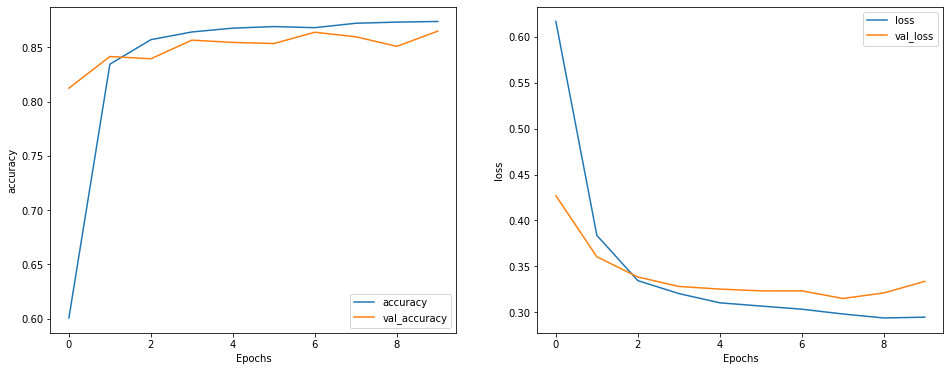

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
